In [1]:
import io
from time import time

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'
from P4_Openclassroom_Functions import *
import warnings
warnings.filterwarnings('ignore')

import dill

import scipy.stats as st

from sklearn.compose import make_column_transformer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, ShuffleSplit

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import *

from sklearn import metrics

In [2]:
df= pd.read_csv("../data/Cleaned_data_seatle.csv")

In [3]:
prop_Q_cols = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
               'PropertyGFAParking', 'PropertyGFABuilding(s)',
               'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'BuildingAge',
               'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified',
               'ExtsurfVolRatio'] # 'ENERGYSTARScore',
prop_C_cols = ['Neighborhood', 'ZipCode', 'CouncilDistrictCode',
               'BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',
               'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
               'CertifiedPreviousYear', 'EnergyProfile', 'MainEnergy', 'Outlier']
target_cols = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions','SiteEnergyUseWN(kBtu)_log', 'TotalGHGEmissions_log']
                # 'SiteEnergyUseWN(kBtu)_log', 'TotalGHGEmissions_log']

### 1.5 Splitting training and testing set

In [4]:
print(f'--- {df.columns.shape[0]} independent columns ---\
\nquantitative ({len(prop_Q_cols)}): {prop_Q_cols},\
\ncategorical ({len(prop_C_cols)}): {prop_C_cols}')

--- 66 independent columns ---
quantitative (13): ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'BuildingAge', 'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified', 'ExtsurfVolRatio'],
categorical (12): ['Neighborhood', 'ZipCode', 'CouncilDistrictCode', 'BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'CertifiedPreviousYear', 'EnergyProfile', 'MainEnergy', 'Outlier']


In [5]:
print(f'--- {len(target_cols)} target columns ---\
\nquantitative ({len(target_cols)}): {target_cols}')

--- 4 target columns ---
quantitative (4): ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)_log', 'TotalGHGEmissions_log']


## 2 Modelling 

### Définition des fonctions d'évaluation

Nous allons utiliser 3 différentes métriques pour évaluer et sélectionner le modèle tout au long du processus d'optimisation :
- R2 (Coefficient of determination)
- RMSE (Root Mean Squared Error)
- TIME


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings(action='ignore',category=FutureWarning)

mymodels = [ExtraTreesRegressor(), DummyRegressor(),
            LinearRegression(), 
           Ridge(), 
          Lasso(),
          ElasticNet(),
          KNeighborsRegressor(),
          SVR(),
          RandomForestRegressor(),
          GradientBoostingRegressor()]

Mettre les parametres des Machines learning :
-ExtraTreesRegressor()
-DummyRegressor()
-LinearRegression()
-Ridge()
-Lasso()
-ElasticNet()
-KNeighborsRegressor()
-SVR()
-RandomForestRegressor()
-GradientBoostingRegressor()

In [7]:
extra_tree_params={'n_estimators':[100],'n_jobs': [-1]}
dummy_params = {'strategy':['mean']}
lr_params = { 'fit_intercept': [True, False],'positive': [True, False], 'copy_X': [True],'n_jobs': [1, -1]}

ridge_params = {'alpha':[1,0.1,0.01,0.001], 'max_iter':[1000], 'random_state':[42], 'tol':[0.001]}

lasso_params = {'alpha':[1,0.1,0.01,0.001], 'max_iter':[1000], 'random_state':[42], 'tol':[0.001]}

elastic_params = {'alpha': [1,0.1,0.01,0.001], 'max_iter': [1000], 'random_state': [42], 'tol': [0.001]}

knn_params = {'n_neighbors': list(range(1,30))}

svr_params = {'gamma' : ['scale'],'epsilon' : [0.001, 0.01, 0.1, 1], 
              'C' : [0.001, 0.01, 0.1, 1, 10], 'tol':[0.001]}

rfr_params = {'n_estimators': [100, 500, 1000], 'max_features': ['sqrt'], 'n_jobs': [-1], 
              'random_state': [42], 'max_depth': [None]}

gradboost_params = {'n_estimators':[100, 500, 1000], 'random_state': [42], 'max_depth': [None]}


mygrids = [extra_tree_params,dummy_params,lr_params, ridge_params, lasso_params, elastic_params, knn_params, svr_params, 
         rfr_params, gradboost_params ]

In [8]:
df.shape

(863, 66)

### Recherche de modèles de prédiction pour la consommation d energie (SiteEnergyUseWN) without ENERGYSTARScore and with outlieares 
Rappelons que l'objectif est de pouvoir faire des prévisions sur la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

In [9]:
#%pip install -U scikit-learn

In [10]:
X_train, X_test, y_train, y_test = data_preprocessing2(df,prop_C_cols,prop_Q_cols,'SiteEnergyUseWN(kBtu)_log',0.2)
compar_results_energy = regressor_compar(X_train, X_test, y_train, y_test, models=mymodels, 
                                         grids=mygrids, foldername='../data/pickle/SiteEnergyUseWN/withoutlieaires/withoutENERGYSTARScore/')
#compar_results_energy[compar_results_energy.index.str.contains('R²')]
compar_results_energy

Comparative table of models…


extratree     dummy                       lr     ridge  \
Standard Time      2.097643     0.001                 0.065292  0.009125   
GridSearch Time    6.422917  0.930603                 0.447685  0.186715   
RandomSearch Time   9.12981  1.808581                 0.758219  0.361556   
Standard R²        0.668662 -0.001628 -452484480108983746560.0  0.054727   
GridSearch R²      0.665048 -0.001628                 0.072537  0.054727   
RandomSearch R²     0.66489 -0.001628                 0.072537  0.054727   
Standard RMSE      0.727545  1.264962       26885985894.237514  1.228861   
GridSearch RMSE    0.731502  1.264962                  1.21723  1.228861   
RandomSearch RMSE  0.731674  1.264962                  1.21723  1.228861   

                      lasso   elastic       knn       svr        rfr  \
Standard Time        0.0046  0.006006  0.001999  0.039179   2.374621   
GridSearch Time    0.251699  0.260678  0.601183  1.162089   7.568568   
RandomSearch Time  0.507926  0.515677  0.876763  1.785778  13.032637   
Standard R²       -0.001628  0.180777  0.518634  0.671031   0.665711   
GridSearch R²      0.128901  0.154315    0.5008  0.671031   0.674314   
RandomSearch R²    0.128901  0.154315    0.5008  0.671031   0.674314   
Standard RMSE      1.264962  1.143998  0.876924  0.724939   0.730777   
GridSearch RMSE    1.179663  1.162327  0.893021  0.724939   0.721313   
RandomSearch RMSE  1.179663  1.162327  0.893021  0.724939   0.721313   

                   gradboost  
Standard Time       0.513105  
GridSearch Time    11.741858  
RandomSearch Time  23.115202  
Standard R²         0.704867  
GridSearch R²        0.45525  
RandomSearch R²      0.45525  
Standard RMSE       0.686646  
GridSearch RMSE     0.932874  
RandomSearch RMSE   0.932874

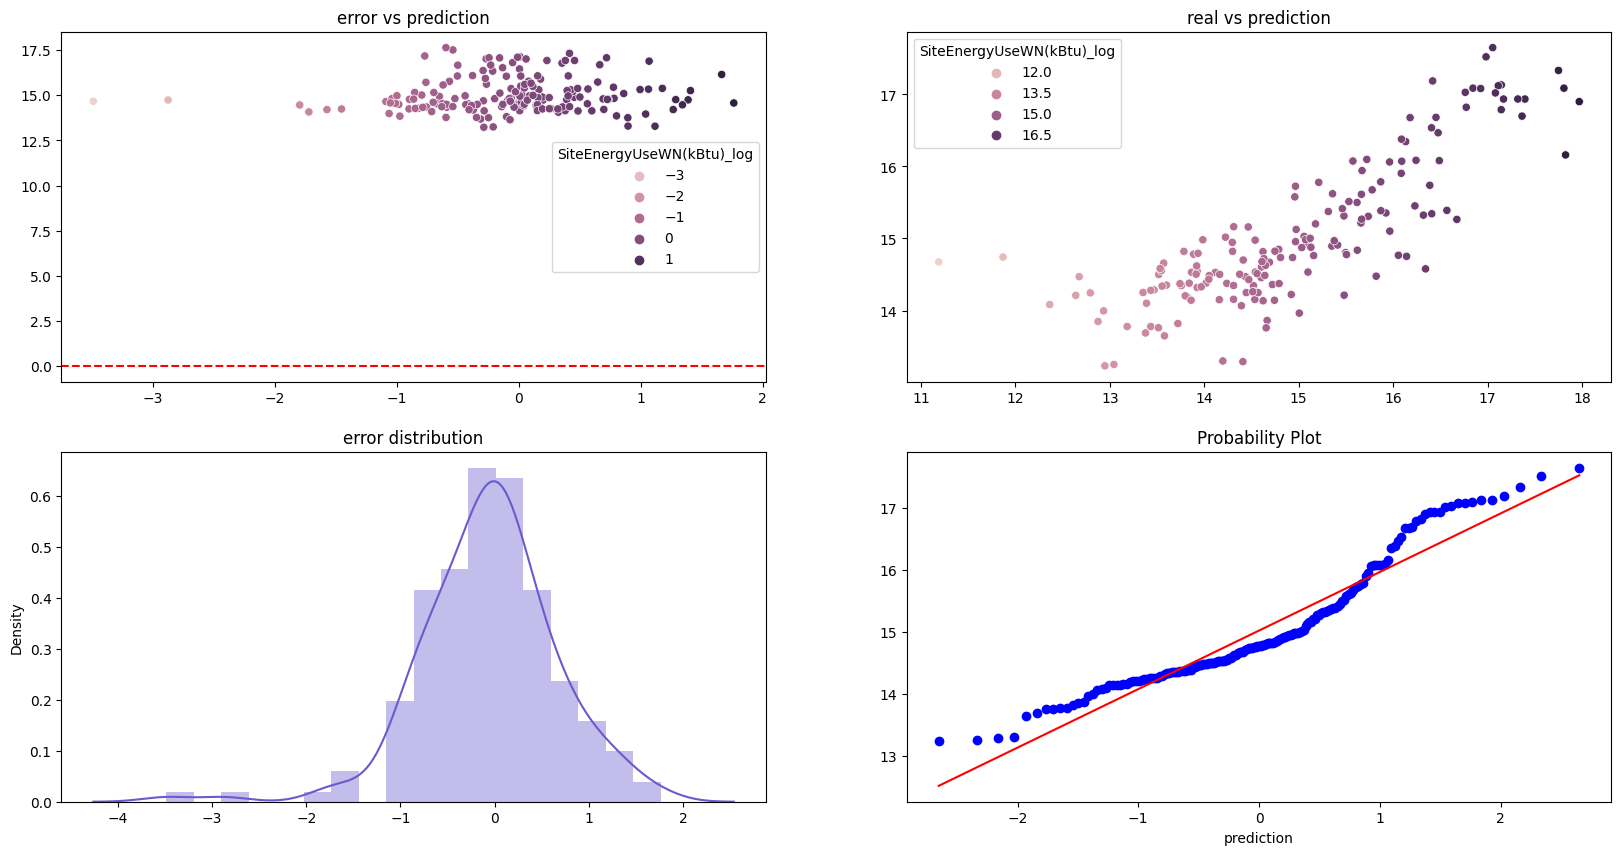

In [11]:
regression_visualizers(get_model='SVR_gridsearch', X_test=X_test, y_test=y_test, get_folder='../DATA/pickle/SiteEnergyUseWN/withoutlieaires/withoutENERGYSTARScore/')

Métrique de performance pour le modèle DummyRegressor_gridsearch.pkl :
R²: -0.0016278839185353
RMSE: 1.2649615523670927
MAE: 1.0266172457974527
MSE: 1.6001277289669653


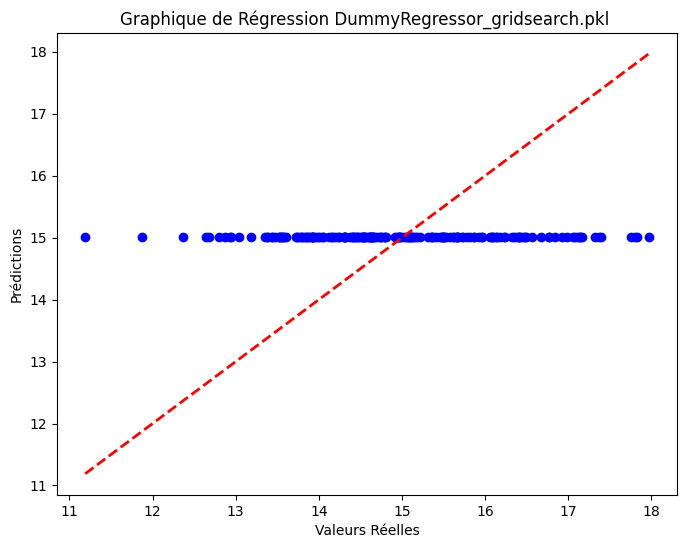

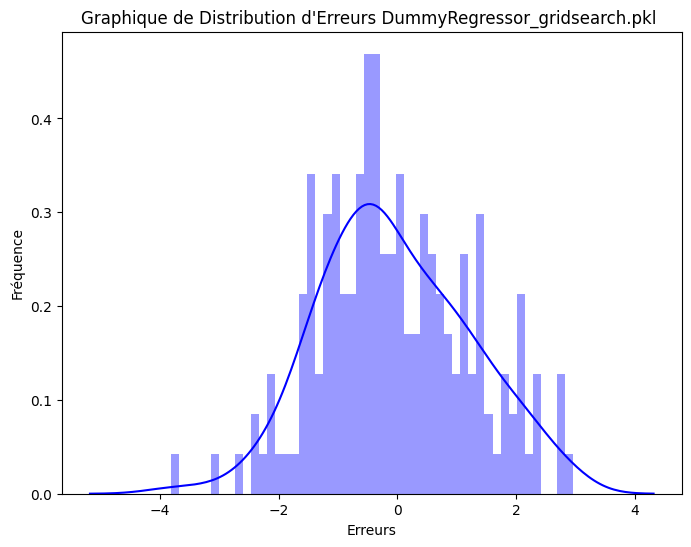

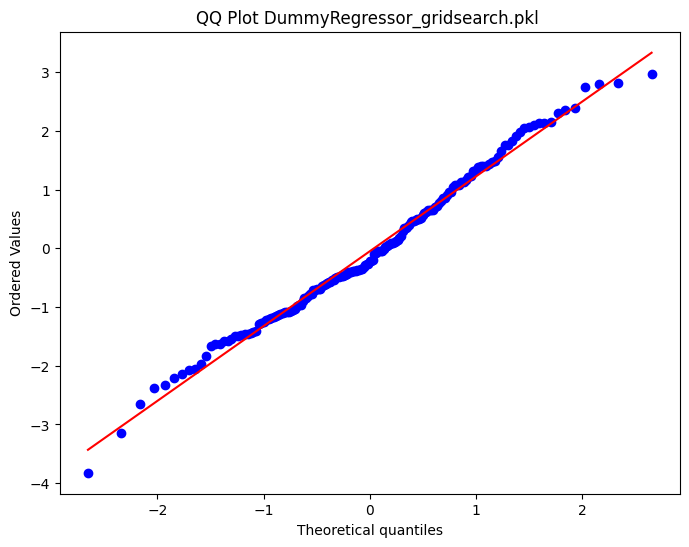

Métrique de performance pour le modèle DummyRegressor_randomsearch.pkl :
R²: -0.0016278839185353
RMSE: 1.2649615523670927
MAE: 1.0266172457974527
MSE: 1.6001277289669653


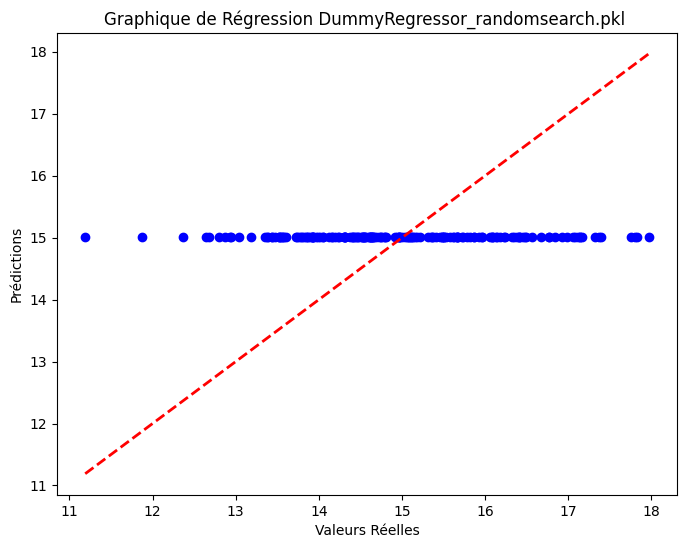

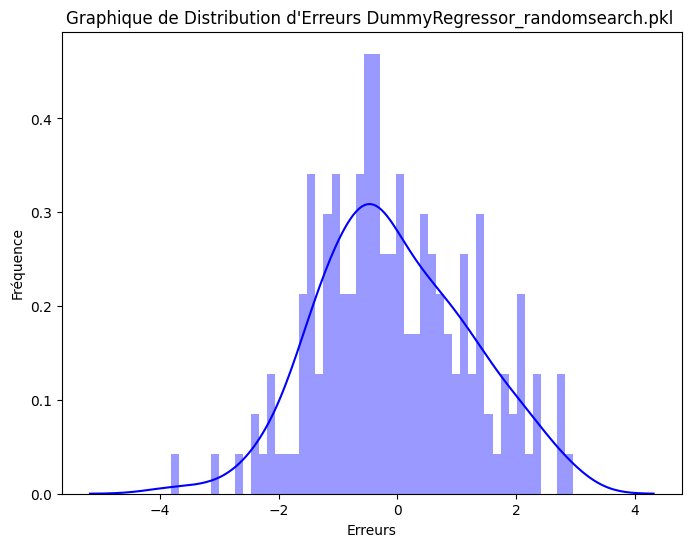

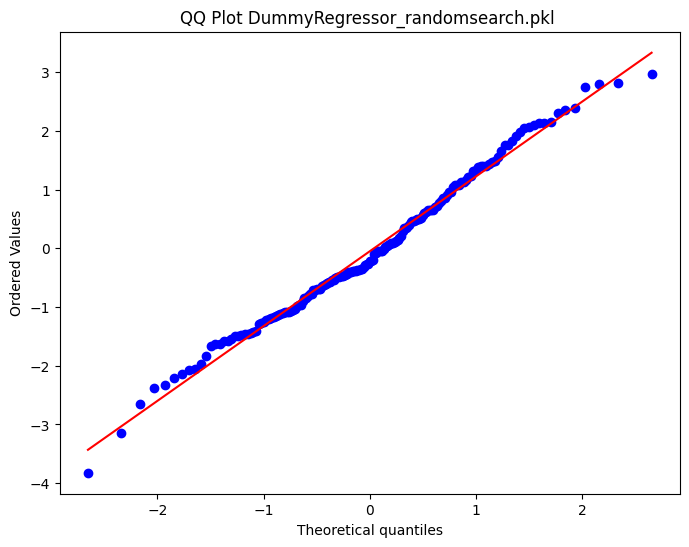

Métrique de performance pour le modèle DummyRegressor_standard.pkl :
R²: -0.0016278839185353
RMSE: 1.2649615523670927
MAE: 1.0266172457974527
MSE: 1.6001277289669653


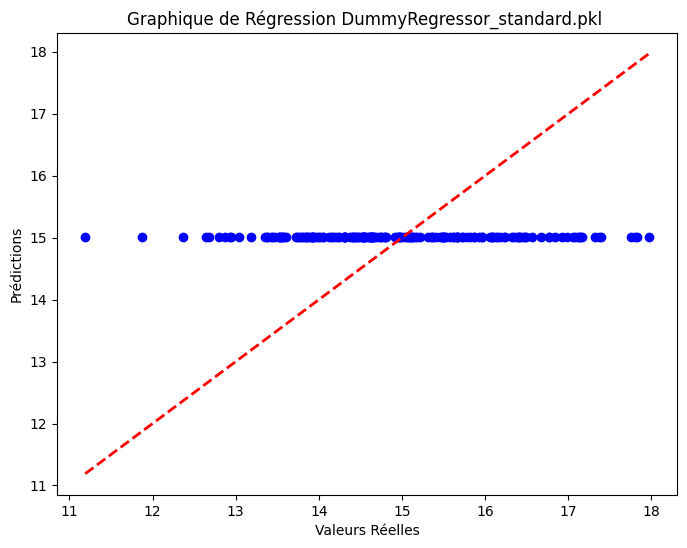

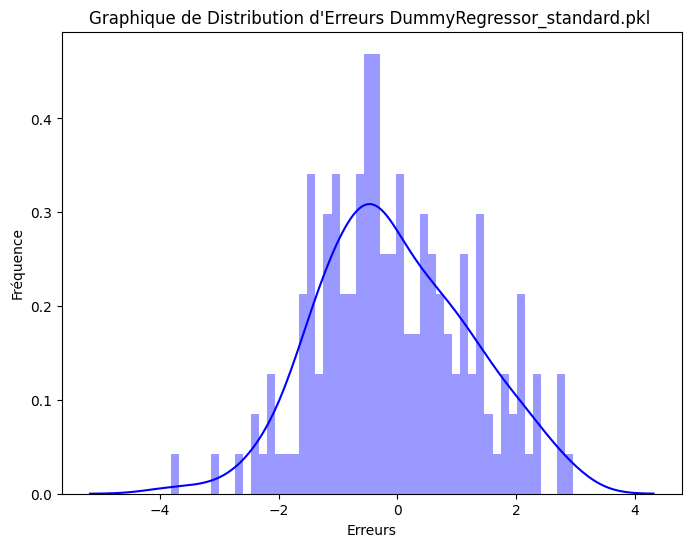

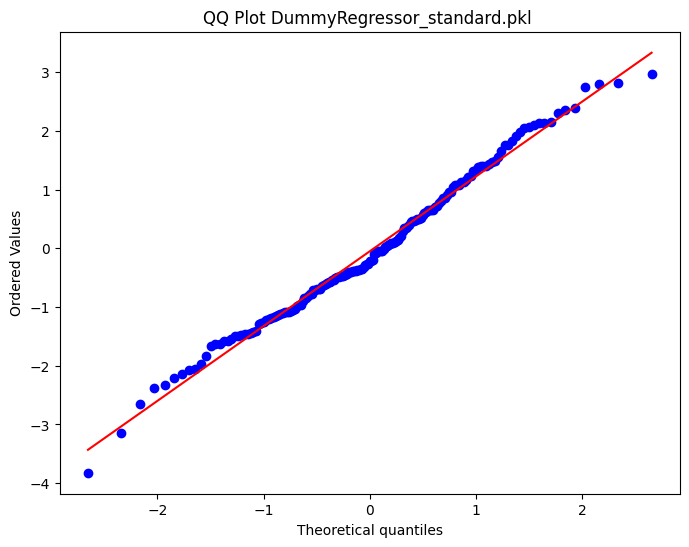

Métrique de performance pour le modèle ElasticNet_gridsearch.pkl :
R²: 0.1543150320253781
RMSE: 1.162327272510022
MAE: 0.6898364787676442
MSE: 1.351004688420587


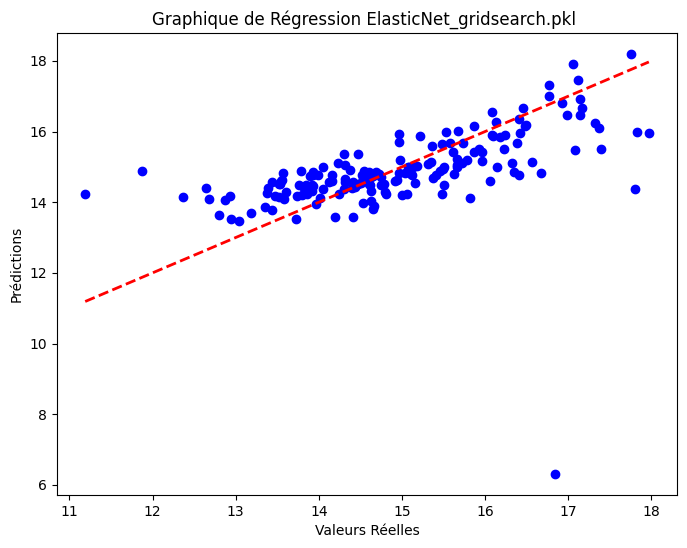

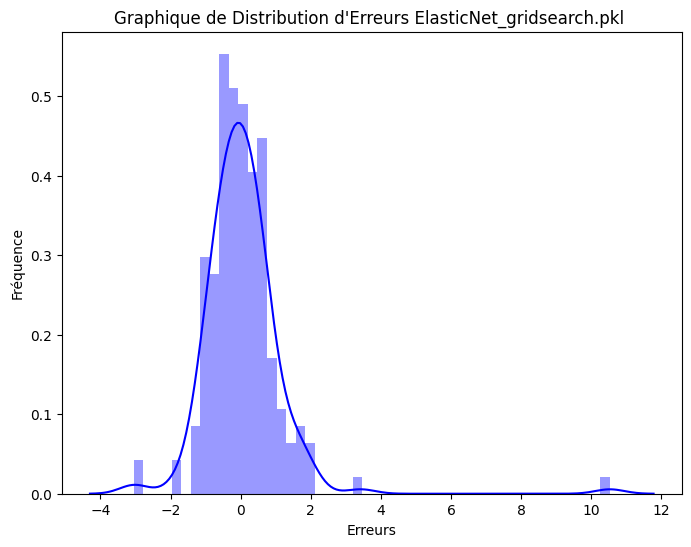

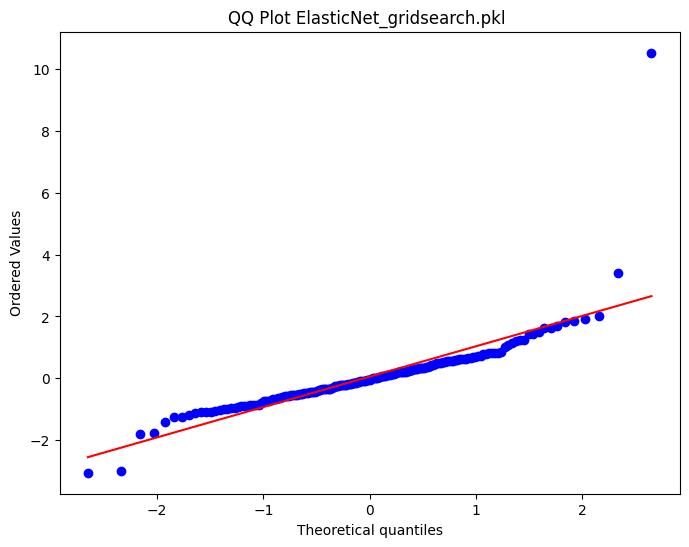

Métrique de performance pour le modèle ElasticNet_randomsearch.pkl :
R²: 0.1543150320253781
RMSE: 1.162327272510022
MAE: 0.6898364787676442
MSE: 1.351004688420587


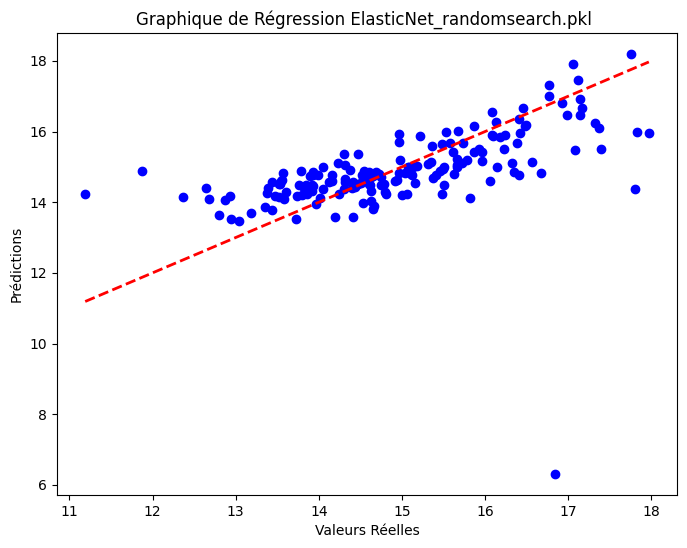

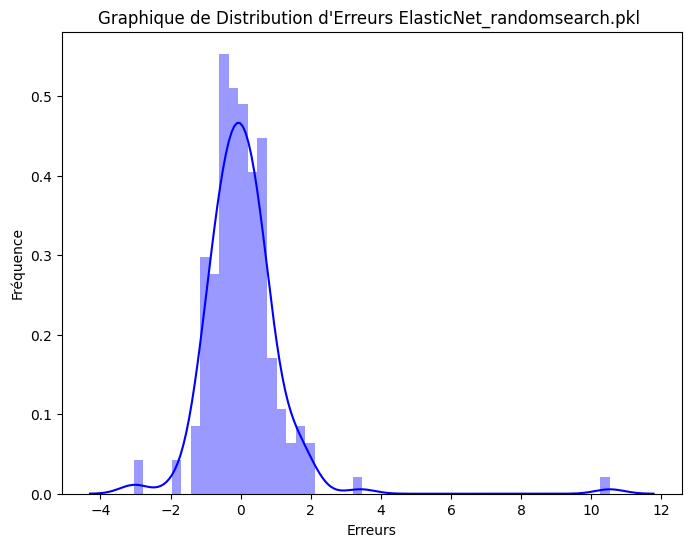

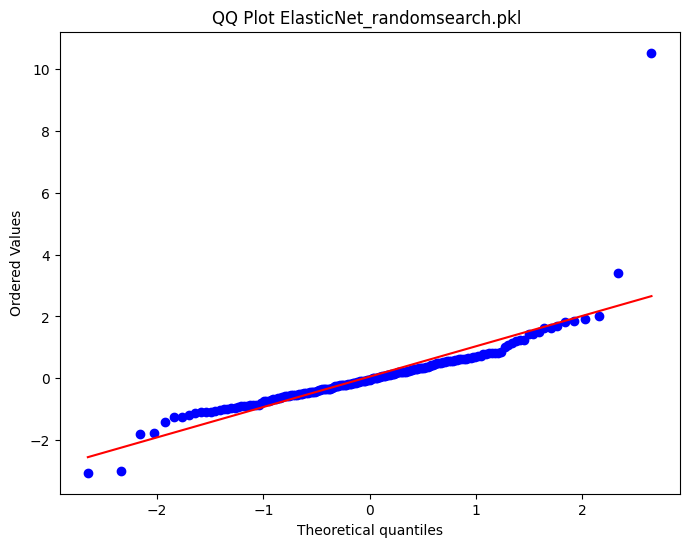

Métrique de performance pour le modèle ElasticNet_standard.pkl :
R²: 0.18077715489058732
RMSE: 1.1439976962194554
MAE: 0.9282610624235185
MSE: 1.308730728955421


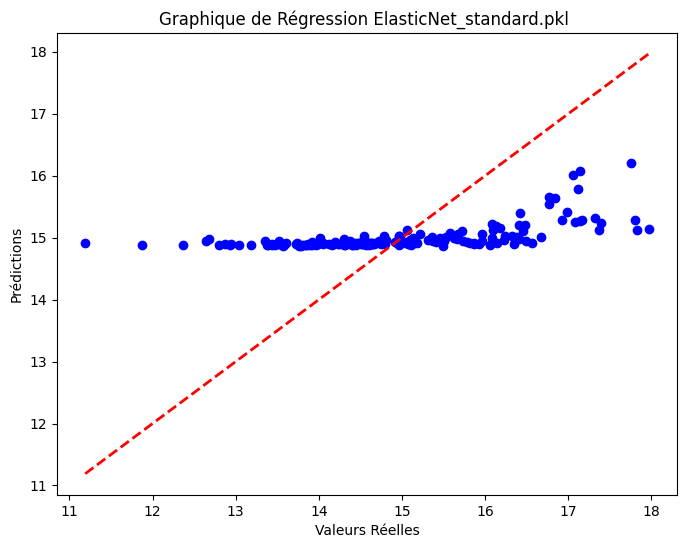

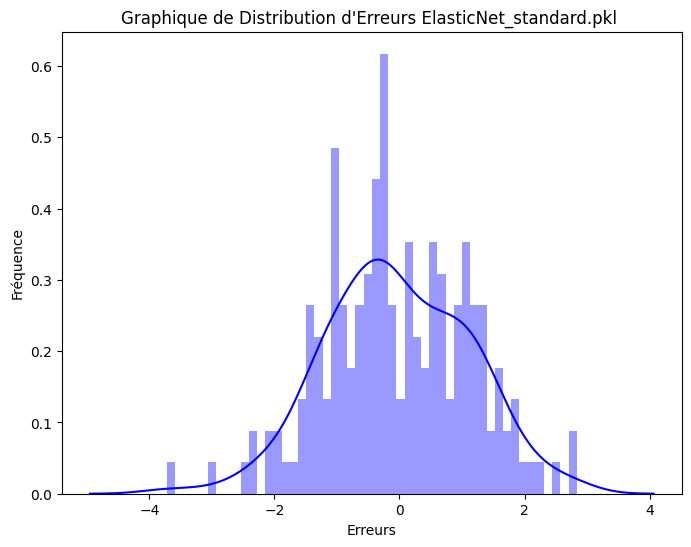

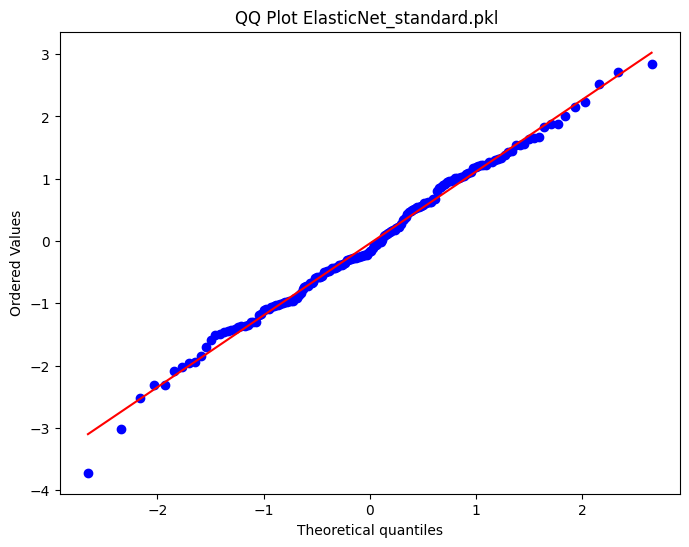

Métrique de performance pour le modèle ExtraTreesRegressor_gridsearch.pkl :
R²: 0.6650476940603276
RMSE: 0.7315021527103651
MAE: 0.5286921941761912
MSE: 0.5350953994198983


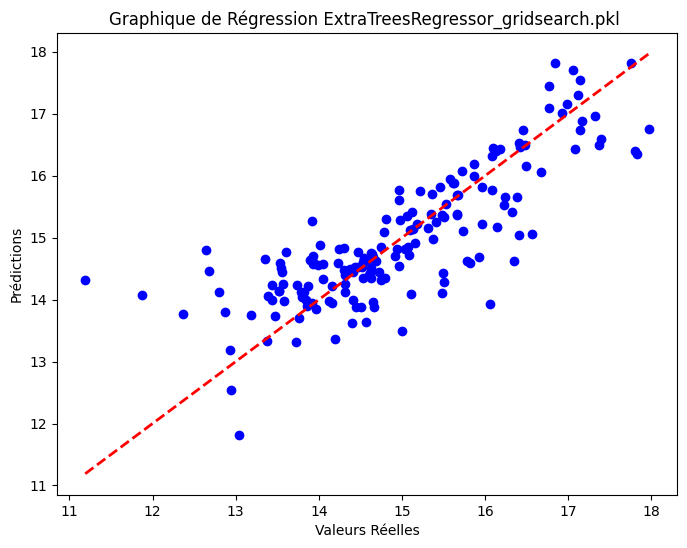

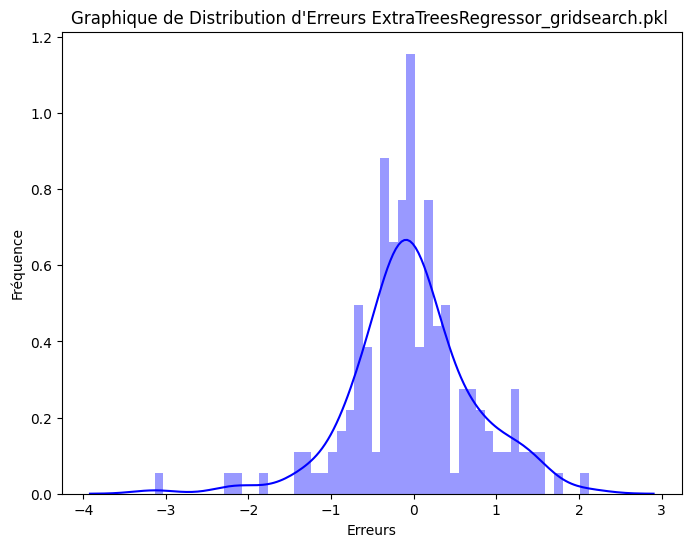

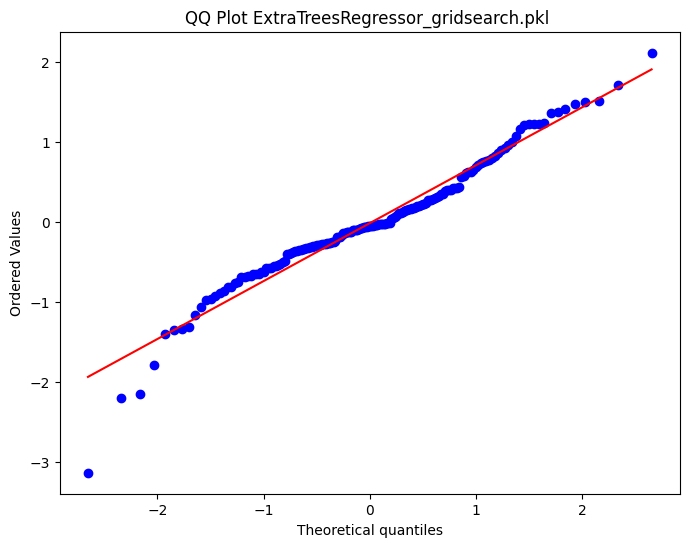

Métrique de performance pour le modèle ExtraTreesRegressor_randomsearch.pkl :
R²: 0.664889993218806
RMSE: 0.7316743338359393
MAE: 0.5280406305536038
MSE: 0.5353473307942656


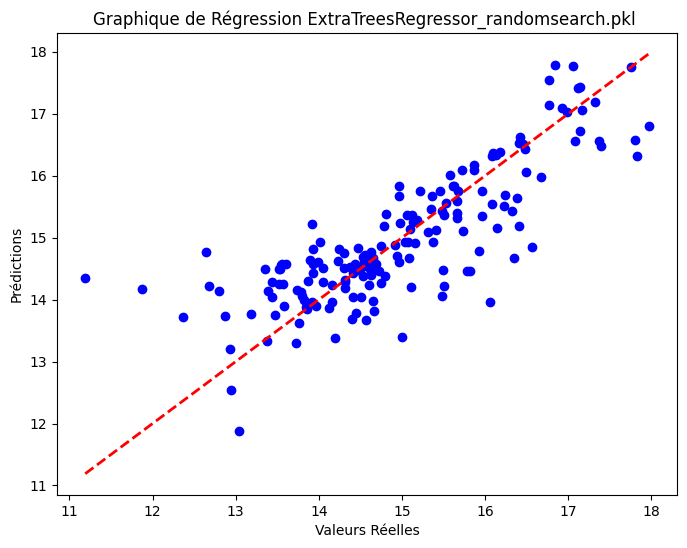

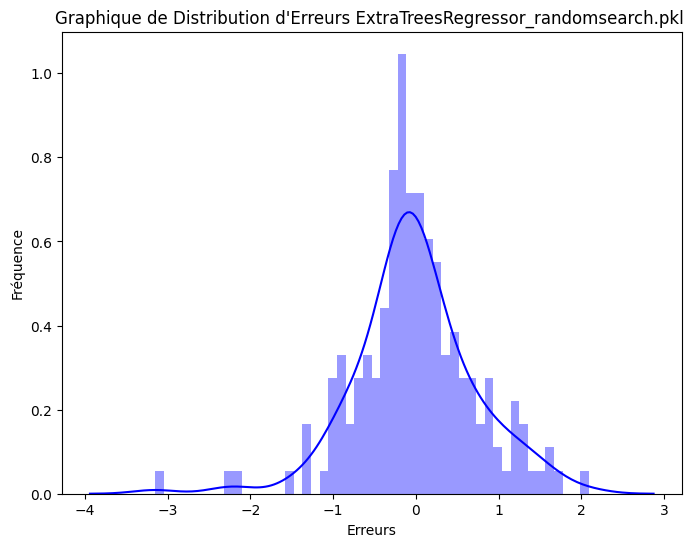

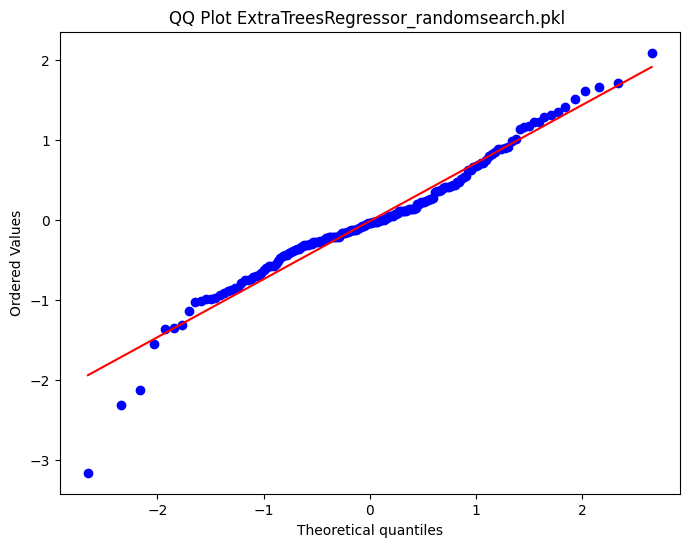

Métrique de performance pour le modèle ExtraTreesRegressor_standard.pkl :
R²: 0.6686619618020433
RMSE: 0.7275448498961864
MAE: 0.527725400581423
MSE: 0.5293215086104643


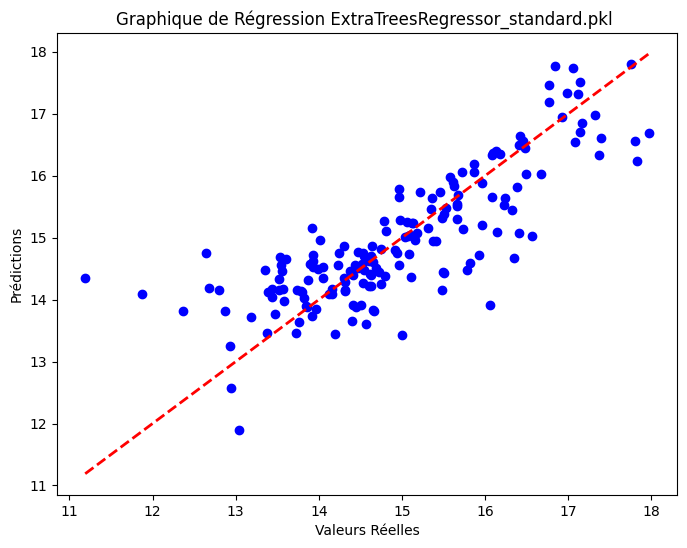

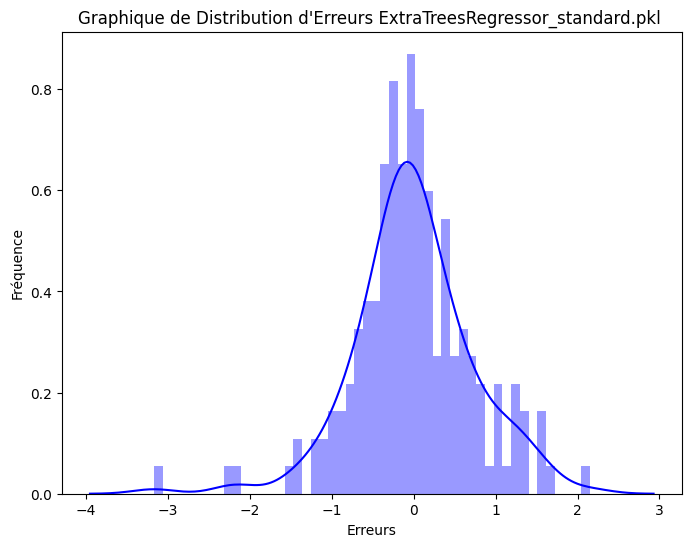

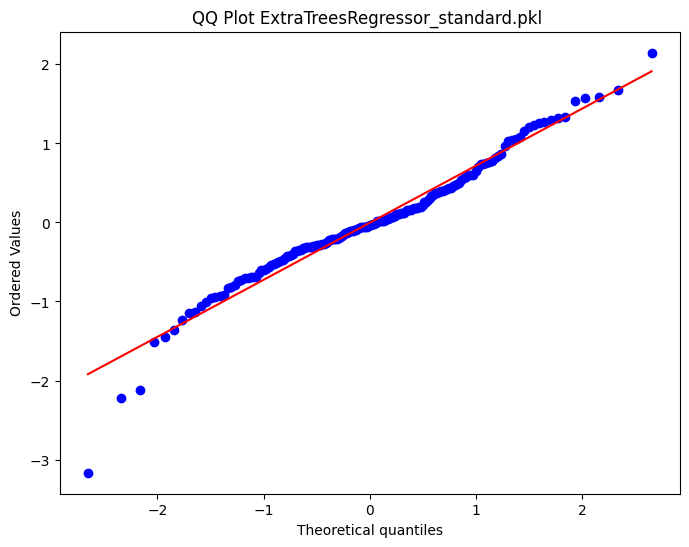

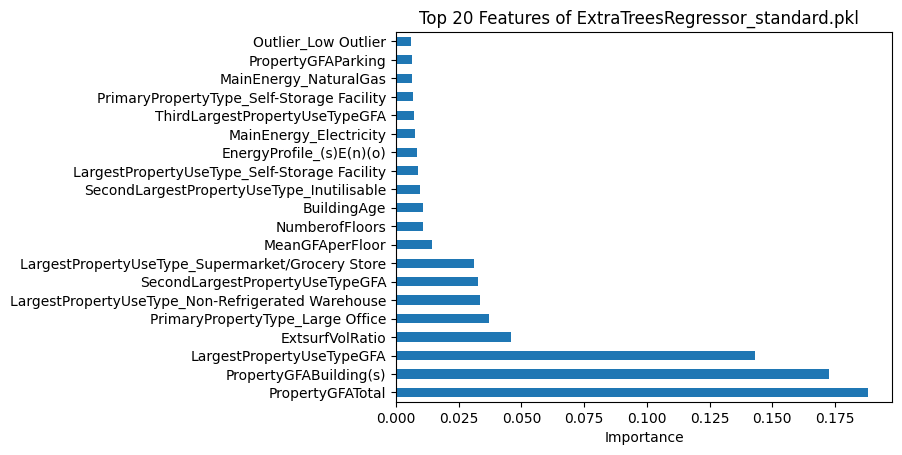

Métrique de performance pour le modèle GradientBoostingRegressor_gridsearch.pkl :
R²: 0.4552498962411754
RMSE: 0.9328735580965056
MAE: 0.7247622195767789
MSE: 0.8702530753956345


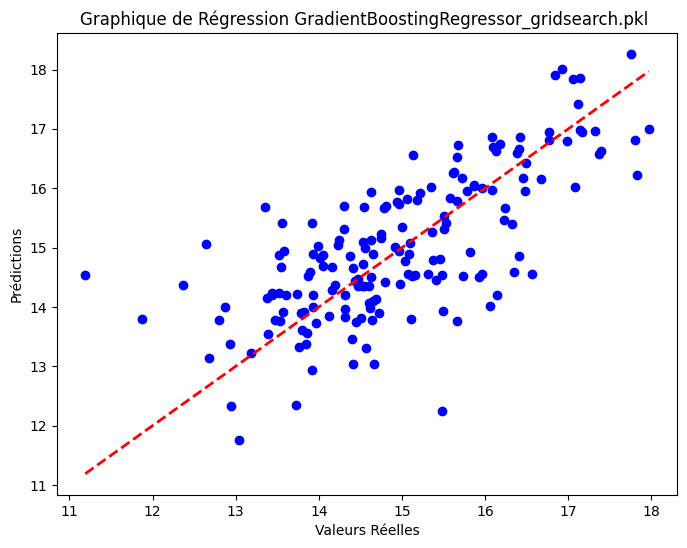

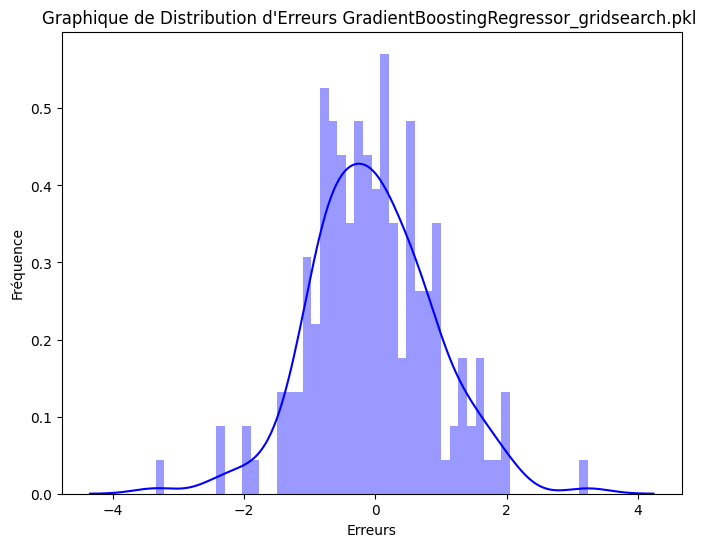

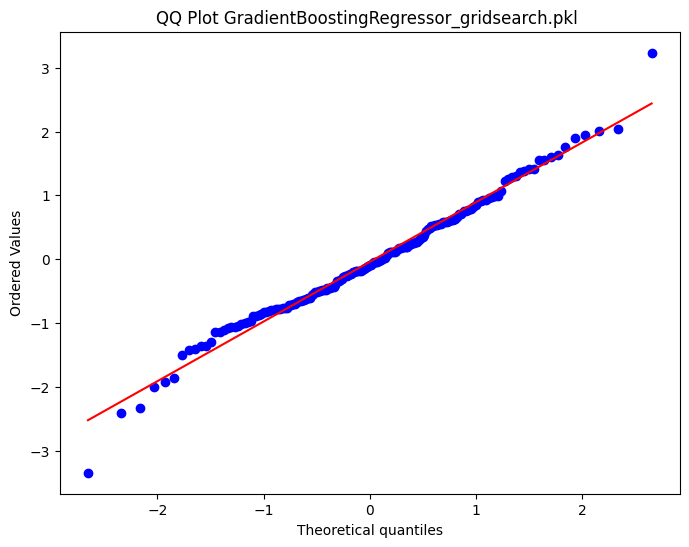

Métrique de performance pour le modèle GradientBoostingRegressor_randomsearch.pkl :
R²: 0.4552498962411754
RMSE: 0.9328735580965056
MAE: 0.7247622195767789
MSE: 0.8702530753956345


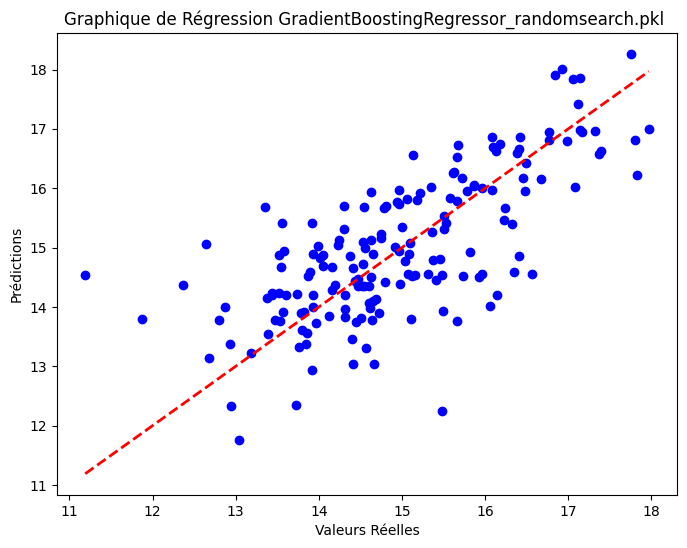

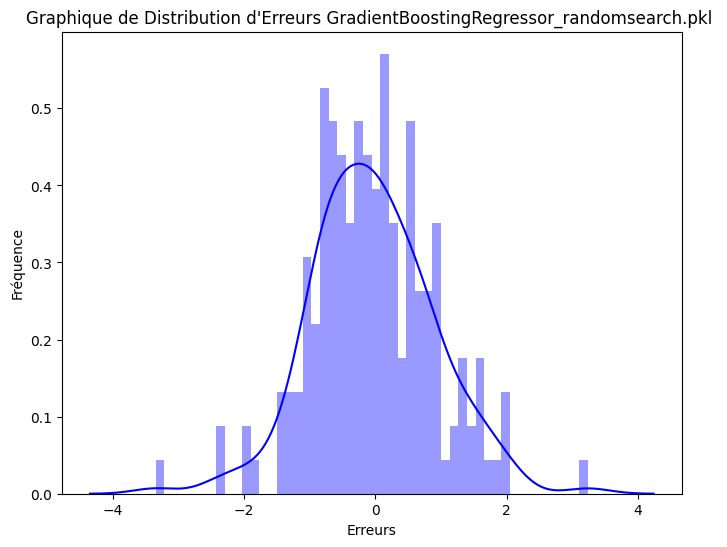

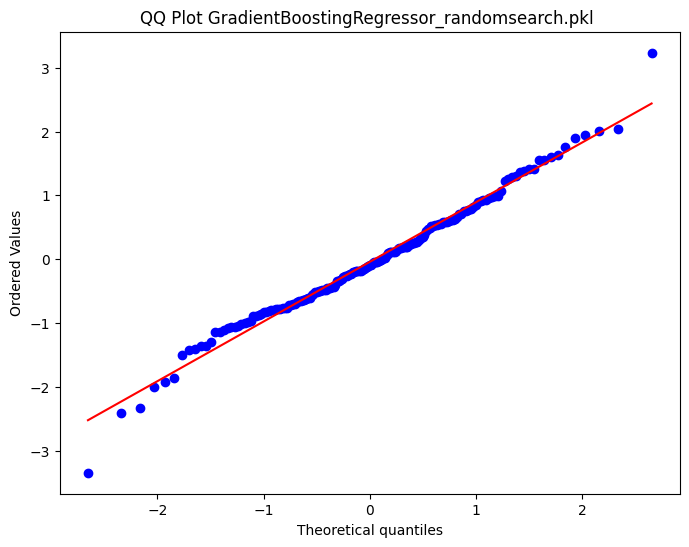

Métrique de performance pour le modèle GradientBoostingRegressor_standard.pkl :
R²: 0.7048668368926947
RMSE: 0.6866463704445379
MAE: 0.5117529263921823
MSE: 0.47148323804465764


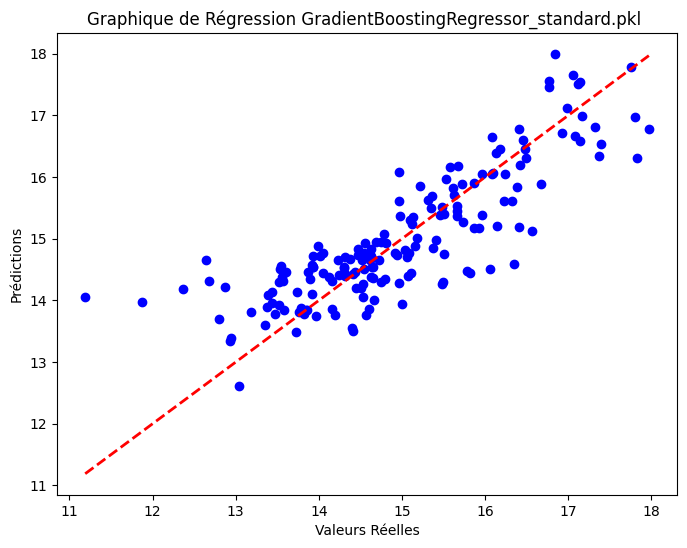

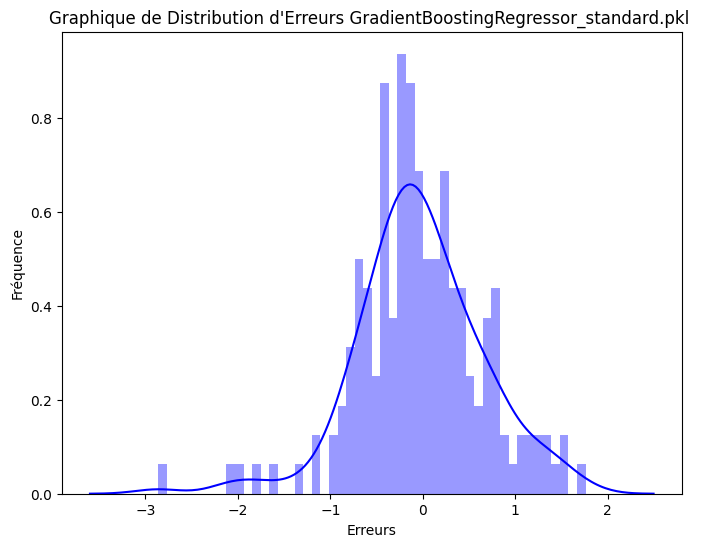

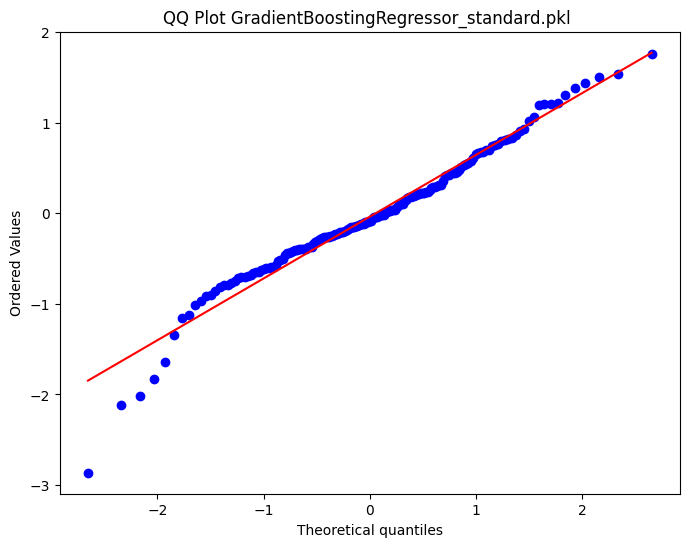

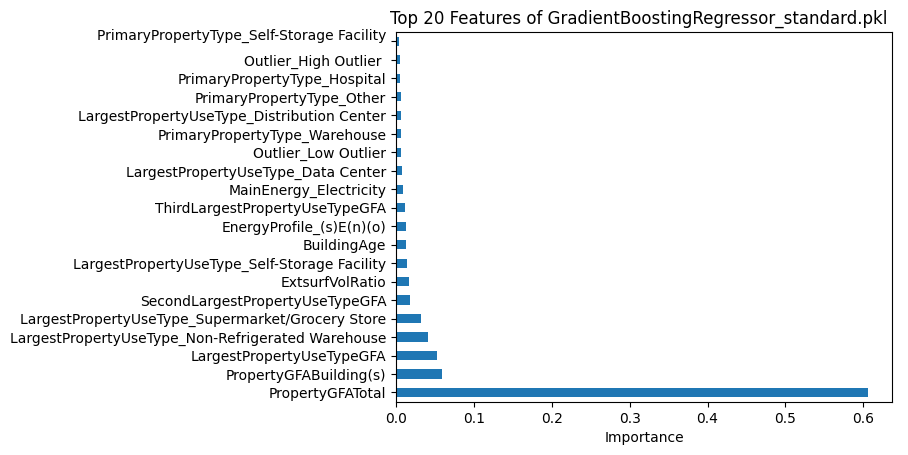

Métrique de performance pour le modèle KNeighborsRegressor_gridsearch.pkl :
R²: 0.5007997208893541
RMSE: 0.8930207132466946
MAE: 0.681460969455808
MSE: 0.7974859942876351


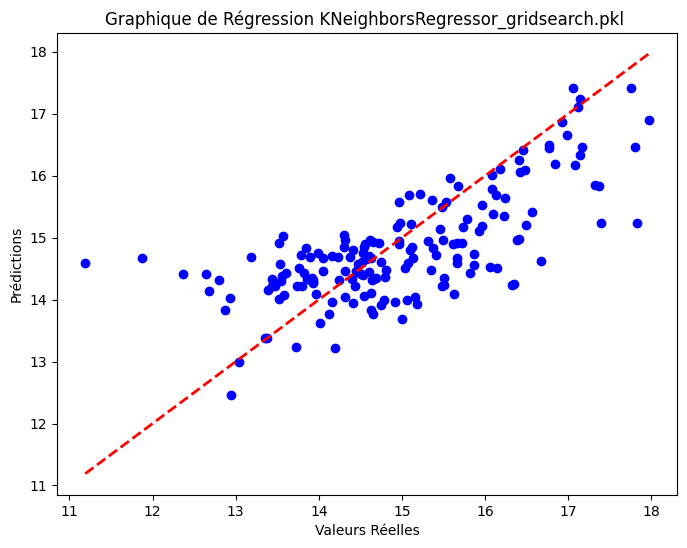

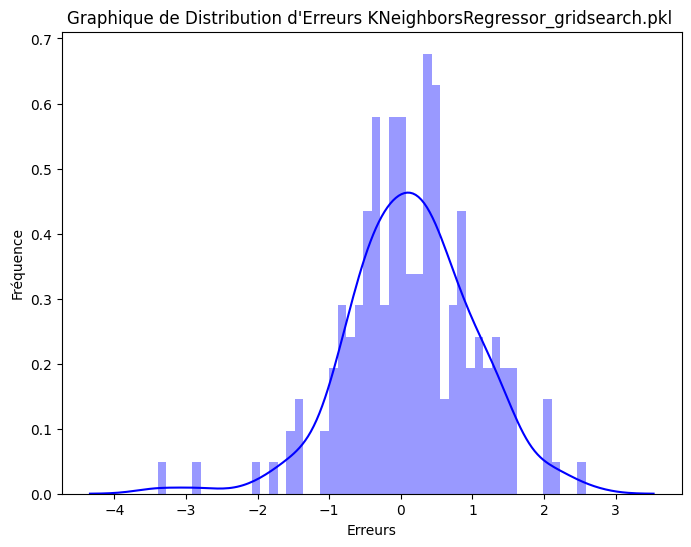

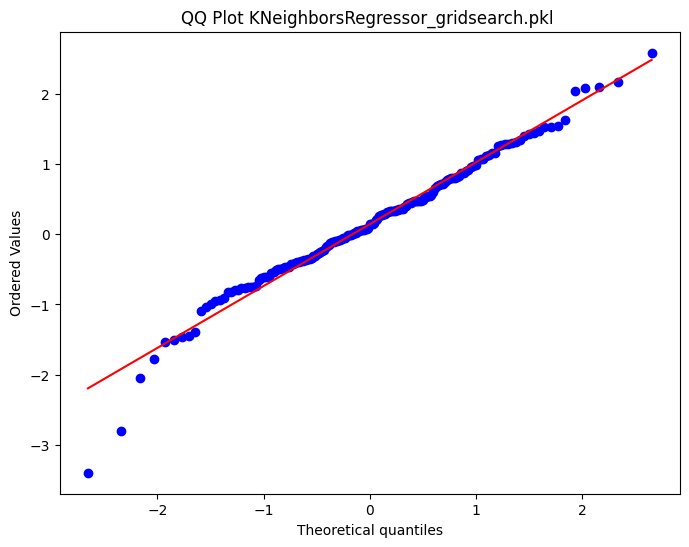

Métrique de performance pour le modèle KNeighborsRegressor_randomsearch.pkl :
R²: 0.5007997208893541
RMSE: 0.8930207132466946
MAE: 0.681460969455808
MSE: 0.7974859942876351


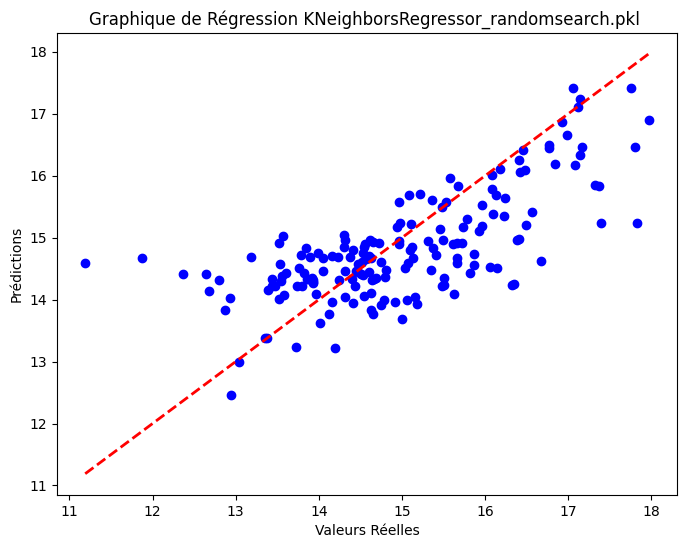

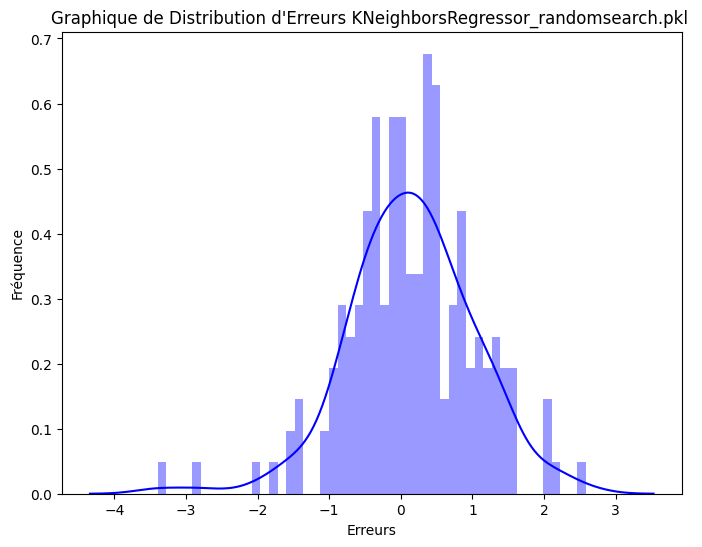

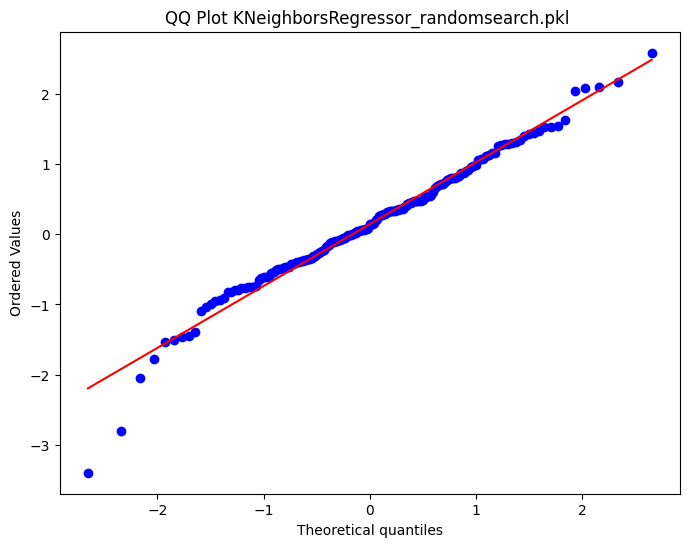

Métrique de performance pour le modèle KNeighborsRegressor_standard.pkl :
R²: 0.5186341846898618
RMSE: 0.8769235738278146
MAE: 0.6430325427988441
MSE: 0.7689949543349466


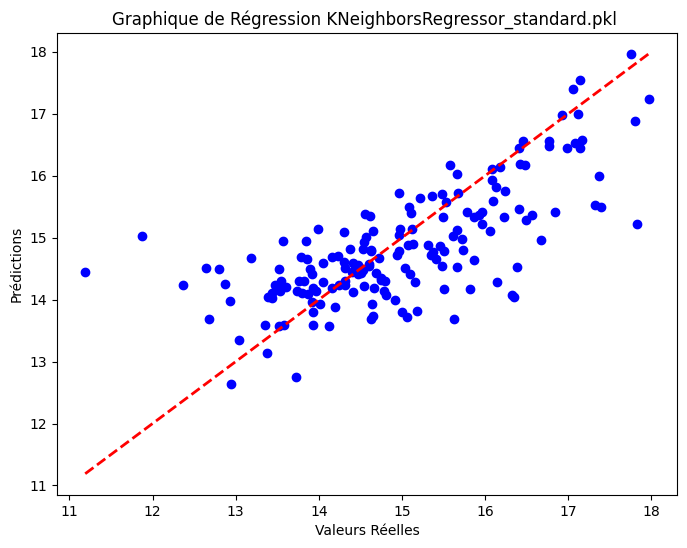

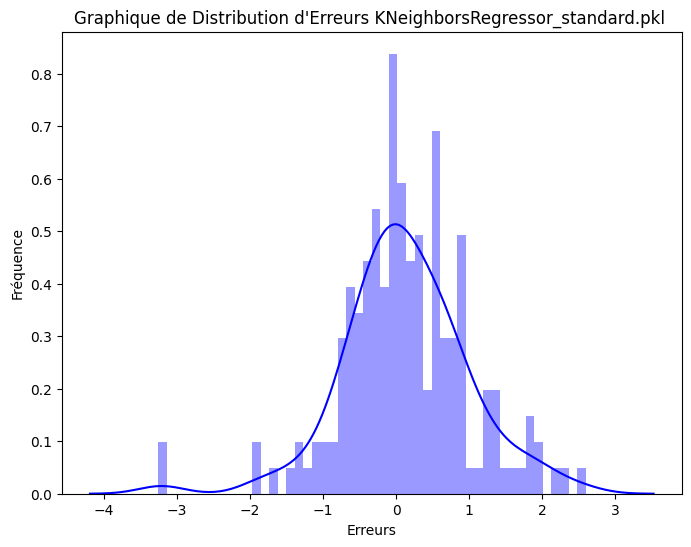

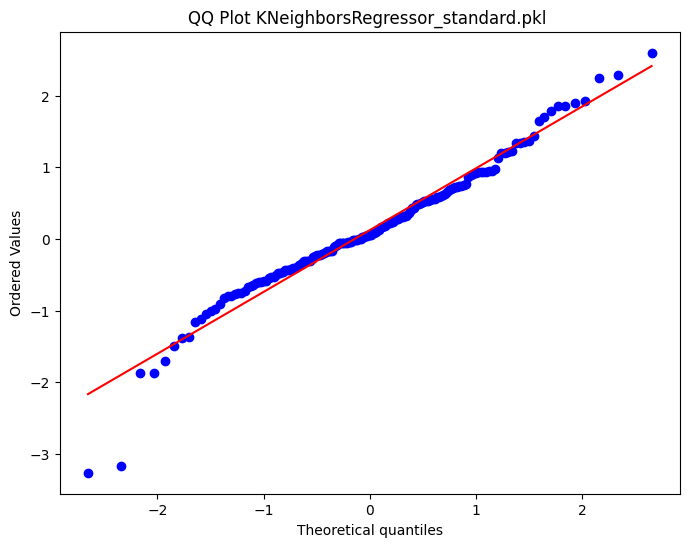

Métrique de performance pour le modèle Lasso_gridsearch.pkl :
R²: 0.12890112752187377
RMSE: 1.1796627020483634
MAE: 0.6972150199791907
MSE: 1.391604090604046


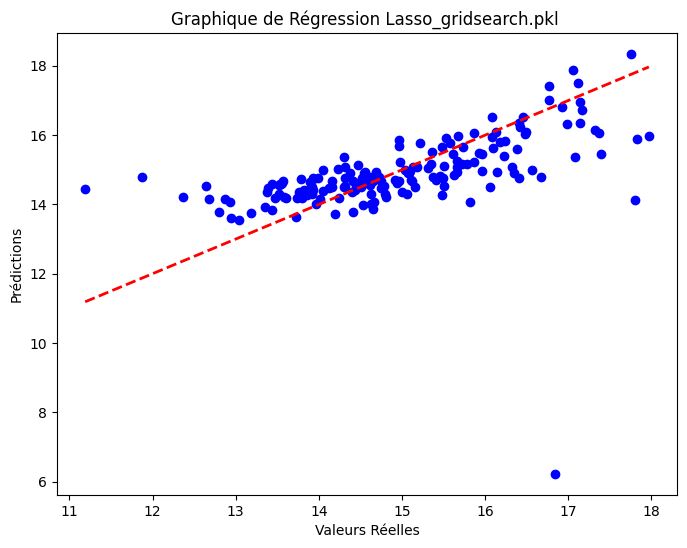

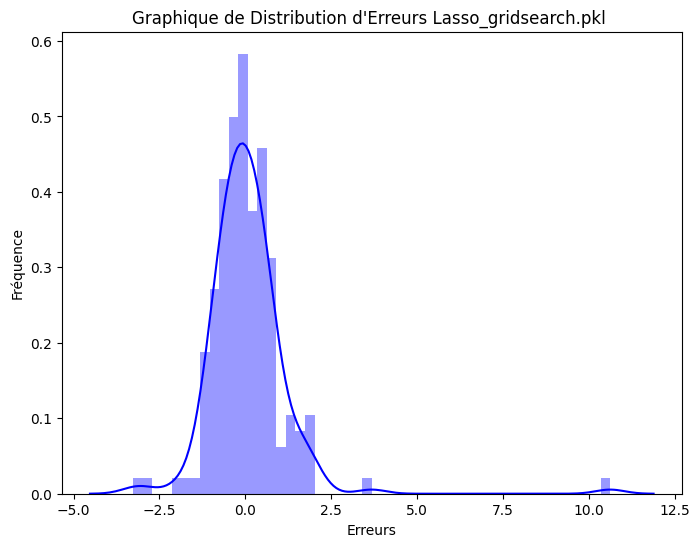

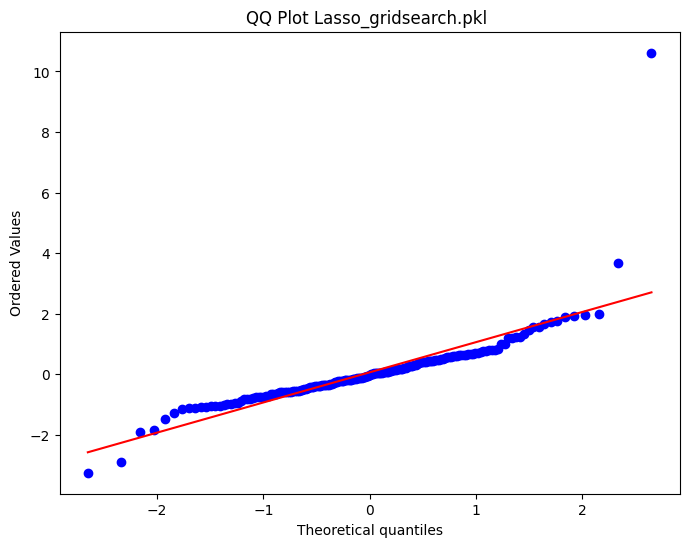

Métrique de performance pour le modèle Lasso_randomsearch.pkl :
R²: 0.12890112752187377
RMSE: 1.1796627020483634
MAE: 0.6972150199791907
MSE: 1.391604090604046


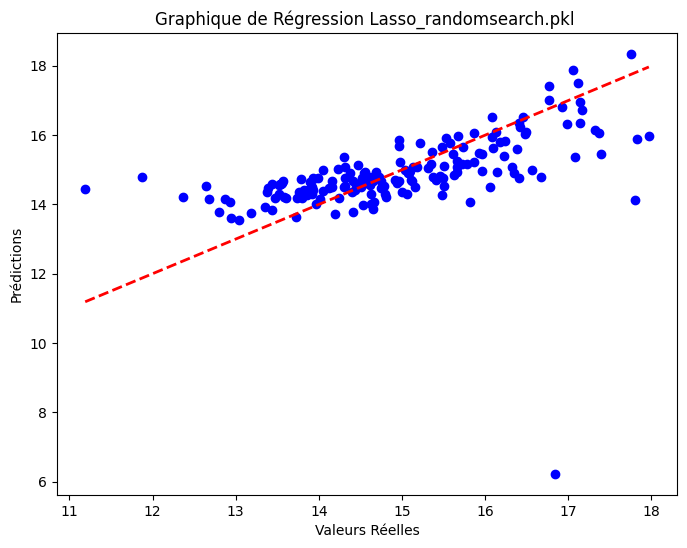

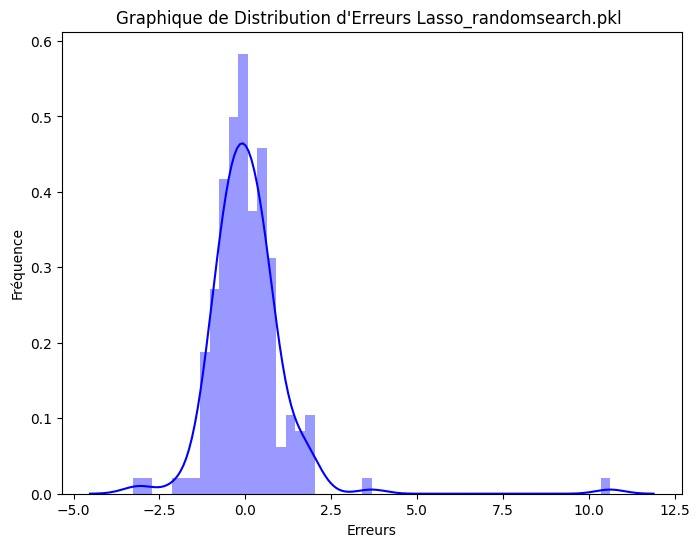

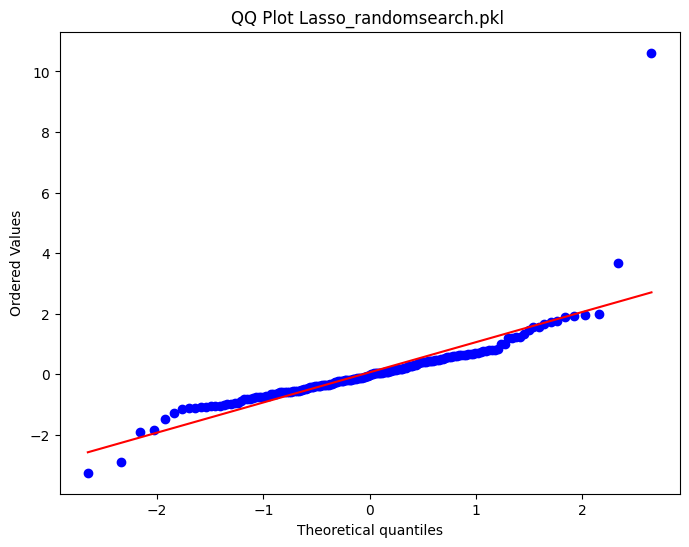

Métrique de performance pour le modèle Lasso_standard.pkl :
R²: -0.0016278839185353
RMSE: 1.2649615523670927
MAE: 1.0266172457974527
MSE: 1.6001277289669653


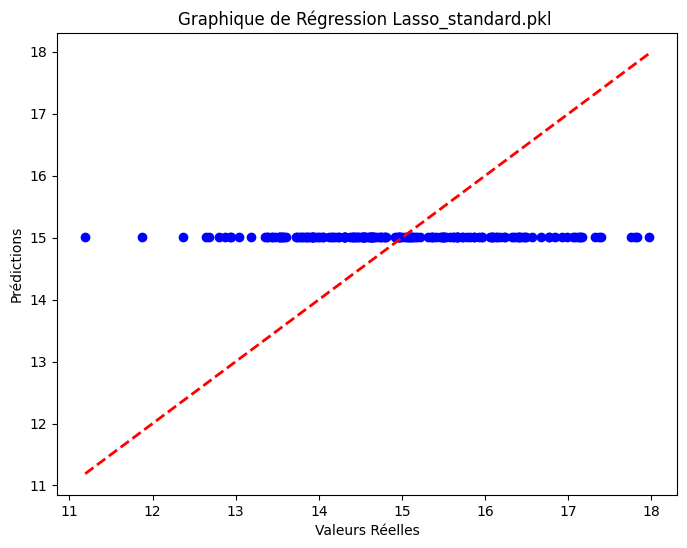

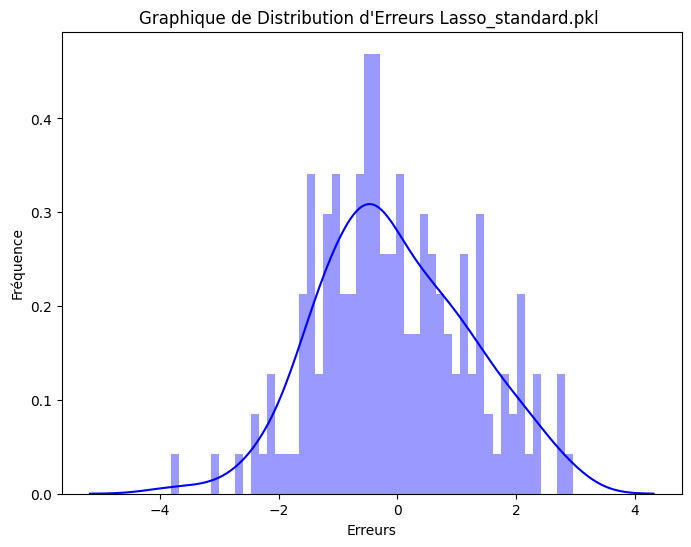

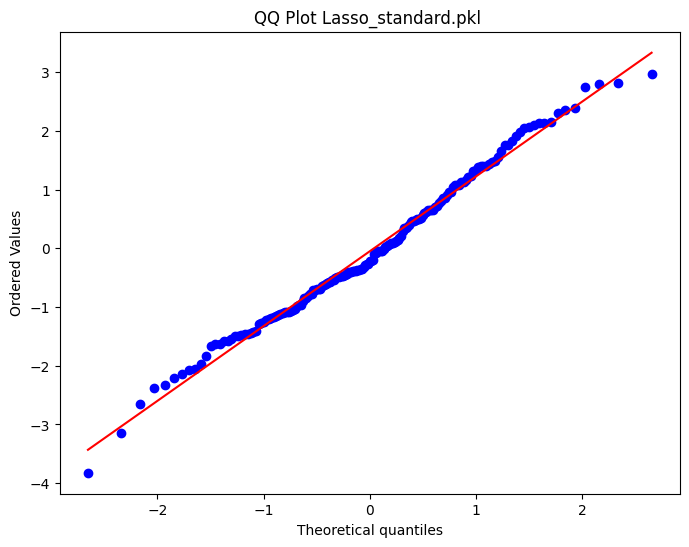

Métrique de performance pour le modèle LinearRegression_gridsearch.pkl :
R²: 0.07253652297871394
RMSE: 1.217229672703491
MAE: 0.8849272864868126
MSE: 1.4816480761098478


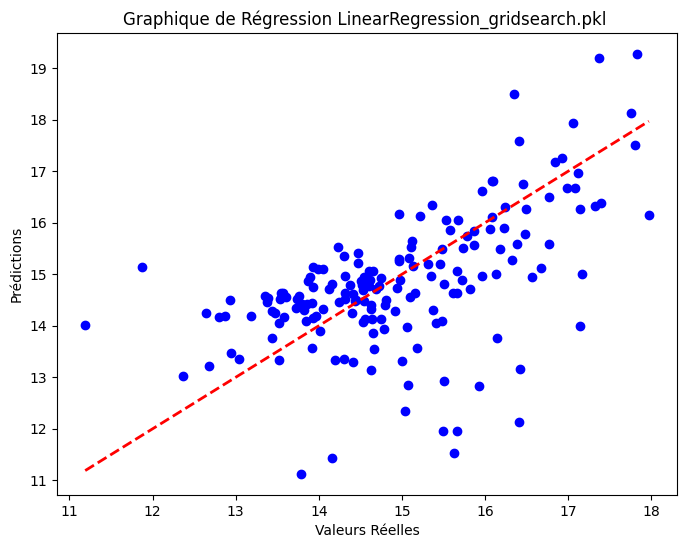

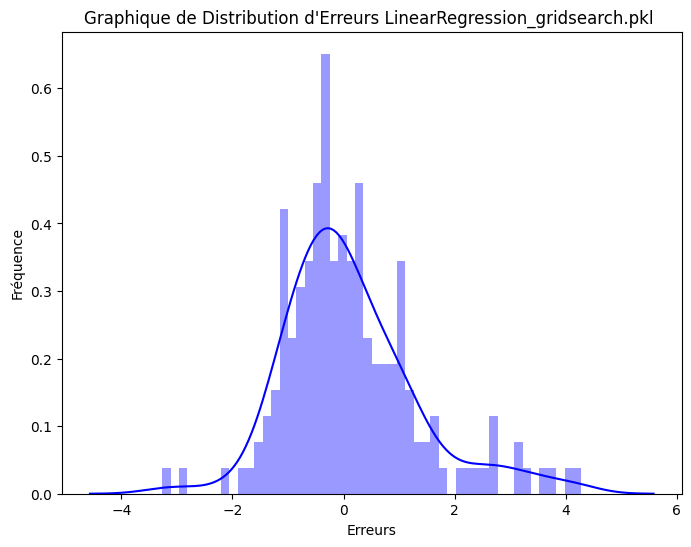

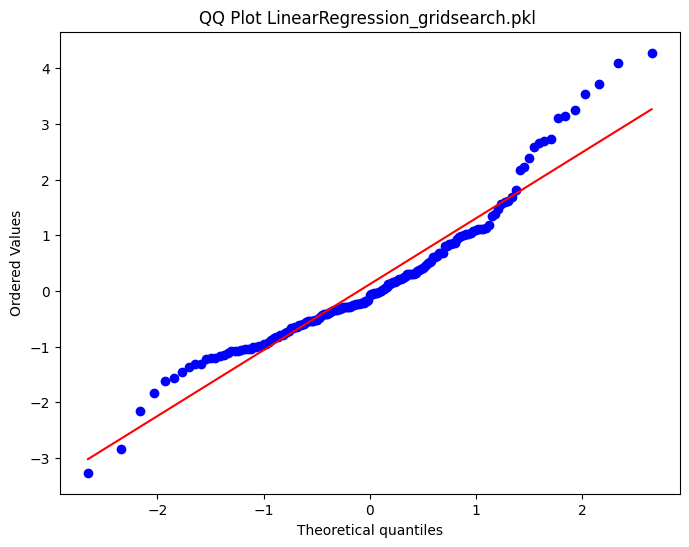

Métrique de performance pour le modèle LinearRegression_randomsearch.pkl :
R²: 0.07253652297871394
RMSE: 1.217229672703491
MAE: 0.8849272864868126
MSE: 1.4816480761098478


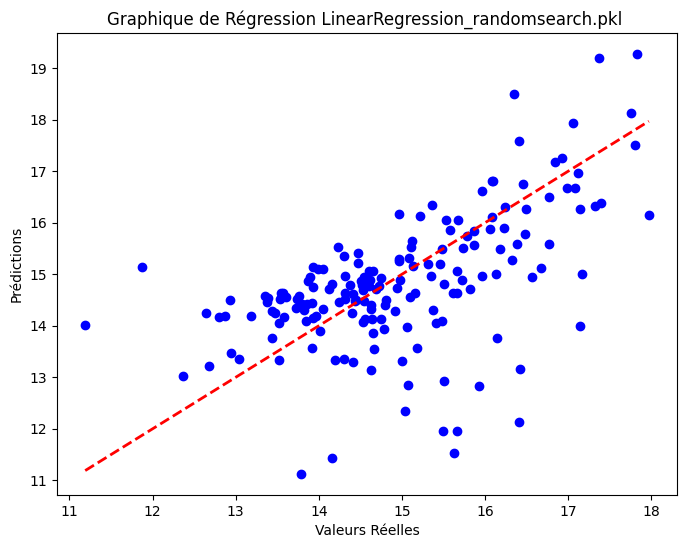

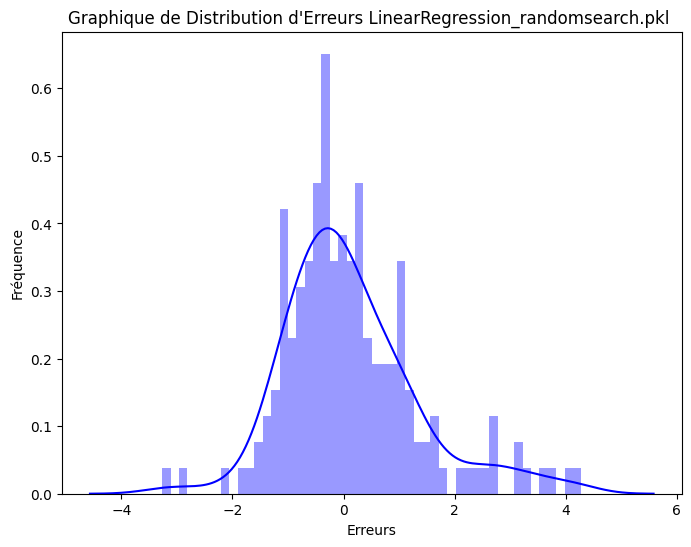

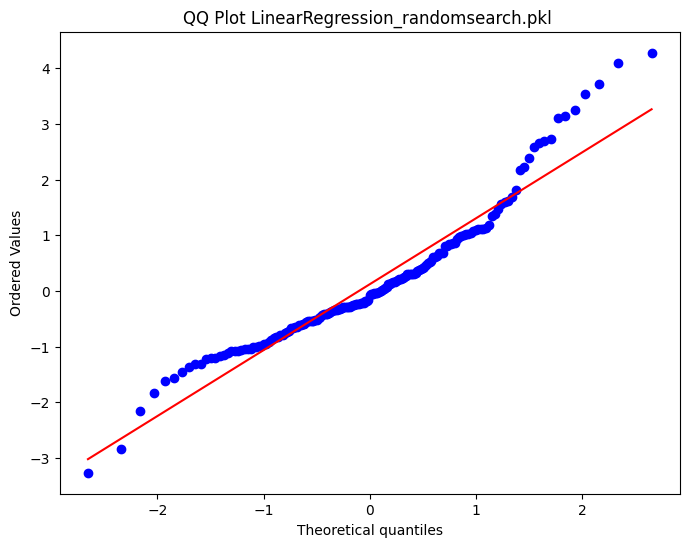

Métrique de performance pour le modèle LinearRegression_standard.pkl :
R²: -4.5248448010898375e+20
RMSE: 26885985894.237514
MAE: 4162689538.3603334
MSE: 7.228562375051387e+20


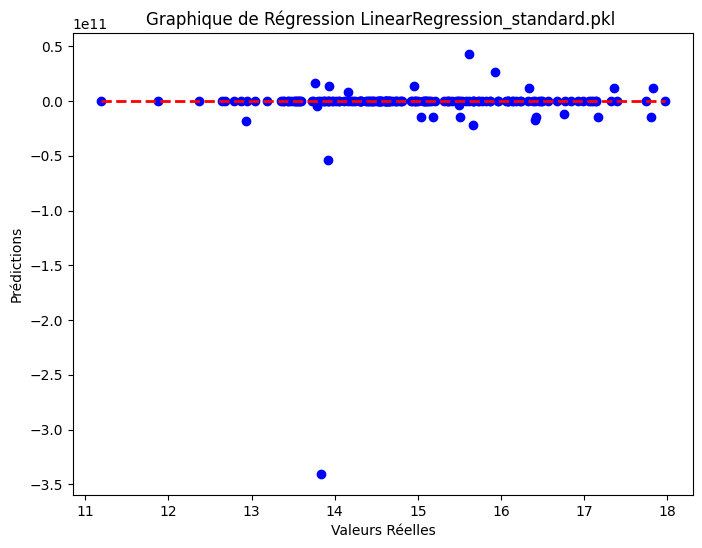

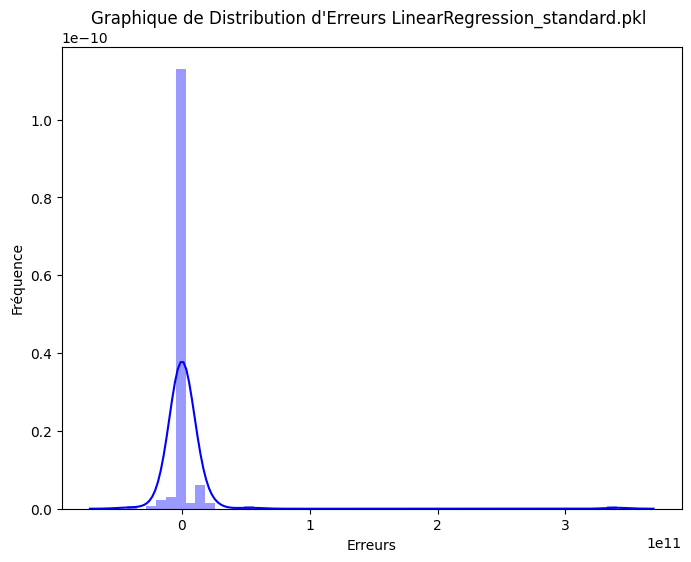

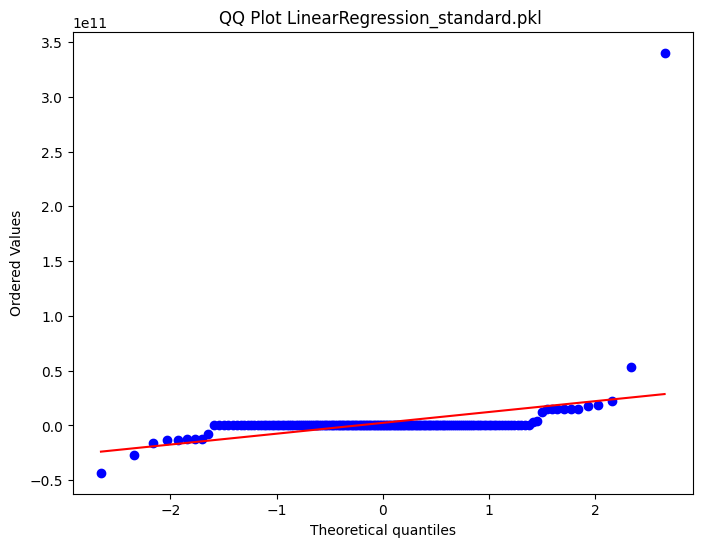

Métrique de performance pour le modèle RandomForestRegressor_gridsearch.pkl :
R²: 0.6743137788128791
RMSE: 0.7213130925916036
MAE: 0.5266285638183955
MSE: 0.5202925775440632


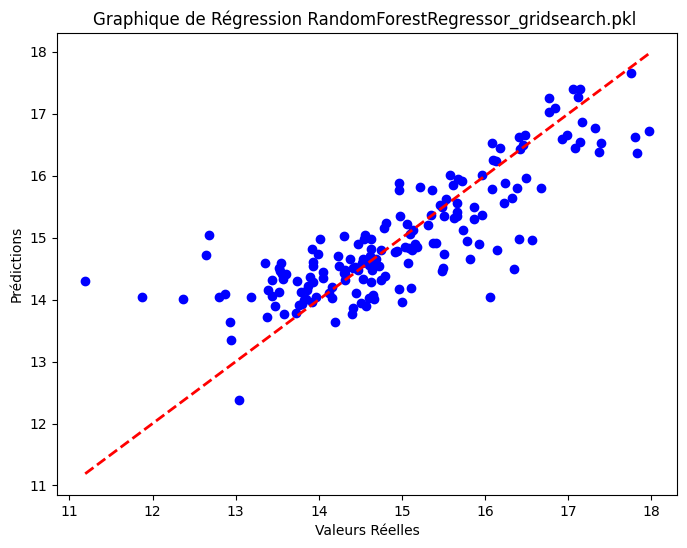

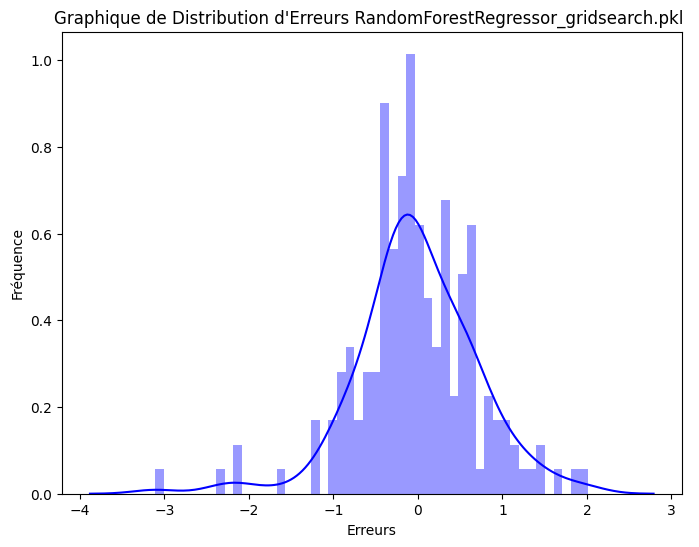

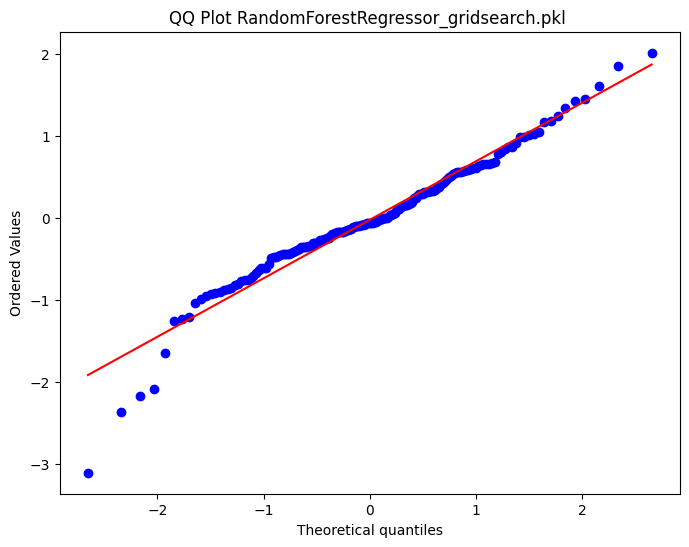

Métrique de performance pour le modèle RandomForestRegressor_randomsearch.pkl :
R²: 0.6743137788128792
RMSE: 0.7213130925916035
MAE: 0.5266285638183953
MSE: 0.5202925775440631


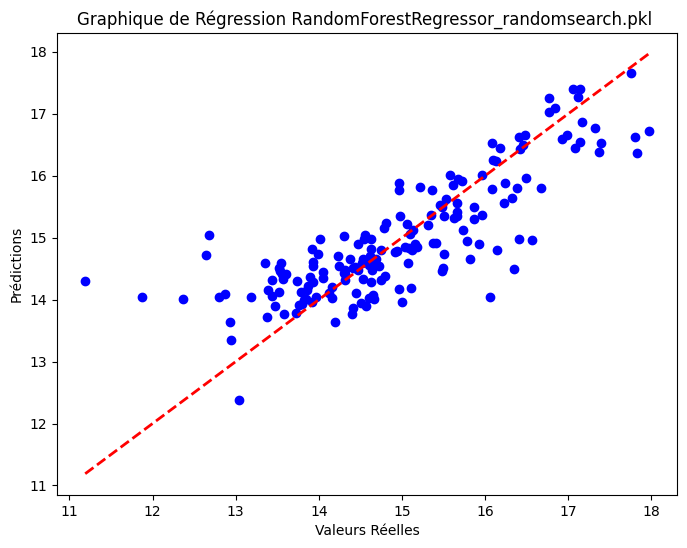

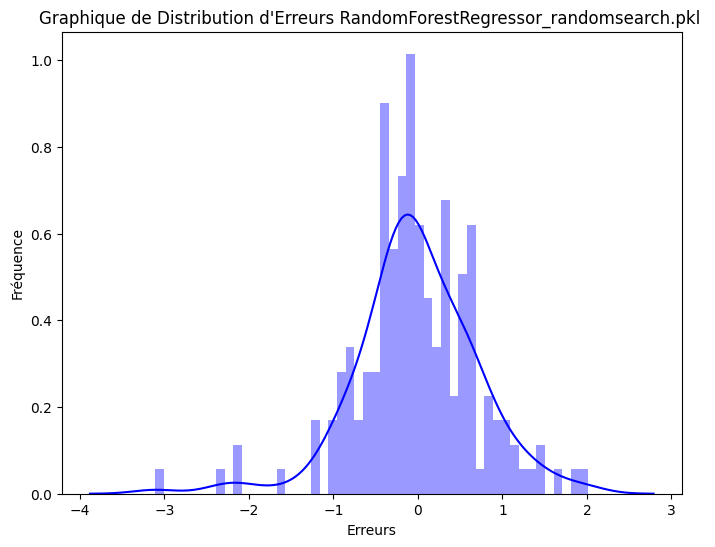

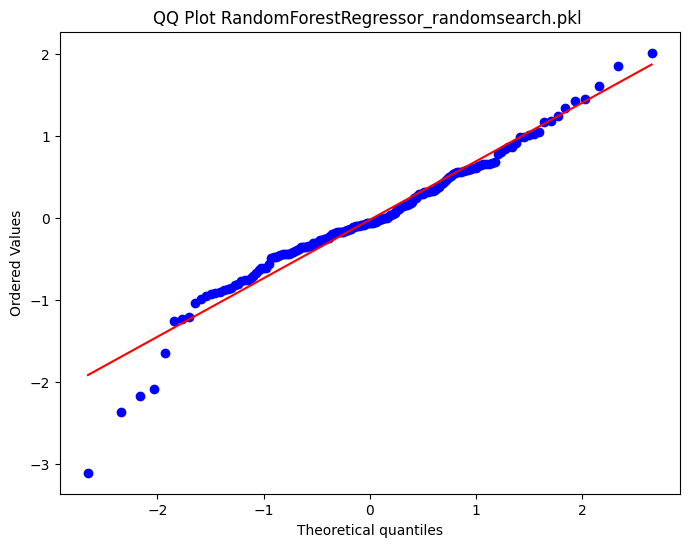

Métrique de performance pour le modèle RandomForestRegressor_standard.pkl :
R²: 0.6657110195589862
RMSE: 0.7307774756606743
MAE: 0.5306736776343007
MSE: 0.5340357189329874


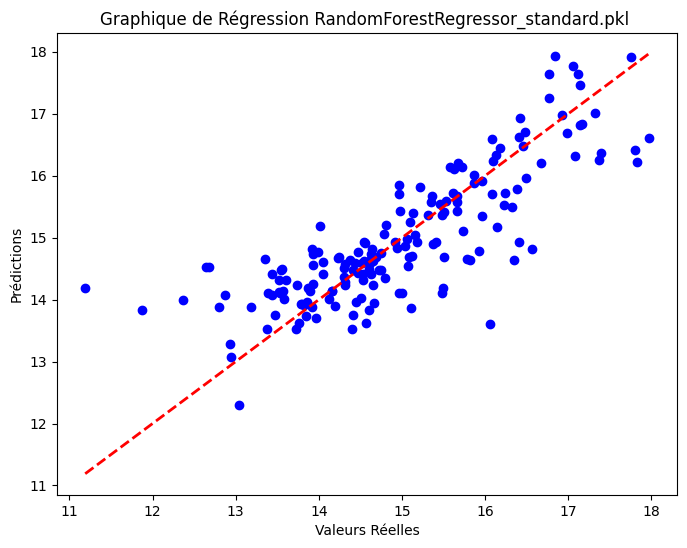

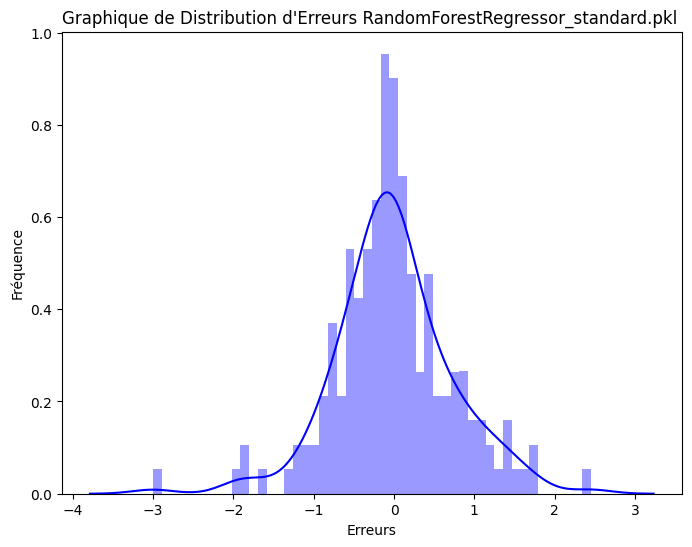

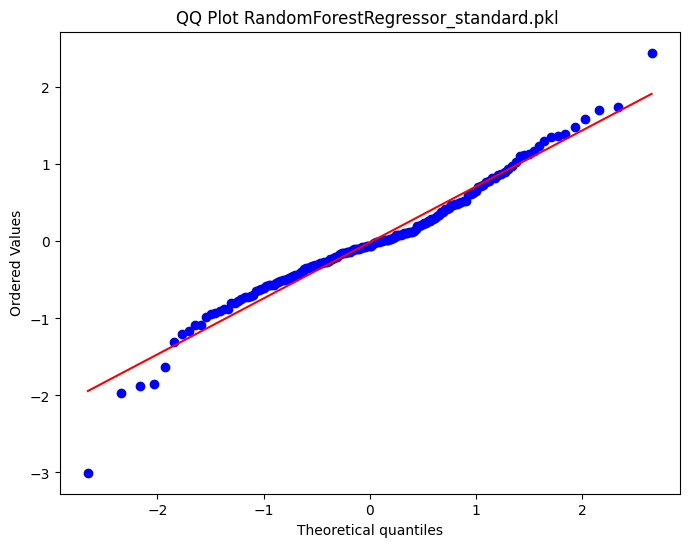

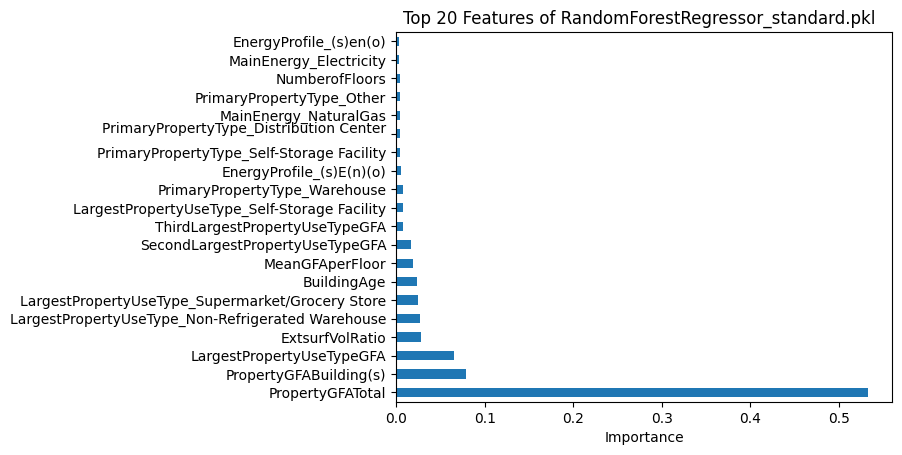

Métrique de performance pour le modèle Ridge_gridsearch.pkl :
R²: 0.054726997638650965
RMSE: 1.2288609669914414
MAE: 0.6998546183610078
MSE: 1.5100992761951406


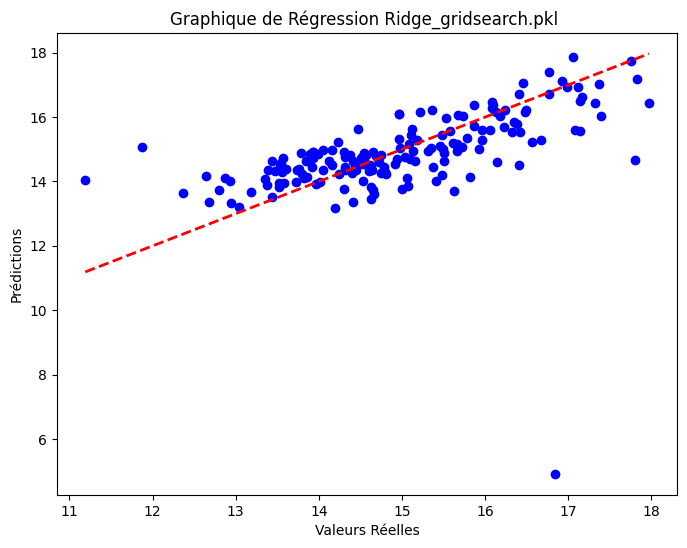

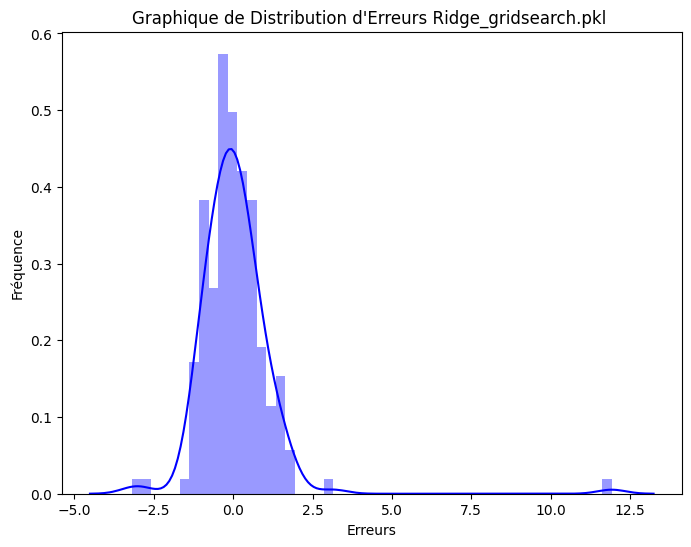

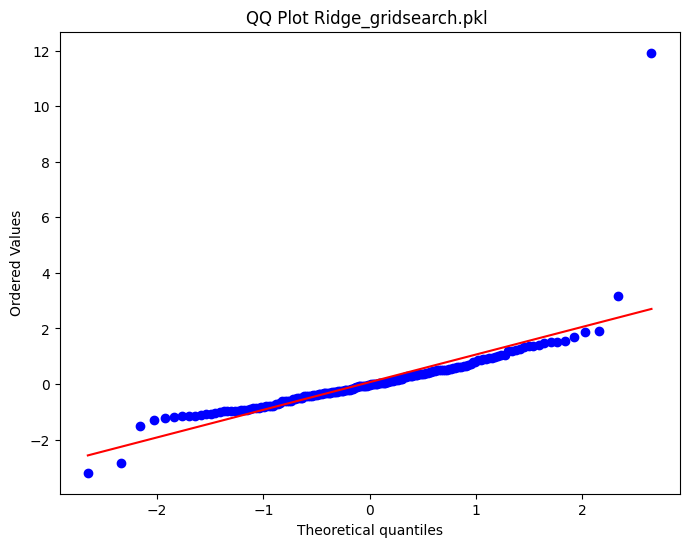

Métrique de performance pour le modèle Ridge_randomsearch.pkl :
R²: 0.054726997638650965
RMSE: 1.2288609669914414
MAE: 0.6998546183610078
MSE: 1.5100992761951406


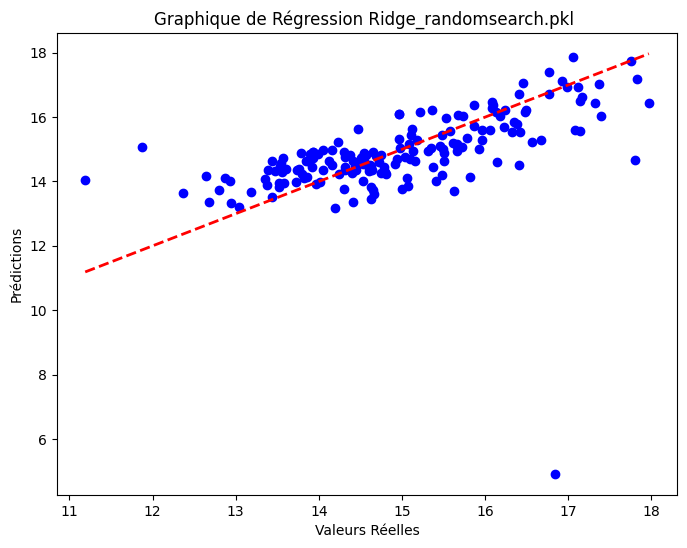

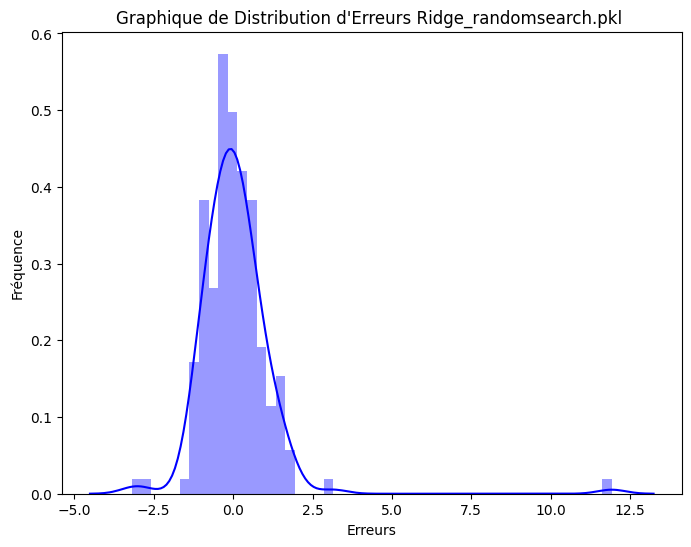

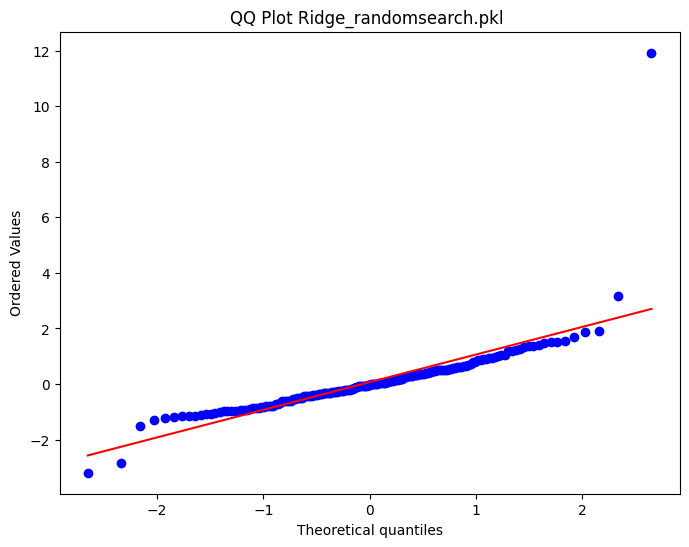

Métrique de performance pour le modèle Ridge_standard.pkl :
R²: 0.054726997638650965
RMSE: 1.2288609669914414
MAE: 0.6998546183610078
MSE: 1.5100992761951406


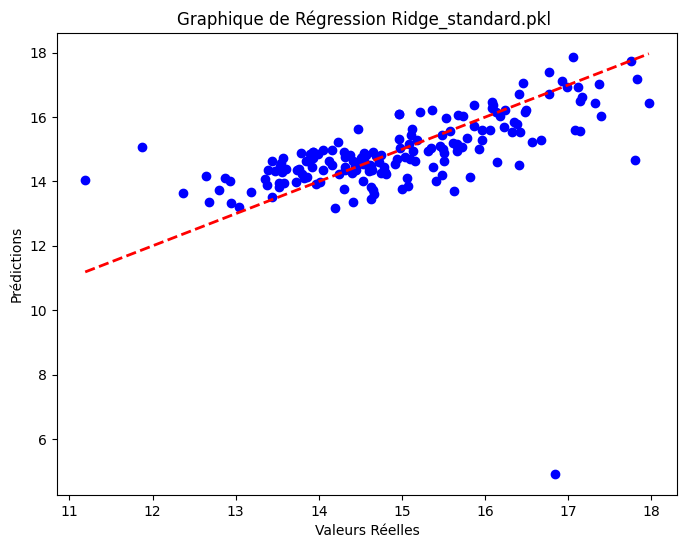

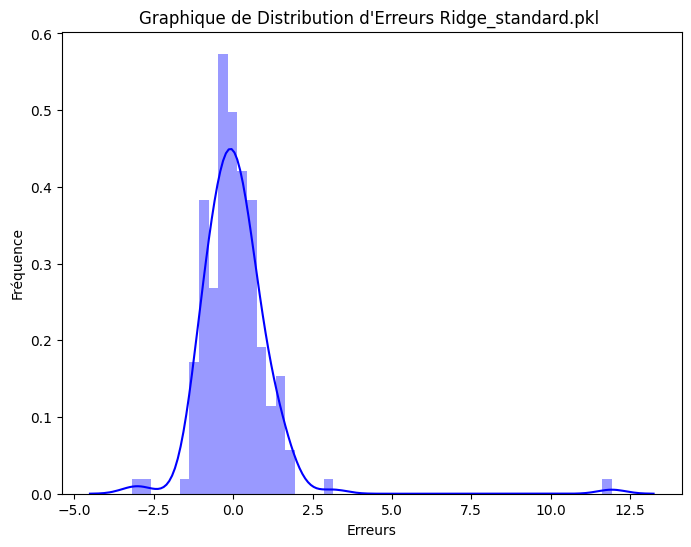

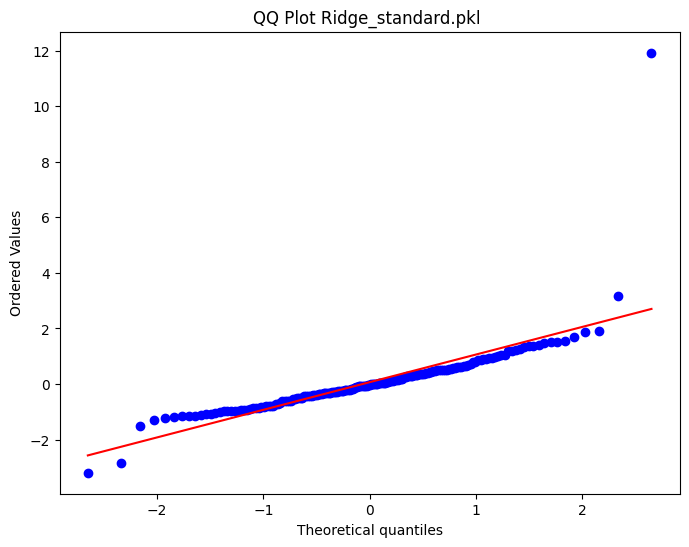

Métrique de performance pour le modèle SVR_gridsearch.pkl :
R²: 0.6710313357427131
RMSE: 0.7249388728954325
MAE: 0.5243797123194119
MSE: 0.5255363694349


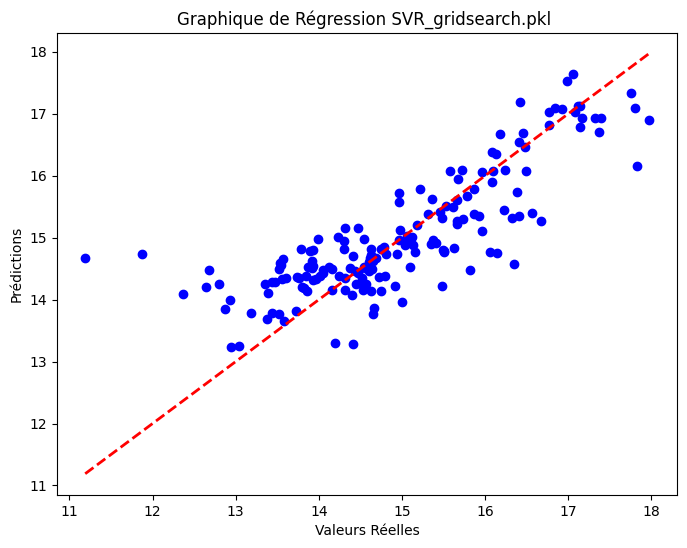

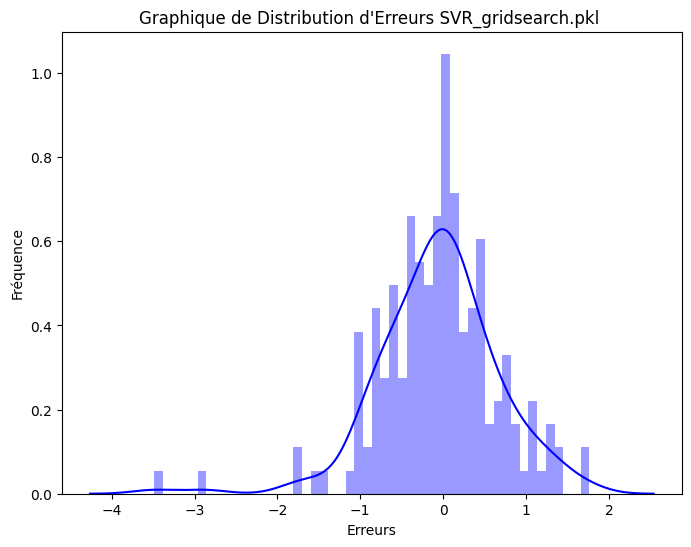

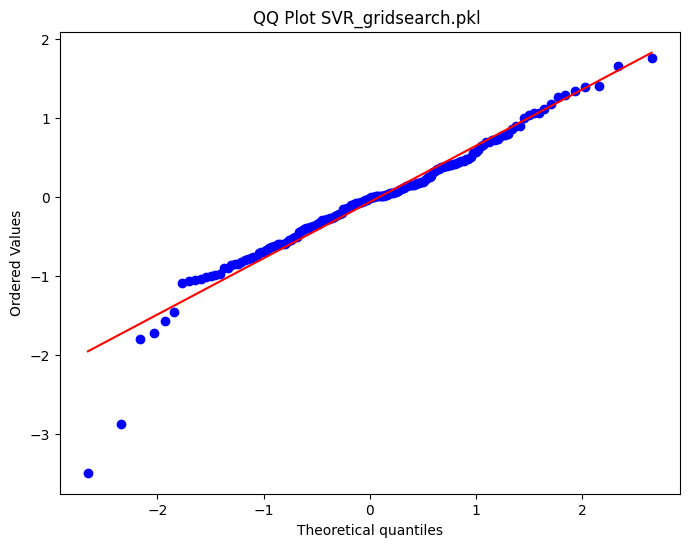

Métrique de performance pour le modèle SVR_randomsearch.pkl :
R²: 0.6710313357427131
RMSE: 0.7249388728954325
MAE: 0.5243797123194119
MSE: 0.5255363694349


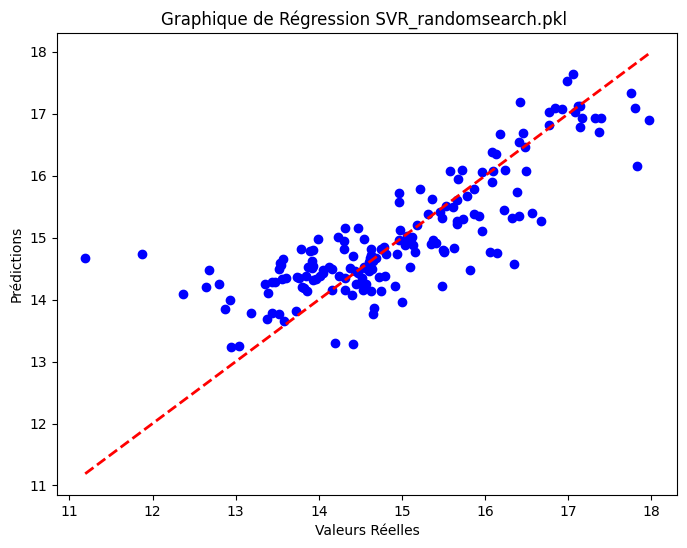

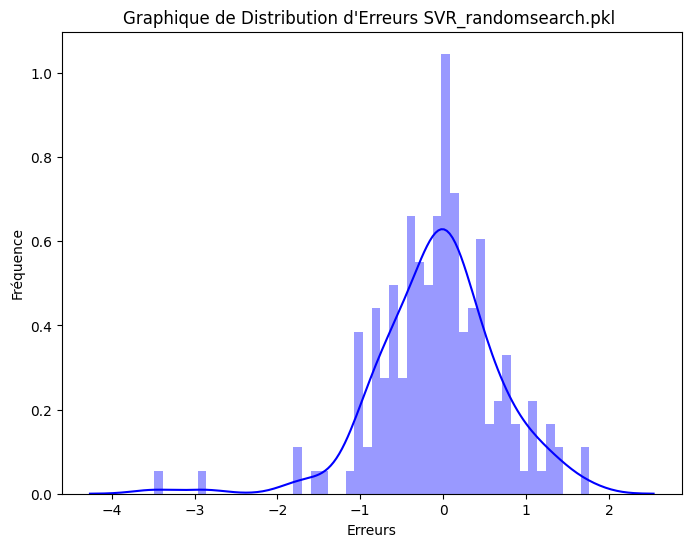

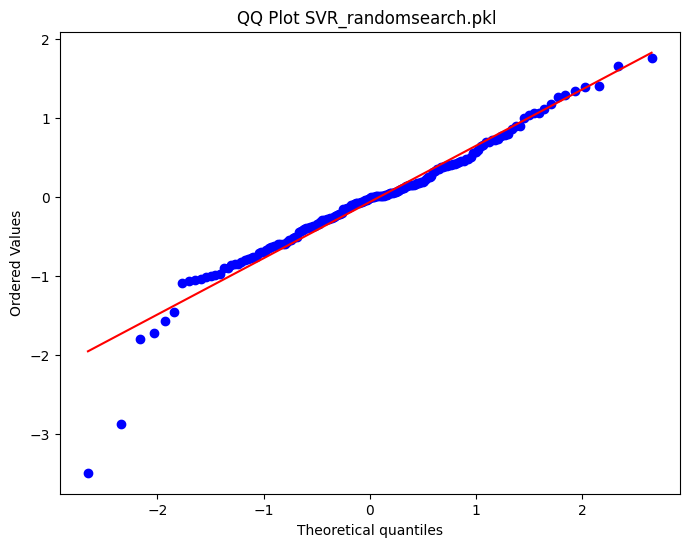

Métrique de performance pour le modèle SVR_standard.pkl :
R²: 0.6710313357427131
RMSE: 0.7249388728954325
MAE: 0.5243797123194119
MSE: 0.5255363694349


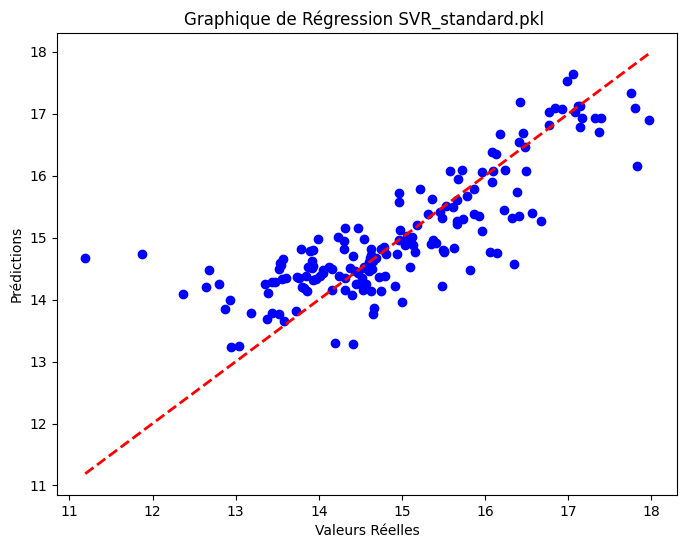

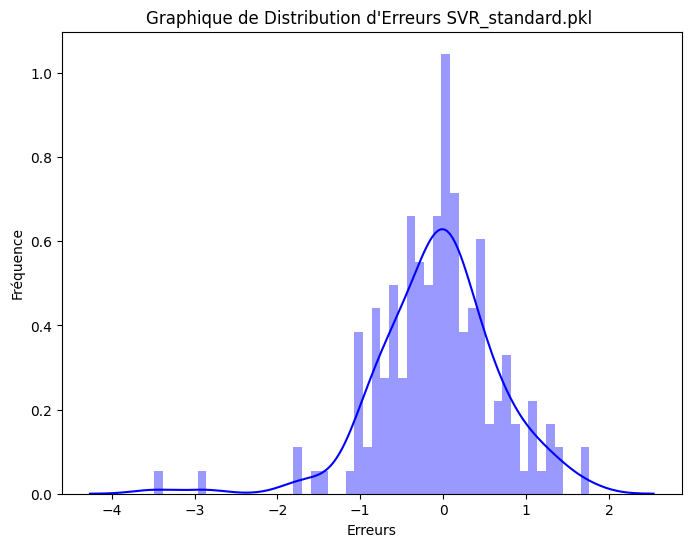

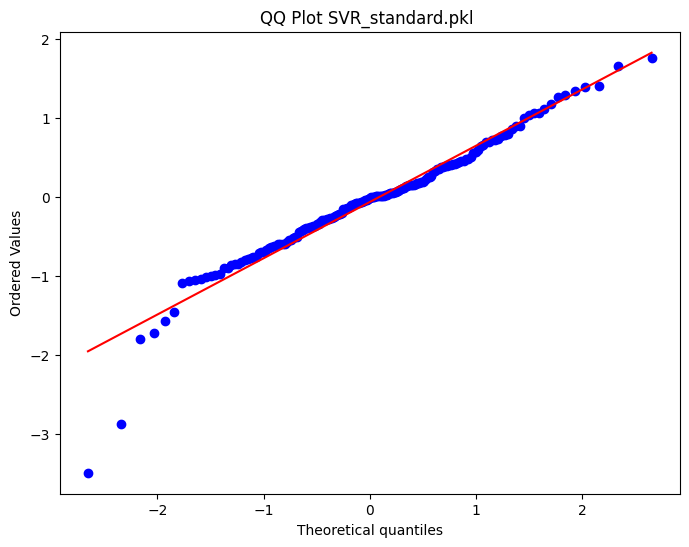

In [12]:
loaded_models = load_and_evaluate_models('../DATA/pickle/SiteEnergyUseWN/withoutlieaires/withoutENERGYSTARScore', X_test, y_test, evaluate_model_performance)



Les méthodes ensemblistes permettent des performances plus intéressantes. Le temps de calcul est aussi plus important, mais la qualité prédictive devient très satisfaisante, avec une erreur quadratique moyenne faible. 



### Recherche de modèles de prédiction pour la consommation d'energie  (SiteEnergyUseWN) with ENERGYSTARScore and with outlieares 

imputer le ENERGYSTARScore 

In [13]:
df.columns[df.isnull().any()].tolist()



['ENERGYSTARScore', 'Comments']

Ajout ENERGYSTARScore dans les Features

In [14]:
prop_Q_cols = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
               'PropertyGFAParking', 'PropertyGFABuilding(s)',
               'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'BuildingAge',
               'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified',
               'ExtsurfVolRatio','ENERGYSTARScore'] # ,


In [15]:
import pandas as pd
from sklearn.impute import KNNImputer

# Supposons que votre DataFrame s'appelle df
# Créez un KNNImputer avec 5 voisins
imputer = KNNImputer(n_neighbors=5)

# Sélectionnez la colonne à imputer
col_to_impute = ['ENERGYSTARScore']

# Imputez les valeurs NaN dans la colonne sélectionnée
df[col_to_impute] = imputer.fit_transform(df[col_to_impute])

# Maintenant, les valeurs NaN dans la colonne 'ENERGYSTARScore' ont été imputées avec la méthode KNN avec 5 voisins les plus proches


In [16]:
df.columns[df.isnull().any()].tolist()

['Comments']

In [17]:
X_train, X_test, y_train, y_test = data_preprocessing2(df,prop_C_cols,prop_Q_cols,'SiteEnergyUseWN(kBtu)_log',0.2)
display(X_test.shape)
compar_results_energy = regressor_compar(X_train, X_test, y_train, y_test, models=mymodels, 
                                         grids=mygrids, foldername='../data/pickle/SiteEnergyUseWN/withoutlieaires/withENERGYSTARScore/')
compar_results_energy

(173, 249)

Comparative table of models…


extratree     dummy                      lr     ridge  \
Standard Time      2.233205     0.001                0.068177  0.009013   
GridSearch Time    3.850488  0.127674                0.439247  0.214278   
RandomSearch Time  5.623482  0.281494                0.821254  0.386892   
Standard R²        0.712392 -0.001628 -16604264107649218560.0   0.00588   
GridSearch R²      0.711686 -0.001628               -0.054355   0.00588   
RandomSearch R²      0.7181 -0.001628               -0.054355   0.00588   
Standard RMSE      0.677836  1.264962       5150316743.215852  1.260211   
GridSearch RMSE    0.678667  1.264962                1.297829  1.260211   
RandomSearch RMSE  0.671076  1.264962                1.297829  1.260211   

                      lasso   elastic       knn       svr       rfr  gradboost  
Standard Time      0.005563  0.006165  0.003998  0.054811  2.394834   0.541046  
GridSearch Time    0.247426  0.255097  0.546556  1.178619  7.744508  12.426505  
RandomSearch Time  0.496161  0.514864  0.896017  1.763886  13.44066  24.416697  
Standard R²       -0.001628  0.180777  0.496408  0.725344  0.704464   0.761717  
GridSearch R²      0.125083  0.151576  0.516306  0.763412  0.701265   0.440325  
RandomSearch R²    0.125083  0.151576  0.516306  0.763412  0.701265   0.440325  
Standard RMSE      1.264962  1.143998   0.89694  0.662397  0.687115    0.61698  
GridSearch RMSE    1.182245  1.164208  0.879041  0.614781  0.690824   0.945567  
RandomSearch RMSE  1.182245  1.164208  0.879041  0.614781  0.690824   0.945567

Métrique de performance pour le modèle DummyRegressor_gridsearch.pkl :
R²: -0.0016278839185353
RMSE: 1.2649615523670927
MAE: 1.0266172457974527
MSE: 1.6001277289669653


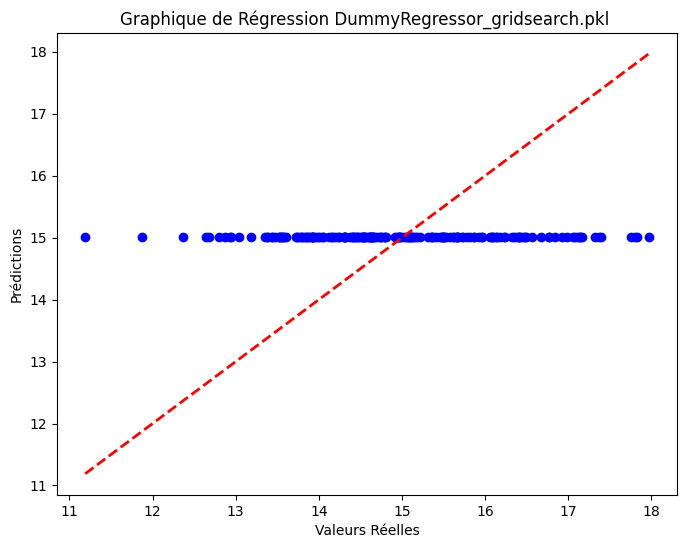

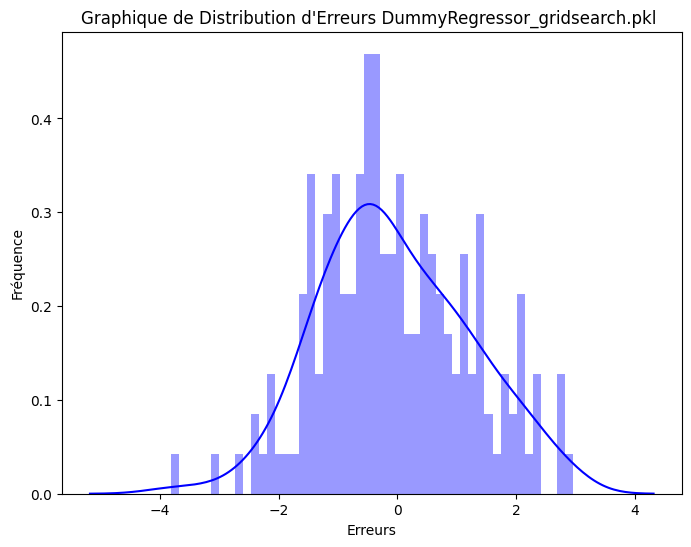

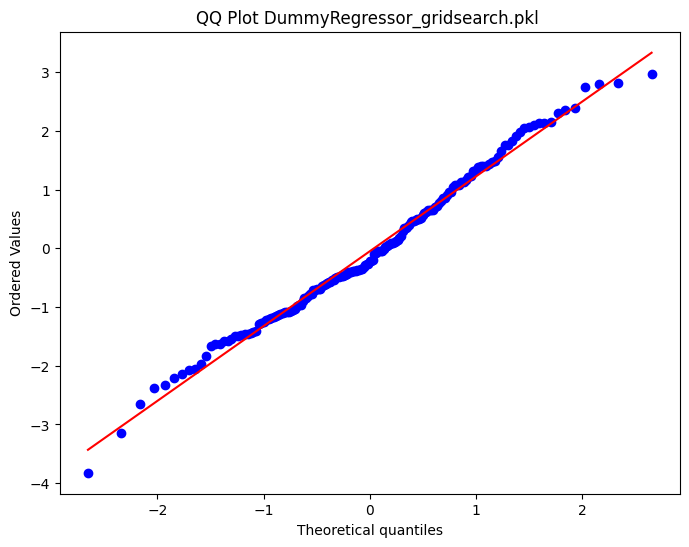

Métrique de performance pour le modèle DummyRegressor_randomsearch.pkl :
R²: -0.0016278839185353
RMSE: 1.2649615523670927
MAE: 1.0266172457974527
MSE: 1.6001277289669653


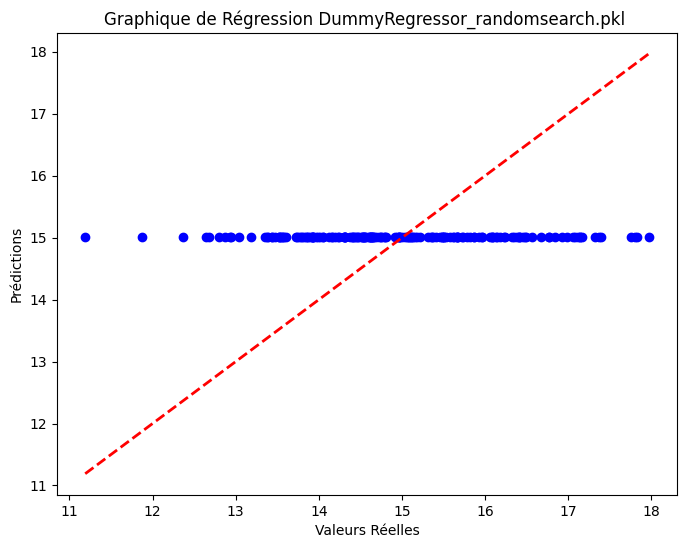

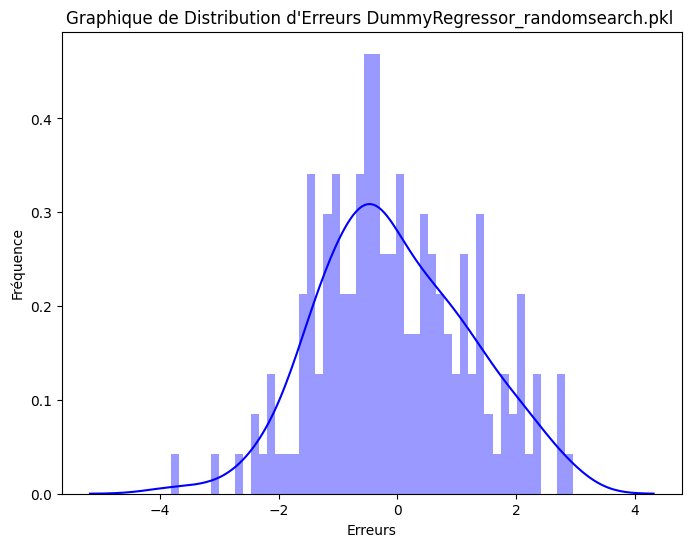

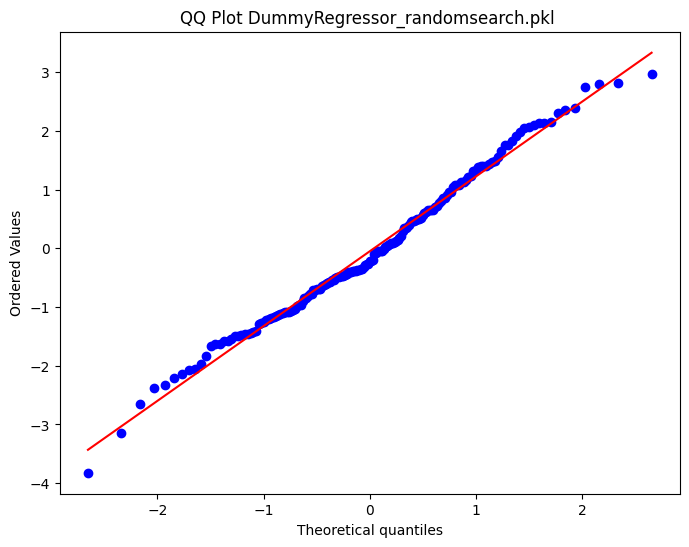

Métrique de performance pour le modèle DummyRegressor_standard.pkl :
R²: -0.0016278839185353
RMSE: 1.2649615523670927
MAE: 1.0266172457974527
MSE: 1.6001277289669653


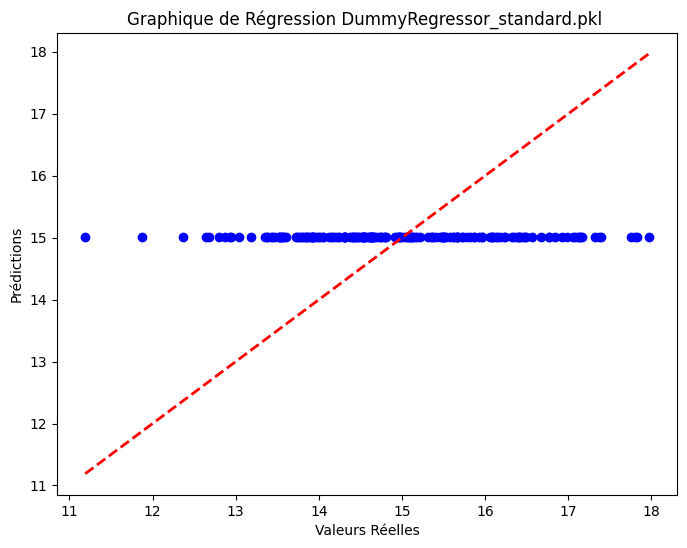

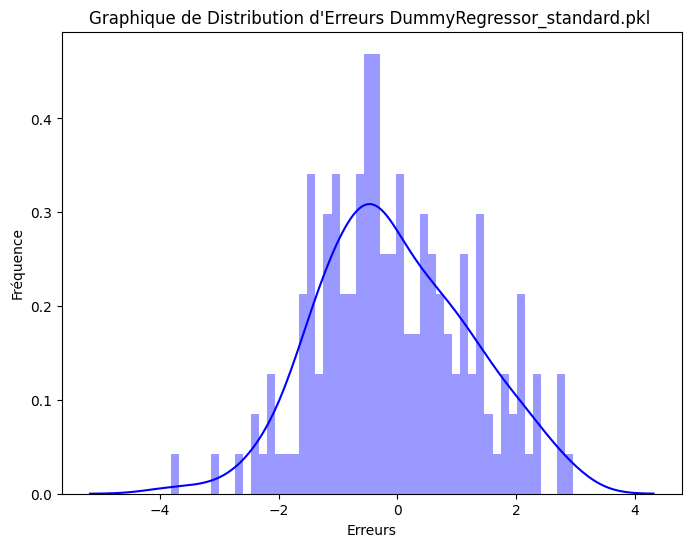

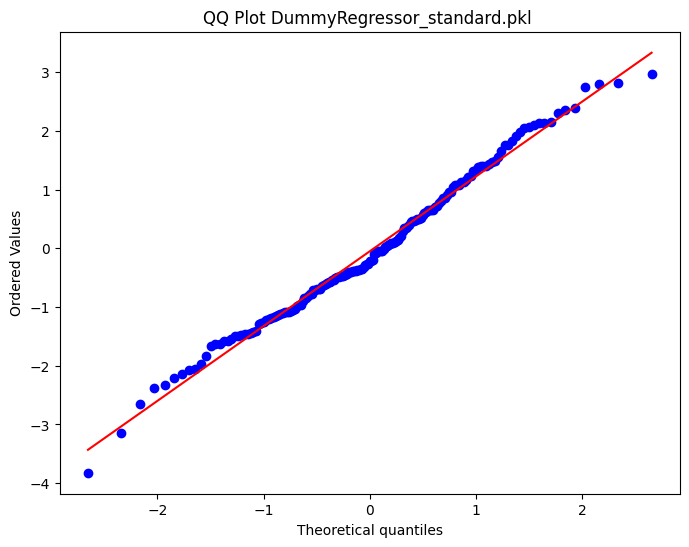

Métrique de performance pour le modèle ElasticNet_gridsearch.pkl :
R²: 0.15157604972184324
RMSE: 1.1642080084706008
MAE: 0.6476418492659805
MSE: 1.3553802869870826


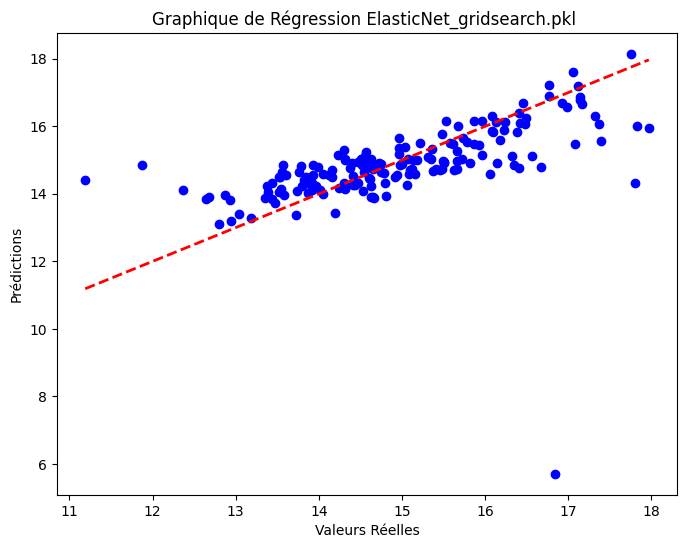

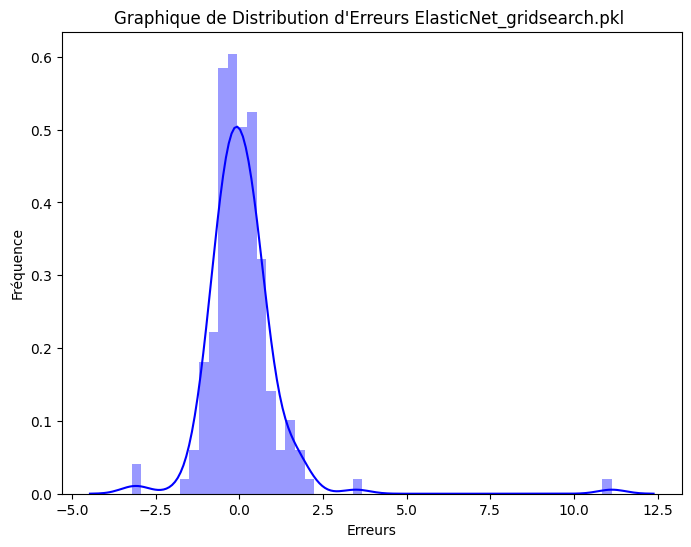

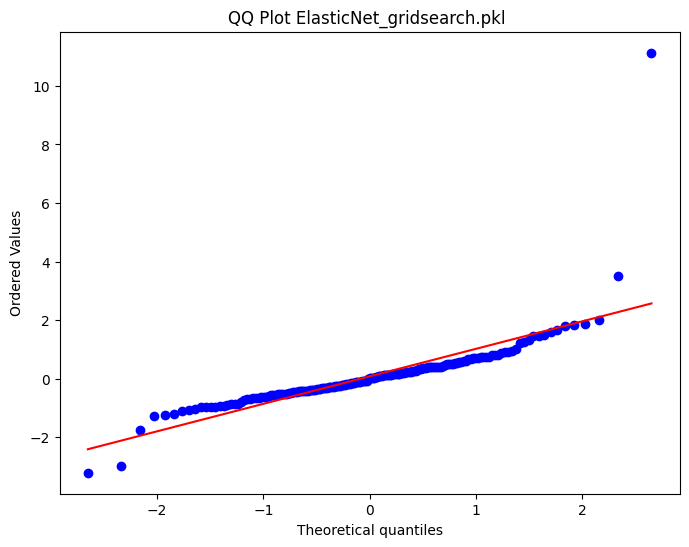

Métrique de performance pour le modèle ElasticNet_randomsearch.pkl :
R²: 0.15157604972184324
RMSE: 1.1642080084706008
MAE: 0.6476418492659805
MSE: 1.3553802869870826


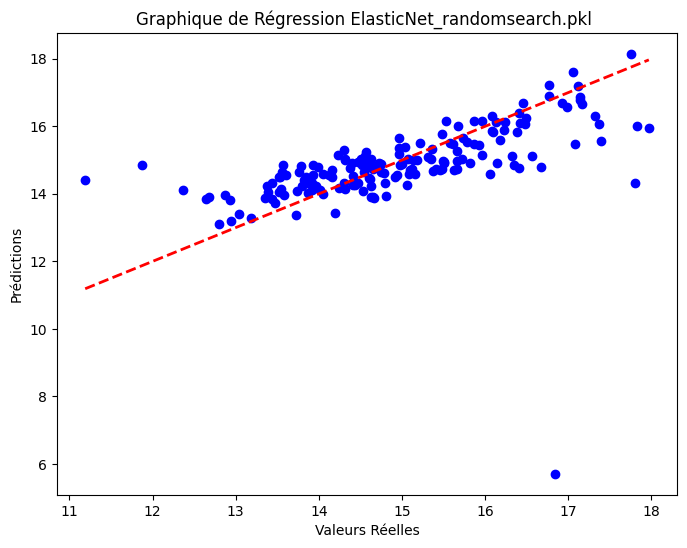

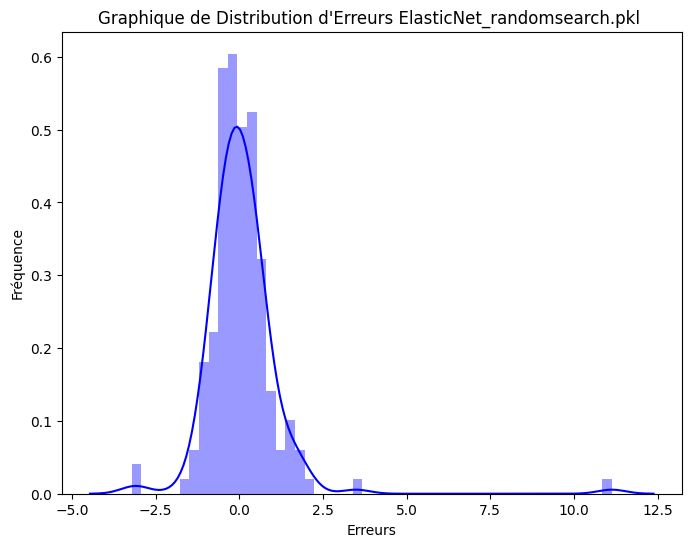

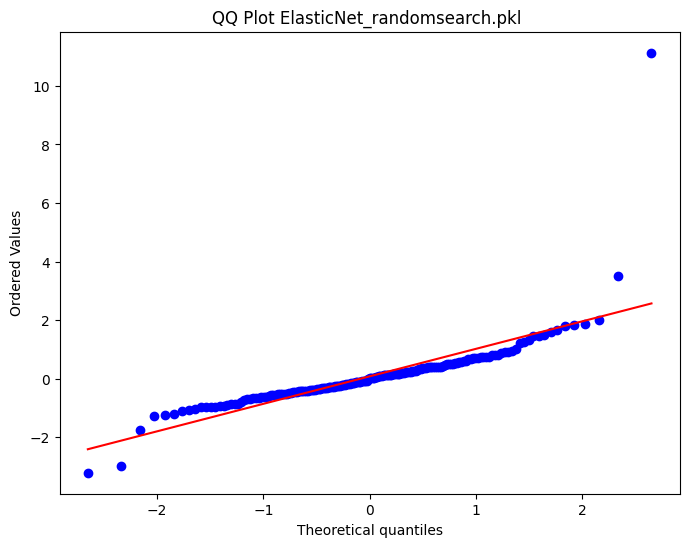

Métrique de performance pour le modèle ElasticNet_standard.pkl :
R²: 0.18077715489058732
RMSE: 1.1439976962194554
MAE: 0.9282610624235185
MSE: 1.308730728955421


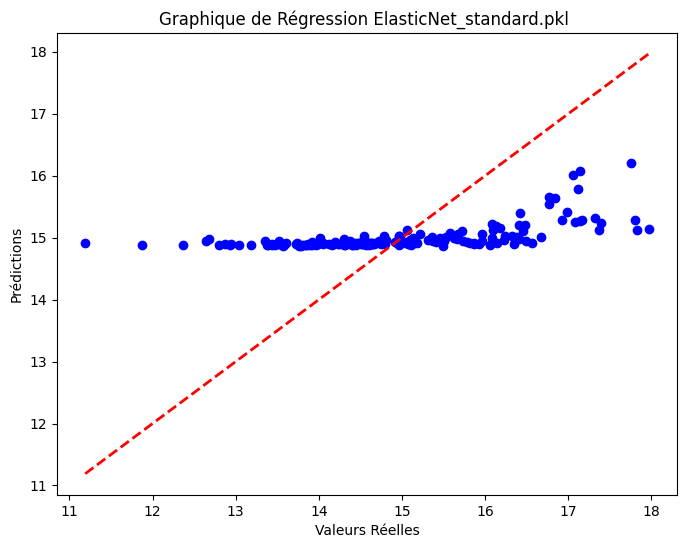

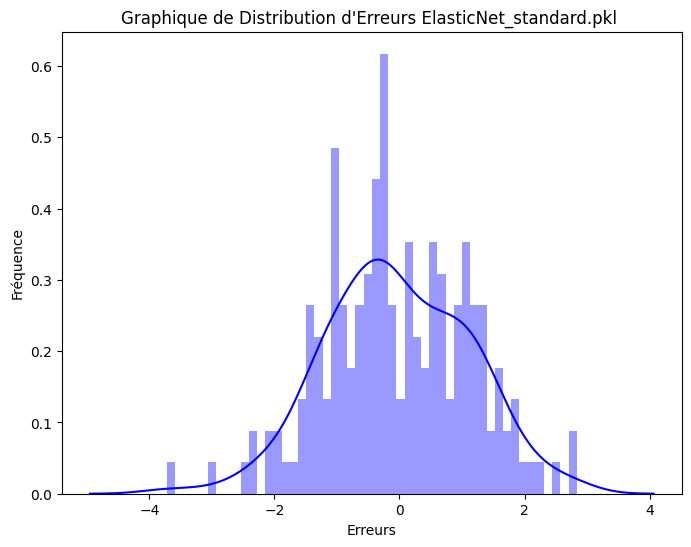

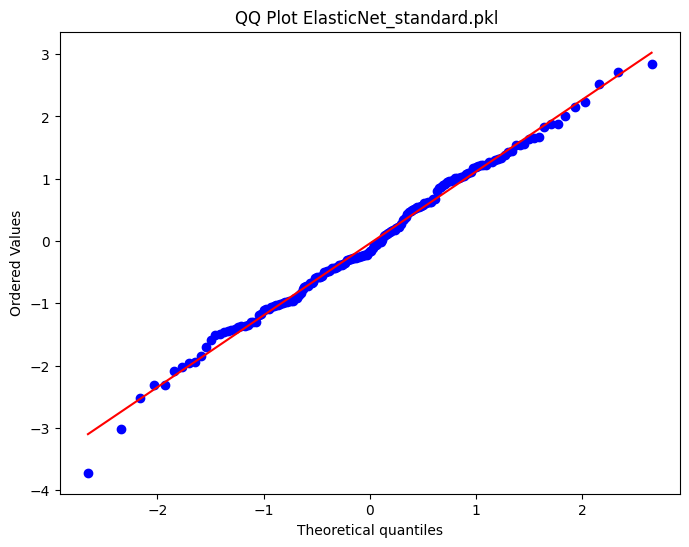

Métrique de performance pour le modèle ExtraTreesRegressor_gridsearch.pkl :
R²: 0.7116863914806887
RMSE: 0.6786669393053448
MAE: 0.4781018604771332
MSE: 0.46058881450608463


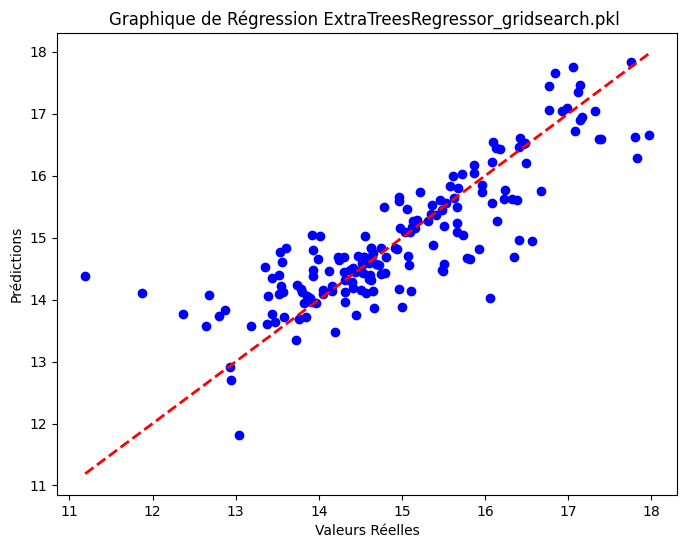

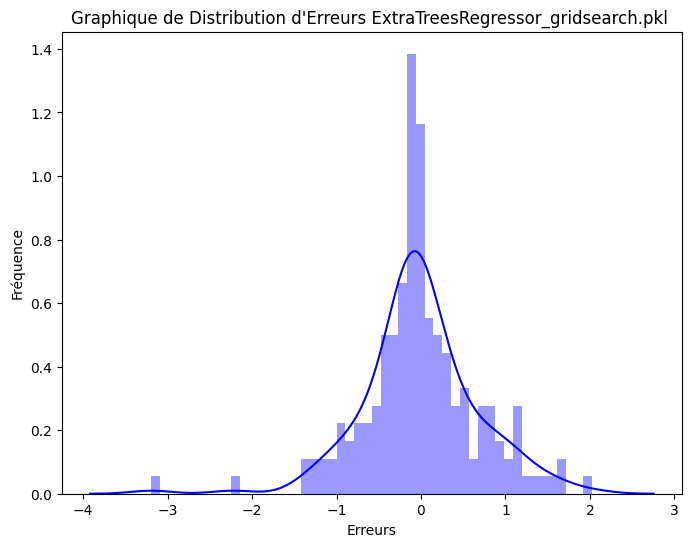

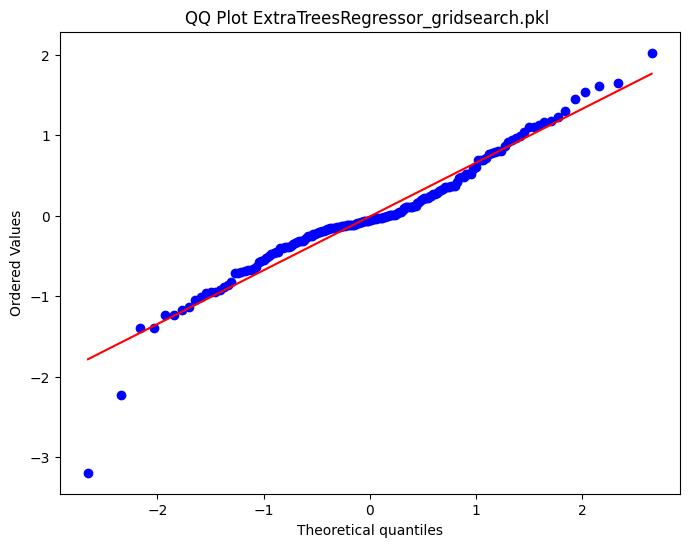

Métrique de performance pour le modèle ExtraTreesRegressor_randomsearch.pkl :
R²: 0.7181002845545492
RMSE: 0.671075589070326
MAE: 0.4673876569258172
MSE: 0.45034244624608505


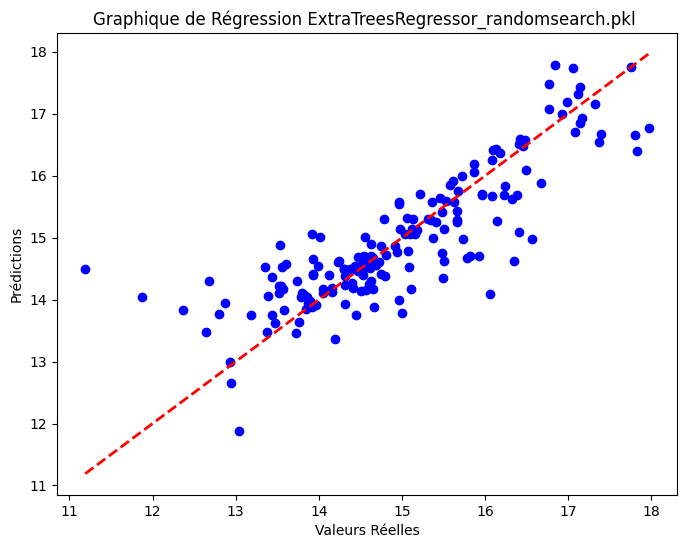

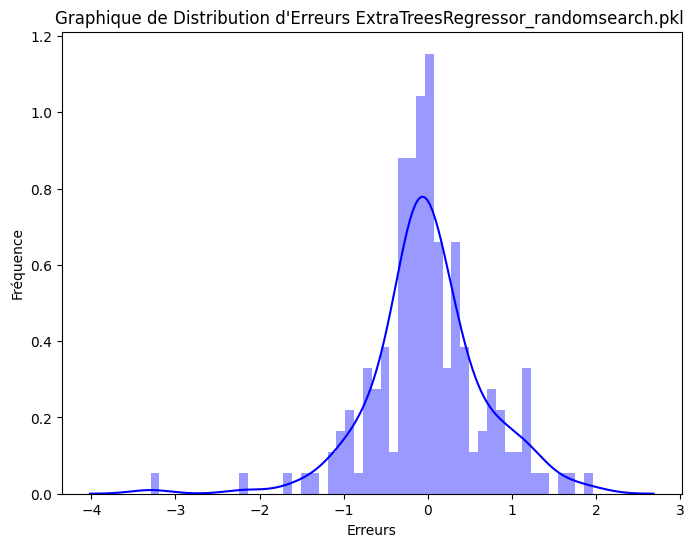

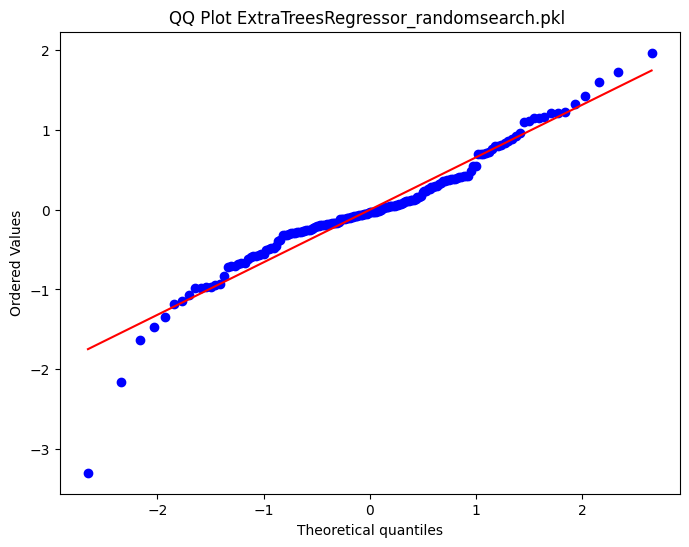

Métrique de performance pour le modèle ExtraTreesRegressor_standard.pkl :
R²: 0.7123920078201949
RMSE: 0.6778359486285281
MAE: 0.4783109720890425
MSE: 0.4594615732531366


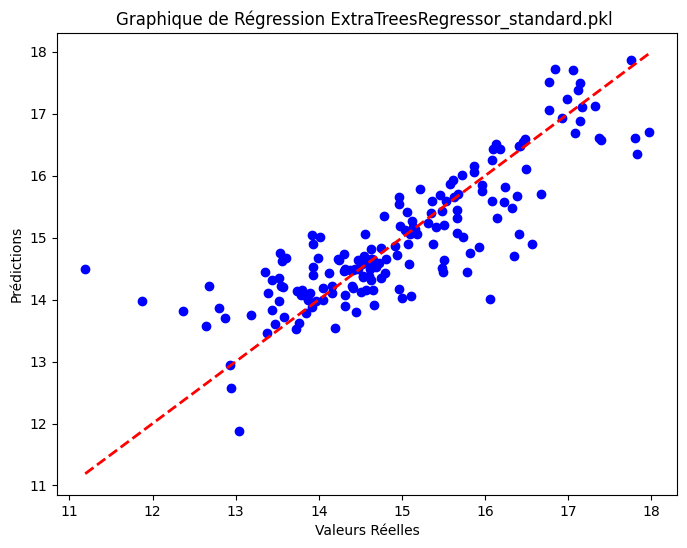

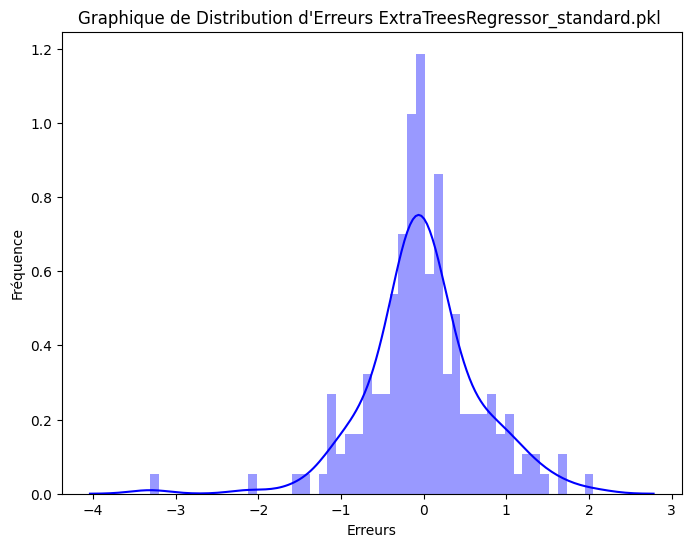

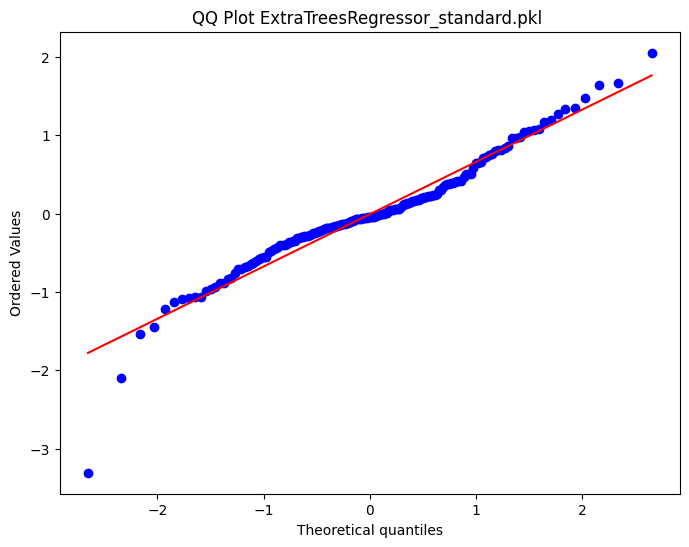

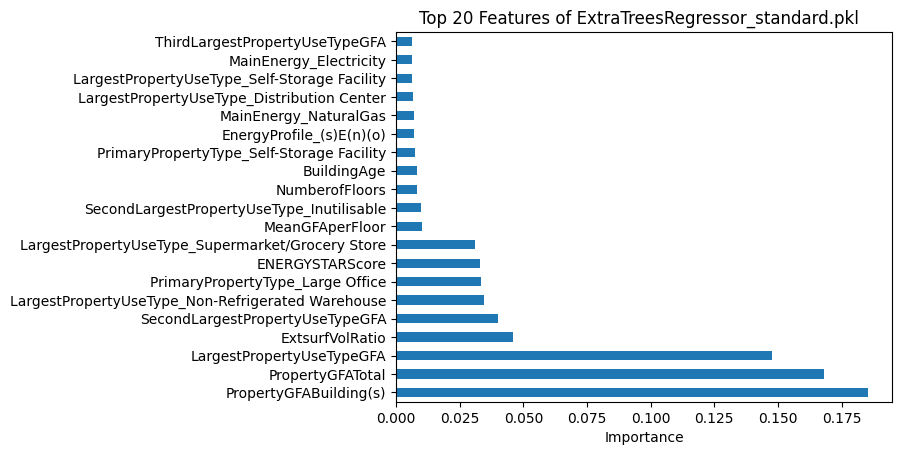

Métrique de performance pour le modèle GradientBoostingRegressor_gridsearch.pkl :
R²: 0.44032482558762376
RMSE: 0.9455666453690471
MAE: 0.7089668071706479
MSE: 0.8940962808344732


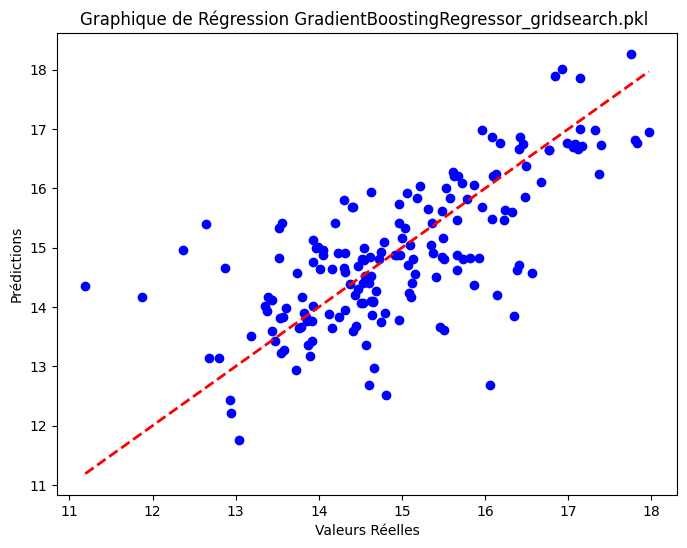

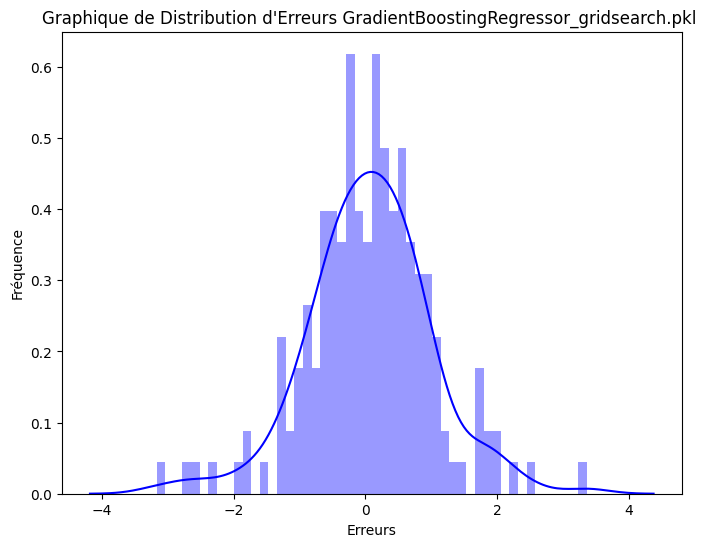

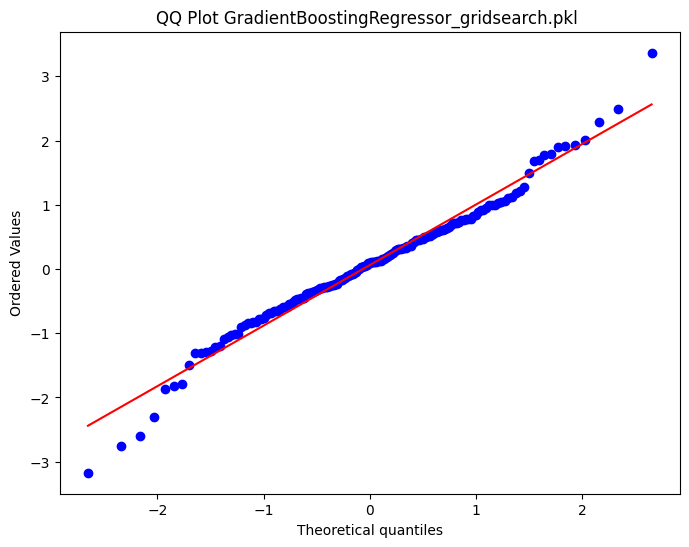

Métrique de performance pour le modèle GradientBoostingRegressor_randomsearch.pkl :
R²: 0.44032482558762376
RMSE: 0.9455666453690471
MAE: 0.7089668071706479
MSE: 0.8940962808344732


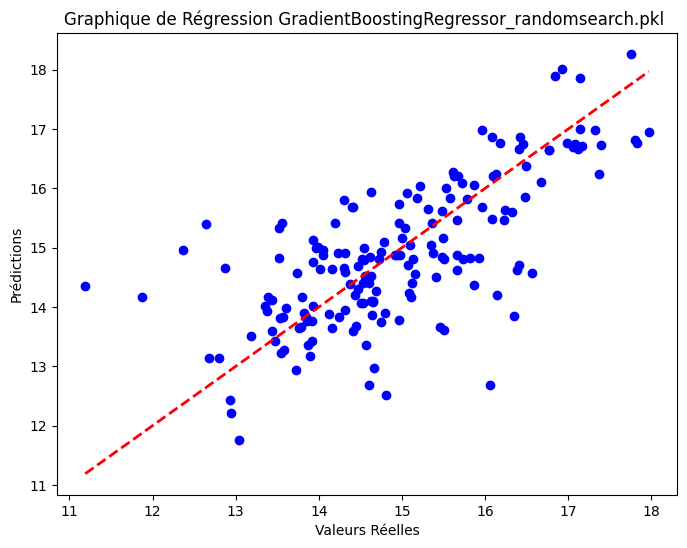

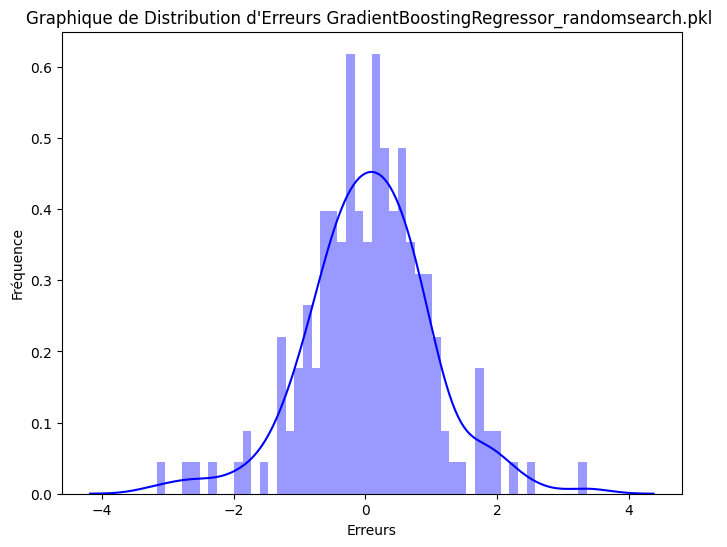

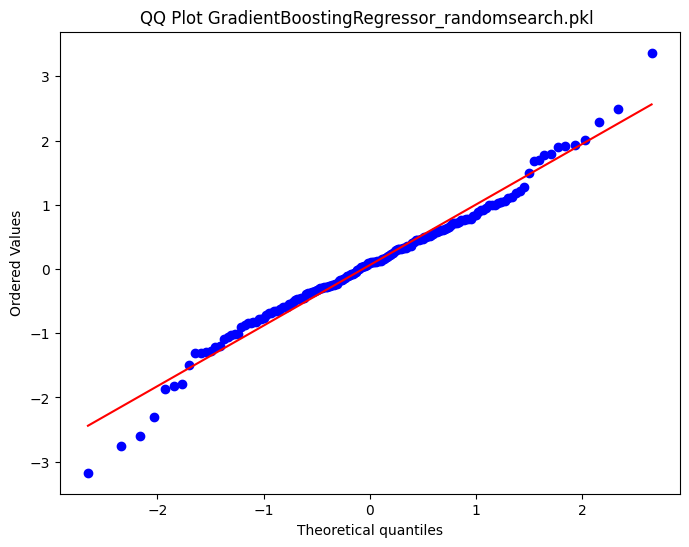

Métrique de performance pour le modèle GradientBoostingRegressor_standard.pkl :
R²: 0.7617168637164817
RMSE: 0.6169795598486901
MAE: 0.44798326144675693
MSE: 0.38066377727108347


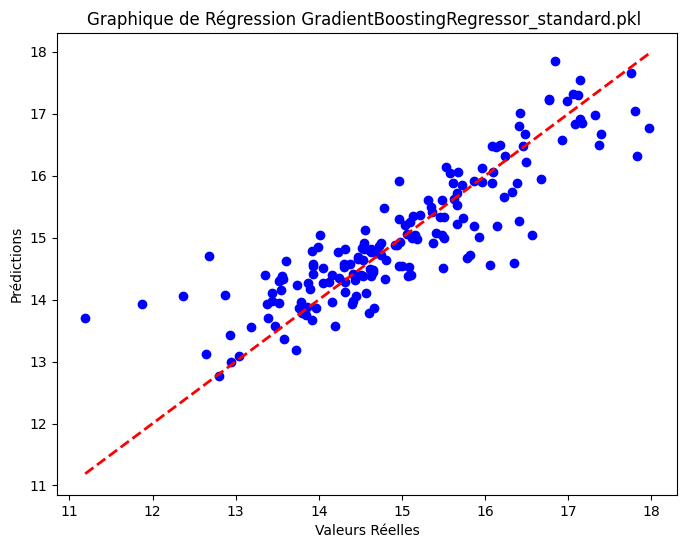

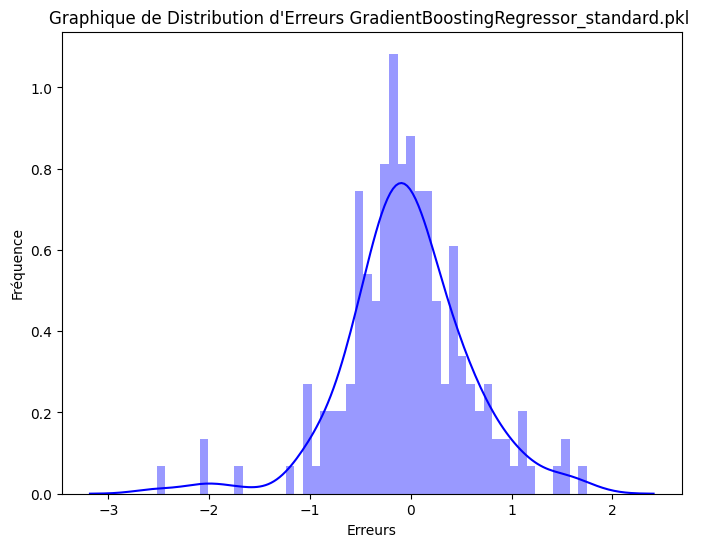

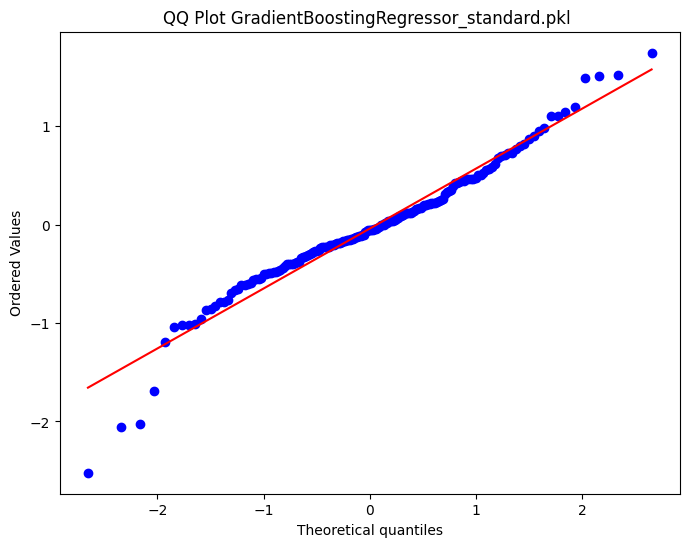

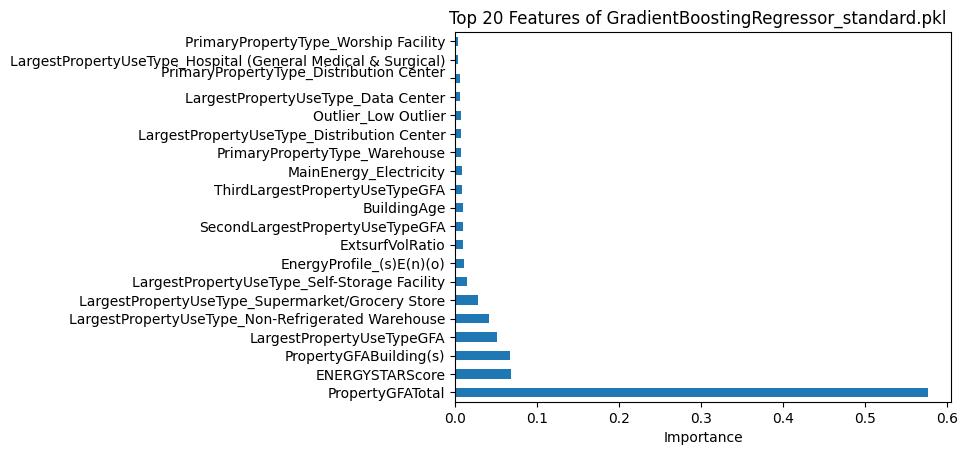

Métrique de performance pour le modèle KNeighborsRegressor_gridsearch.pkl :
R²: 0.5163064588301178
RMSE: 0.8790412729621364
MAE: 0.6602879426512684
MSE: 0.7727135595708933


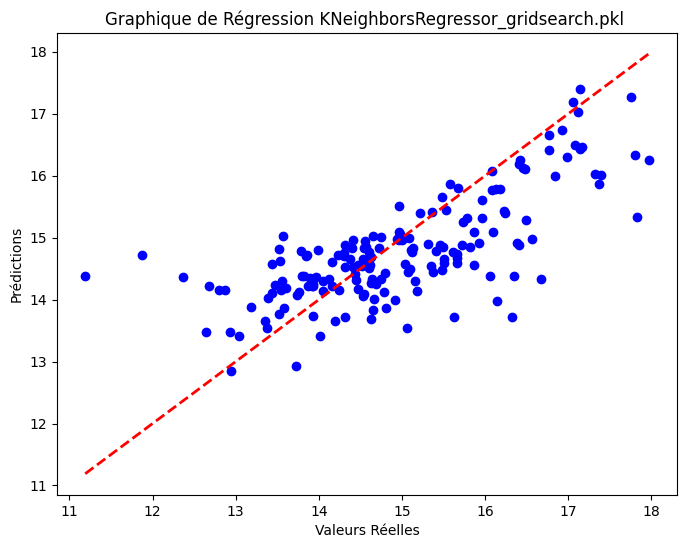

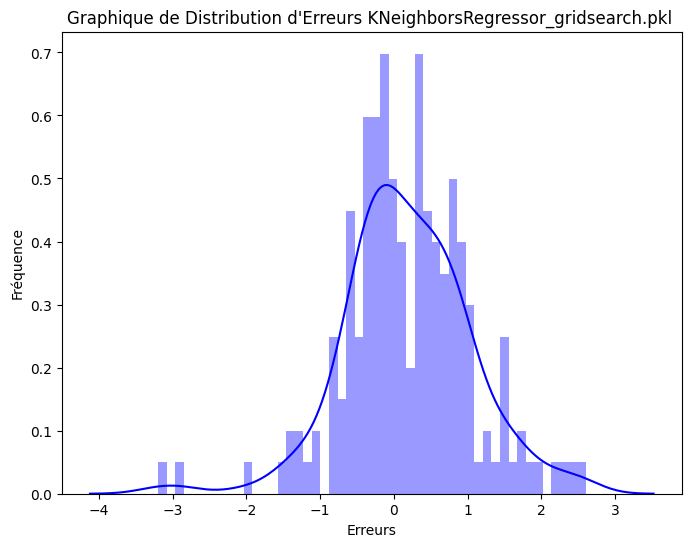

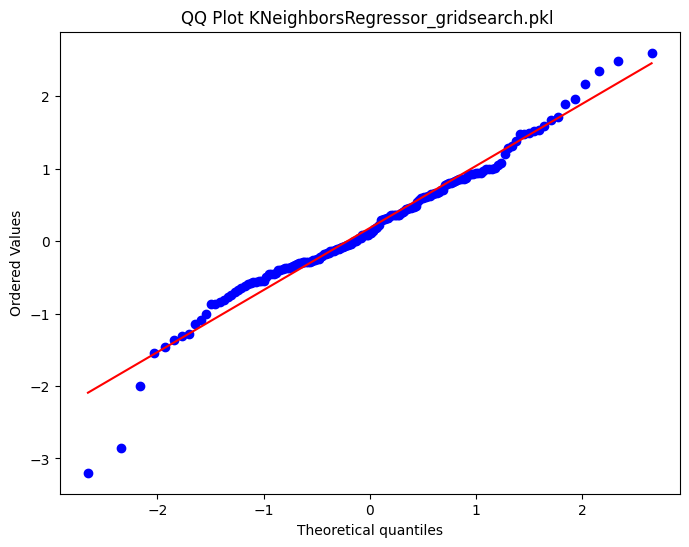

Métrique de performance pour le modèle KNeighborsRegressor_randomsearch.pkl :
R²: 0.5163064588301178
RMSE: 0.8790412729621364
MAE: 0.6602879426512684
MSE: 0.7727135595708933


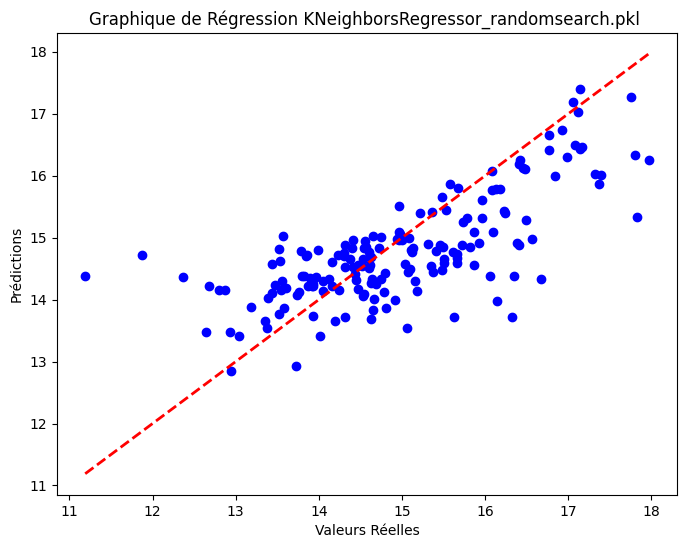

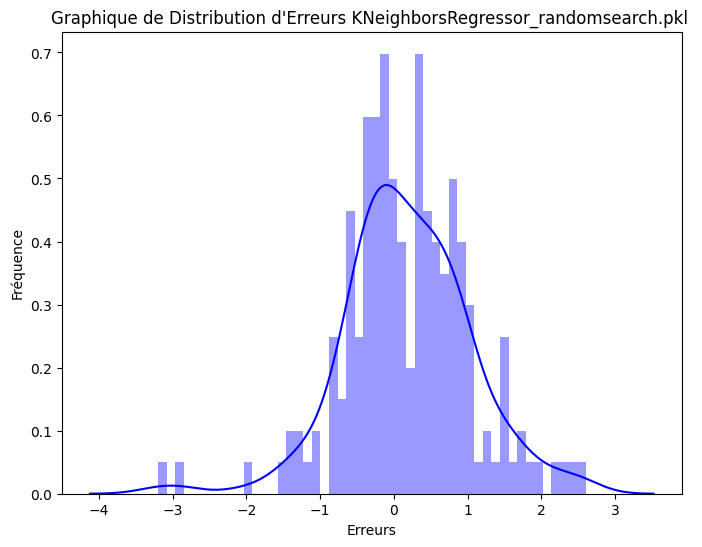

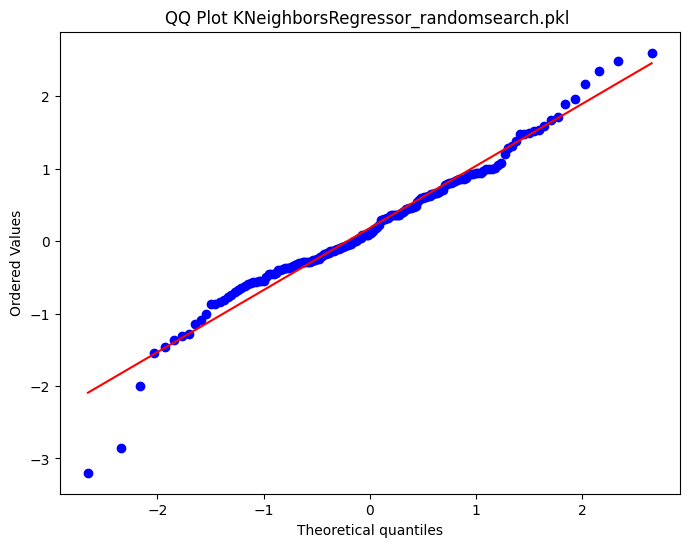

Métrique de performance pour le modèle KNeighborsRegressor_standard.pkl :
R²: 0.49640802591512156
RMSE: 0.8969402690260738
MAE: 0.6721350921982202
MSE: 0.8045018462005656


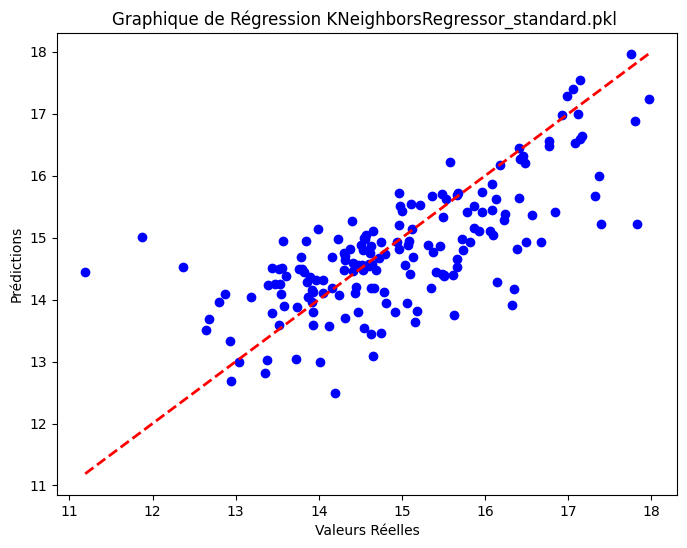

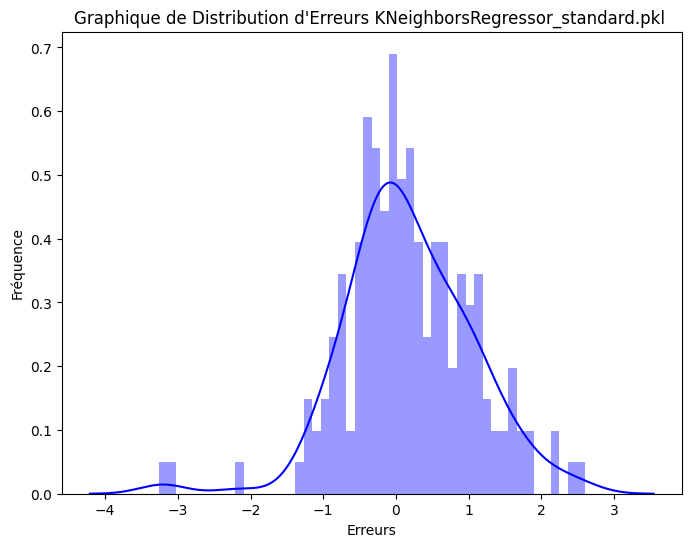

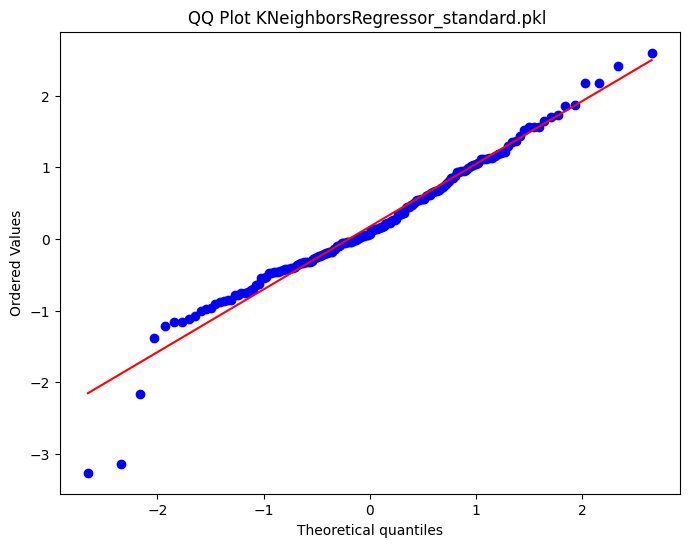

Métrique de performance pour le modèle Lasso_gridsearch.pkl :
R²: 0.12508317491673893
RMSE: 1.1822450564543907
MAE: 0.6570212929896293
MSE: 1.3977033735108455


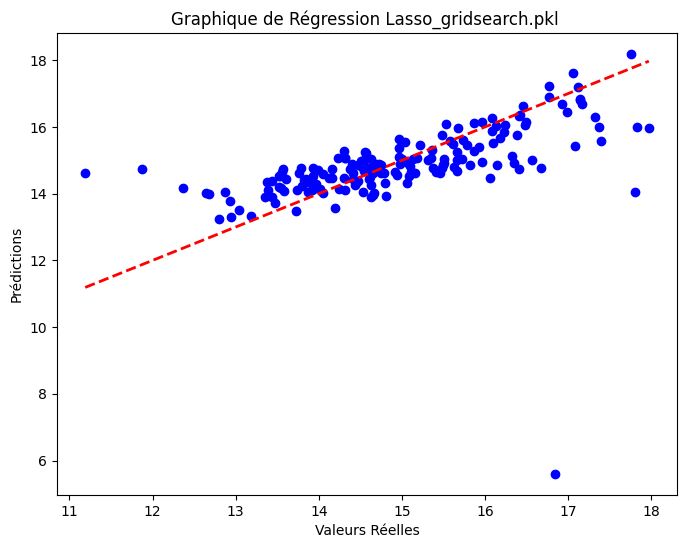

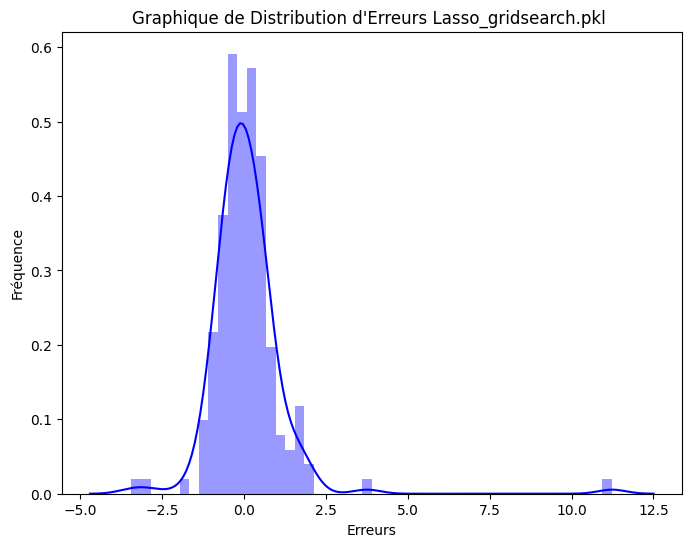

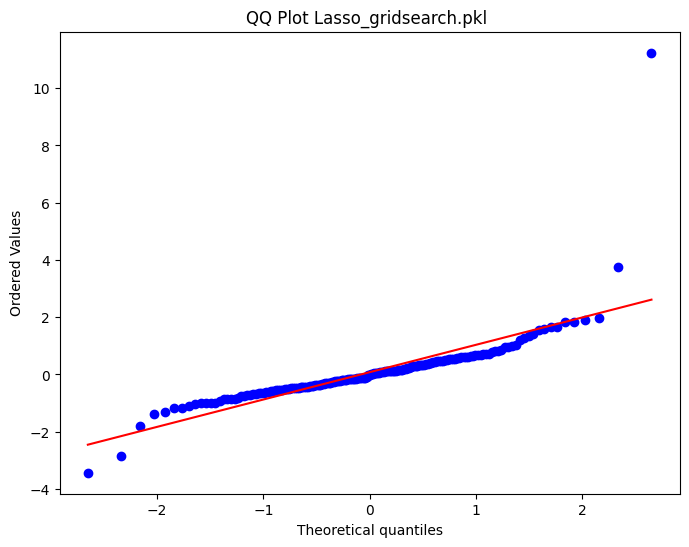

Métrique de performance pour le modèle Lasso_randomsearch.pkl :
R²: 0.12508317491673893
RMSE: 1.1822450564543907
MAE: 0.6570212929896293
MSE: 1.3977033735108455


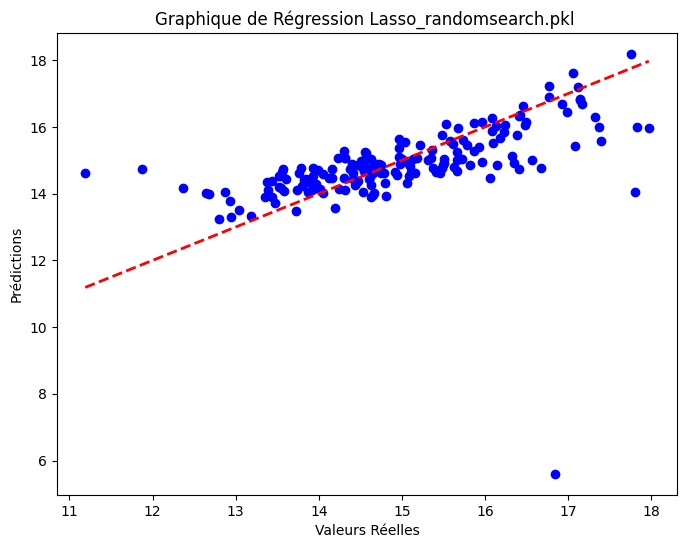

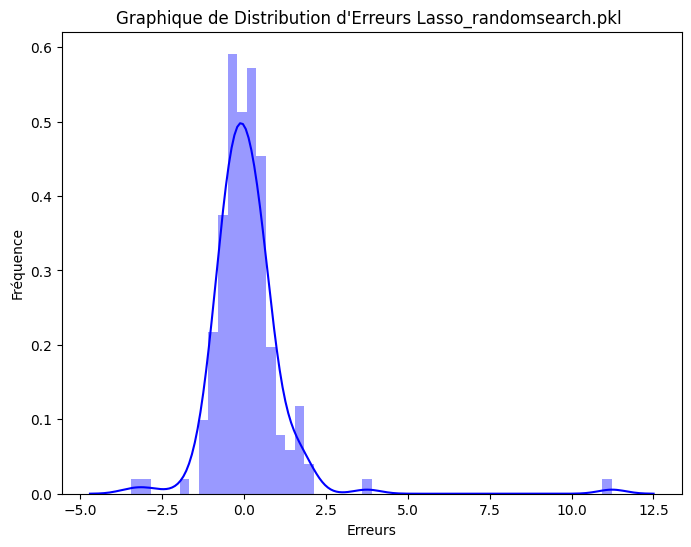

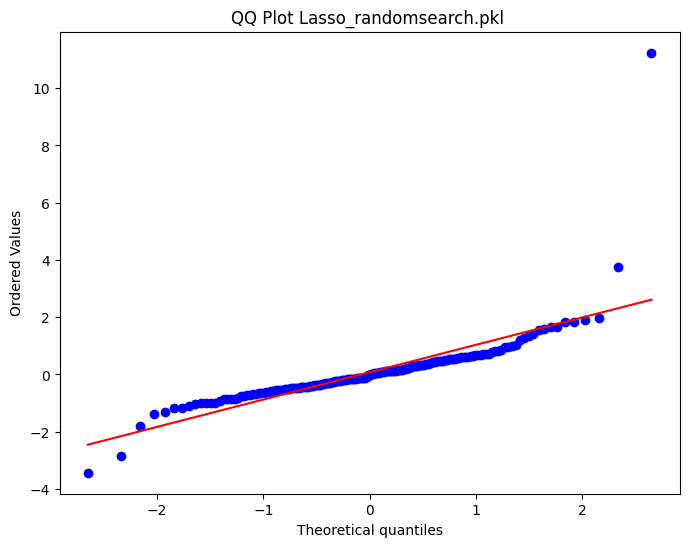

Métrique de performance pour le modèle Lasso_standard.pkl :
R²: -0.0016278839185353
RMSE: 1.2649615523670927
MAE: 1.0266172457974527
MSE: 1.6001277289669653


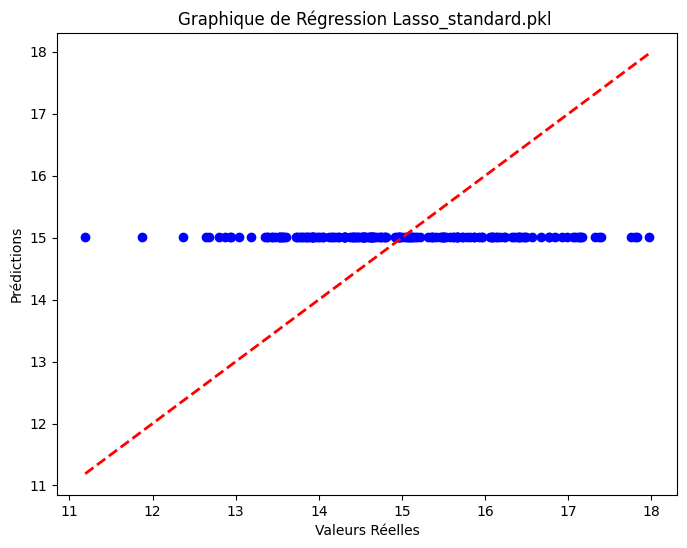

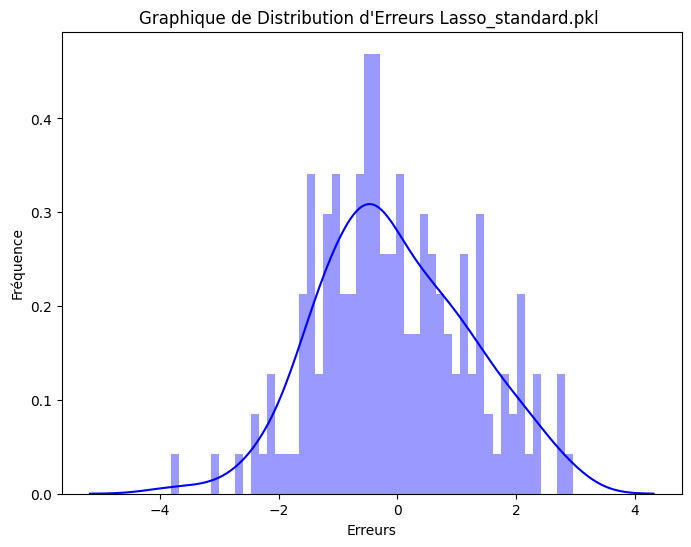

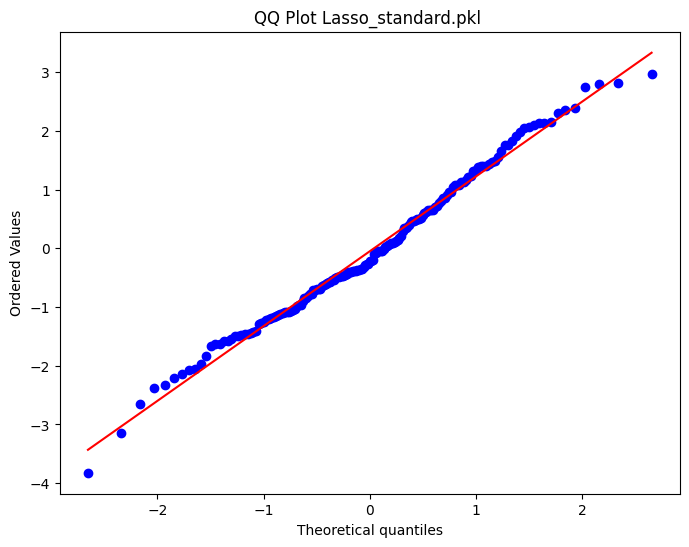

Métrique de performance pour le modèle LinearRegression_gridsearch.pkl :
R²: -0.05435478870883115
RMSE: 1.2978291067739134
MAE: 0.9214729263925598
MSE: 1.6843603903895736


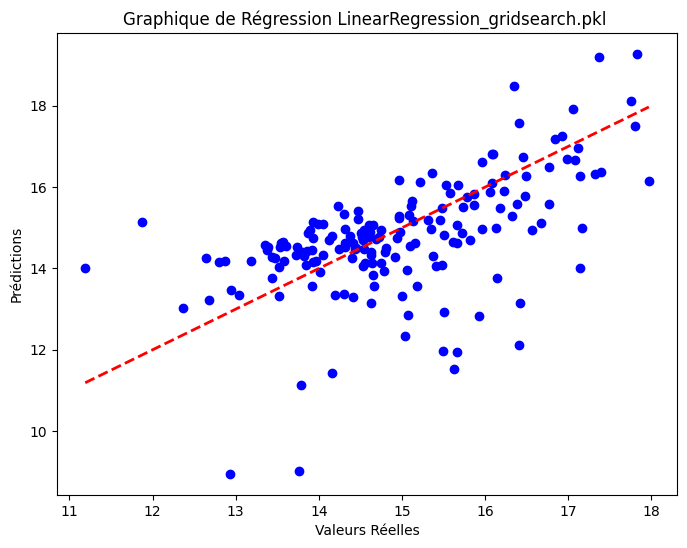

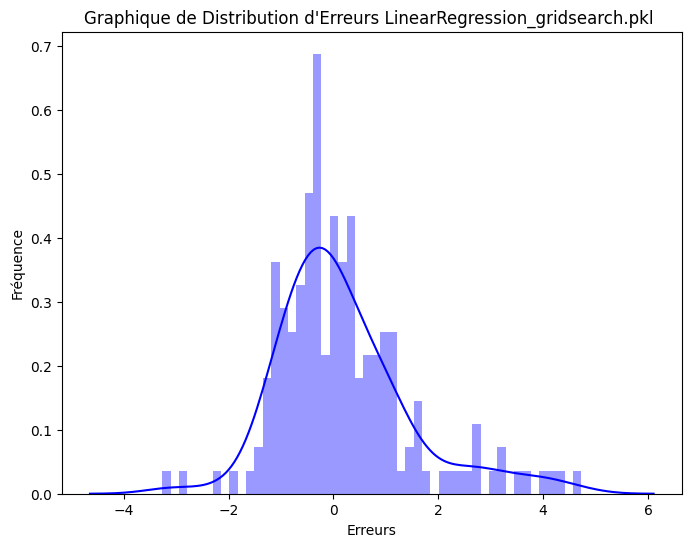

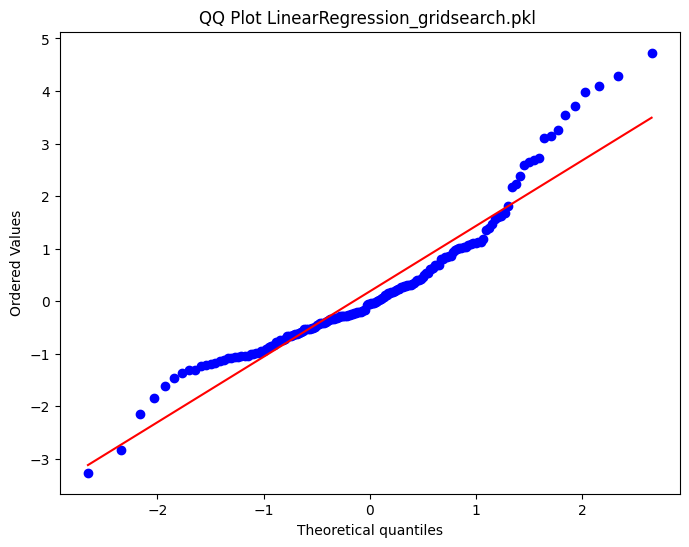

Métrique de performance pour le modèle LinearRegression_randomsearch.pkl :
R²: -0.05435478870883115
RMSE: 1.2978291067739134
MAE: 0.9214729263925598
MSE: 1.6843603903895736


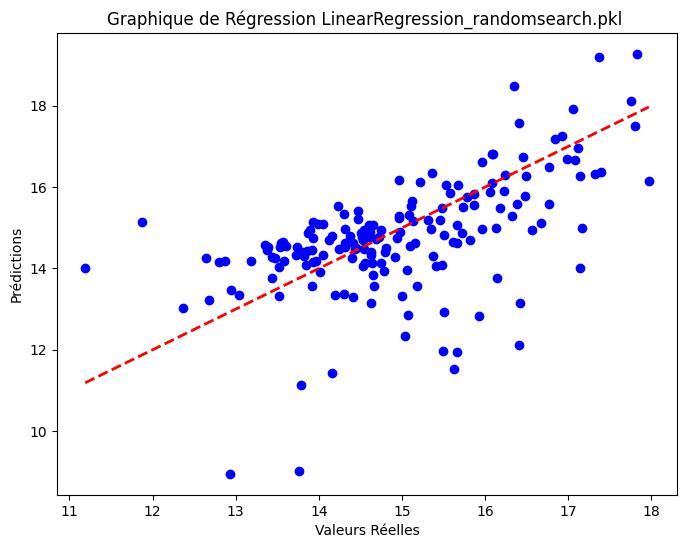

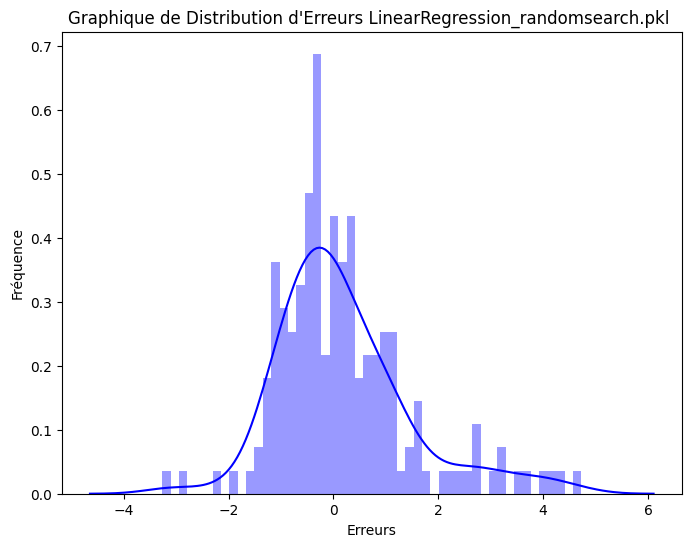

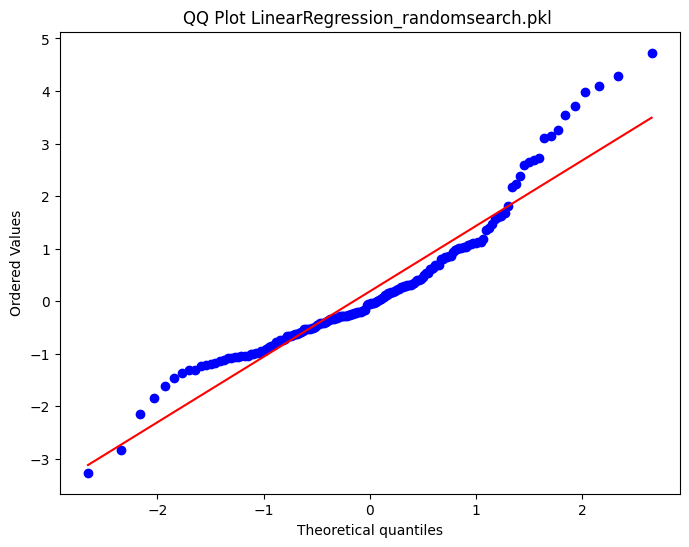

Métrique de performance pour le modèle LinearRegression_standard.pkl :
R²: -1.6604264107649219e+19
RMSE: 5150316743.215852
MAE: 935825244.0571991
MSE: 2.652576255544954e+19


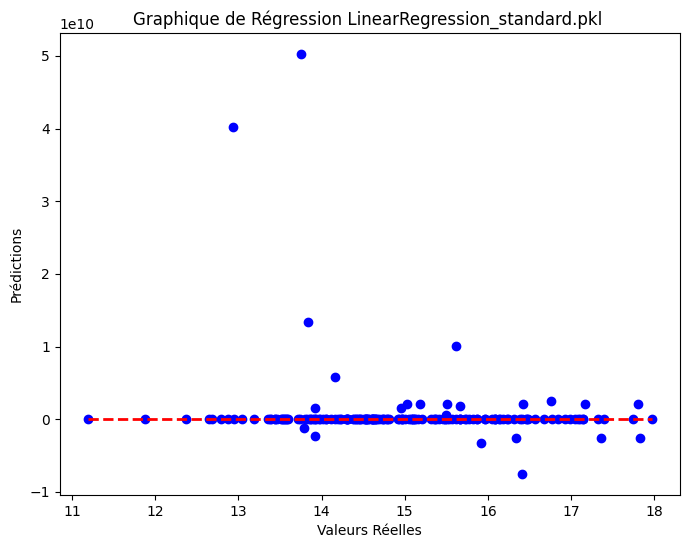

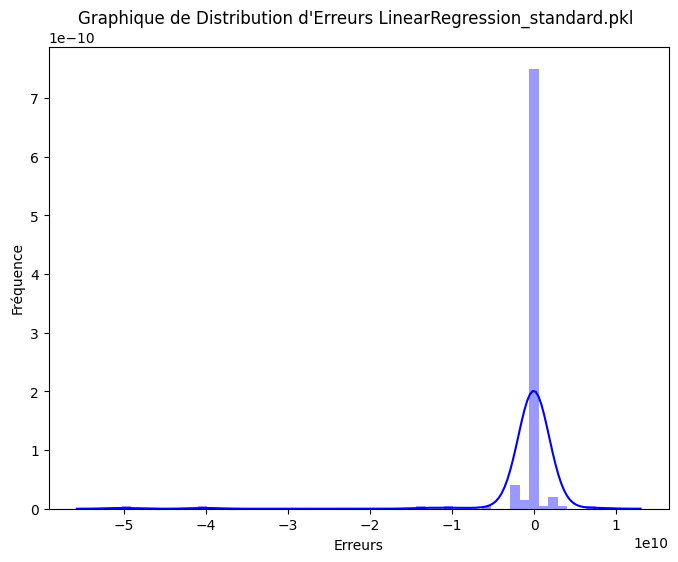

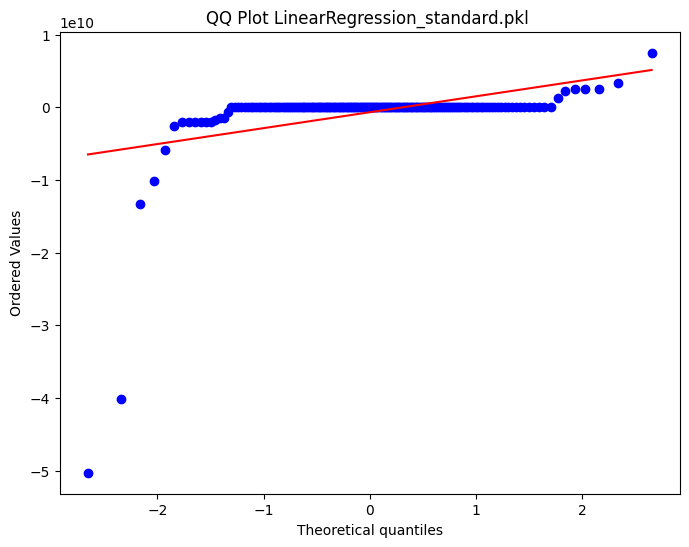

Métrique de performance pour le modèle RandomForestRegressor_gridsearch.pkl :
R²: 0.7012650278238179
RMSE: 0.6908235851403021
MAE: 0.5005759414974122
MSE: 0.47723722578610017


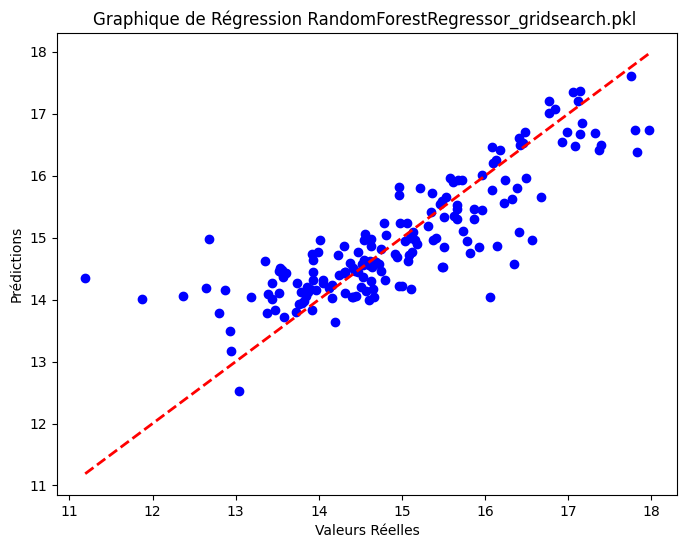

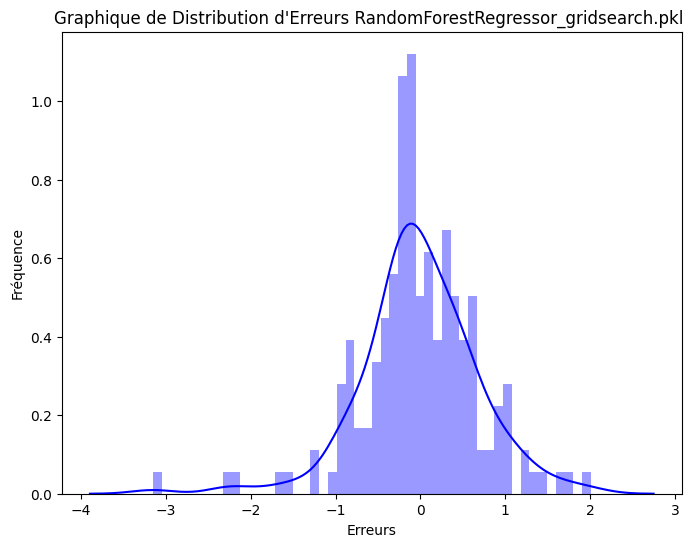

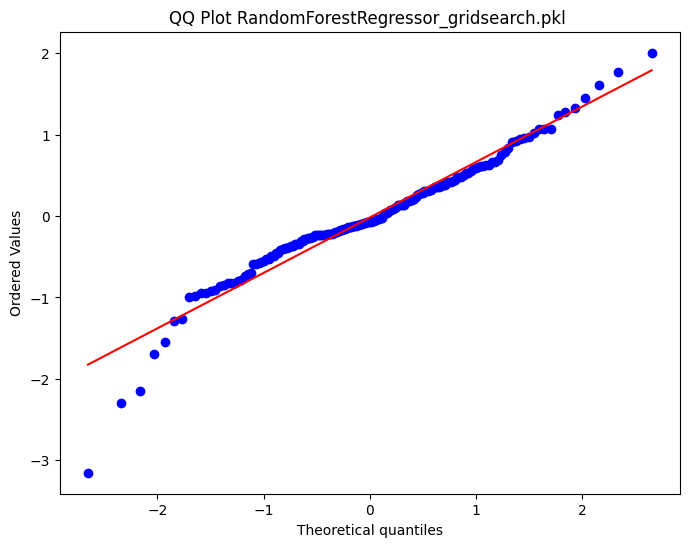

Métrique de performance pour le modèle RandomForestRegressor_randomsearch.pkl :
R²: 0.7012650278238184
RMSE: 0.6908235851403016
MAE: 0.5005759414974121
MSE: 0.4772372257860996


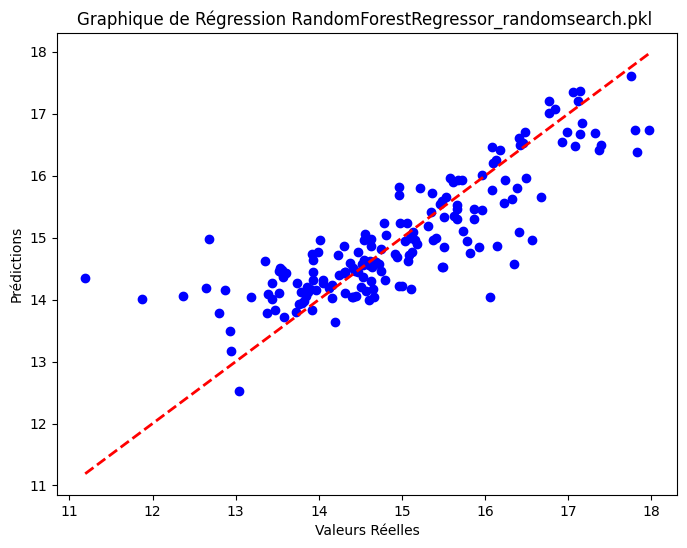

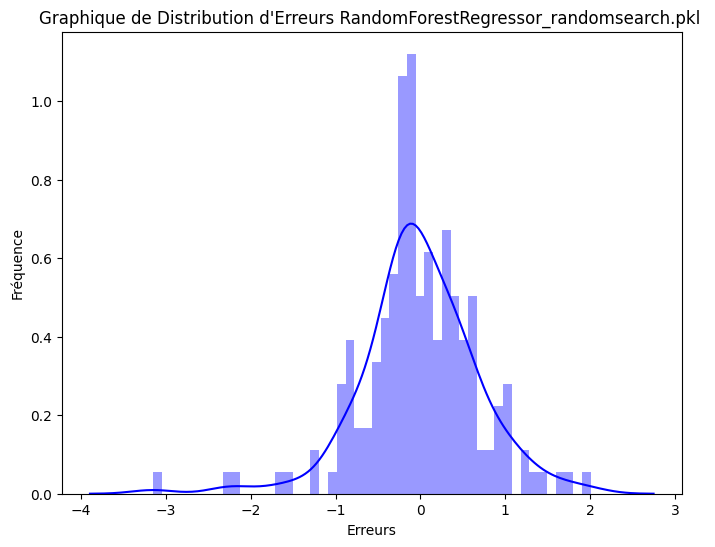

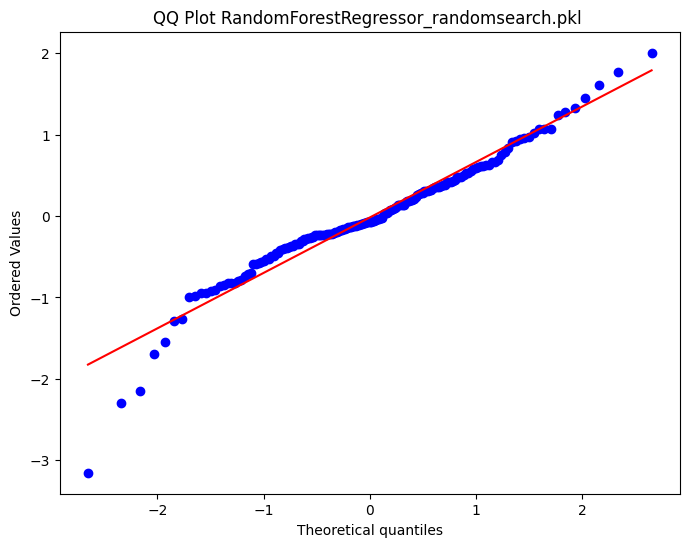

Métrique de performance pour le modèle RandomForestRegressor_standard.pkl :
R²: 0.7044642672085096
RMSE: 0.6871145130478437
MAE: 0.48568387287710135
MSE: 0.47212635404097536


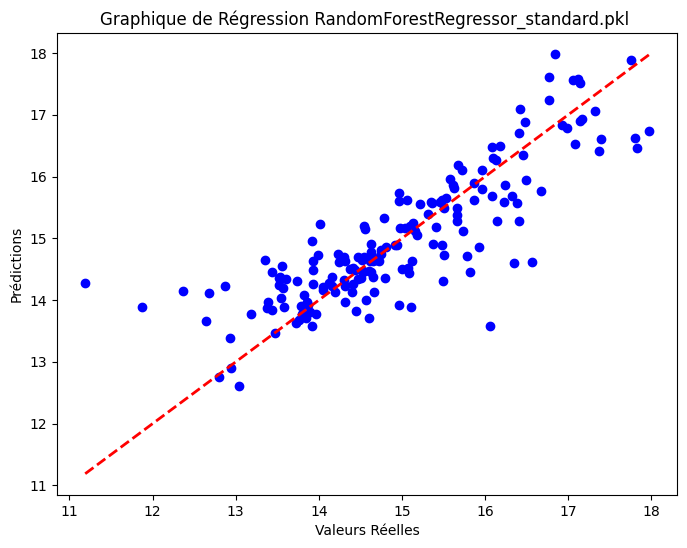

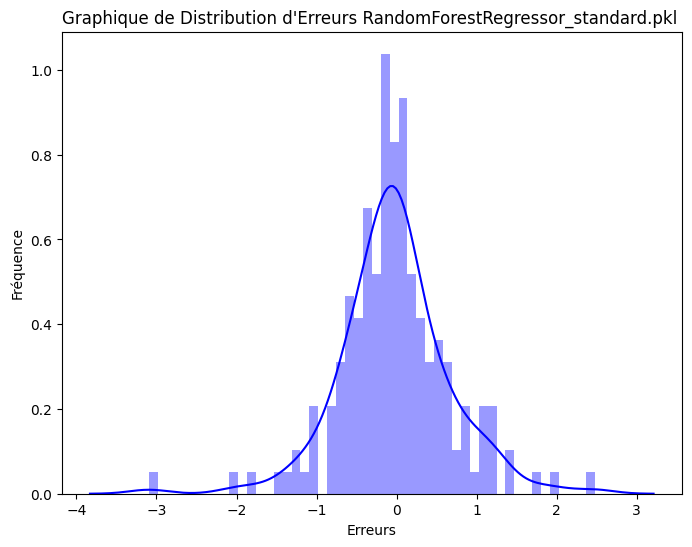

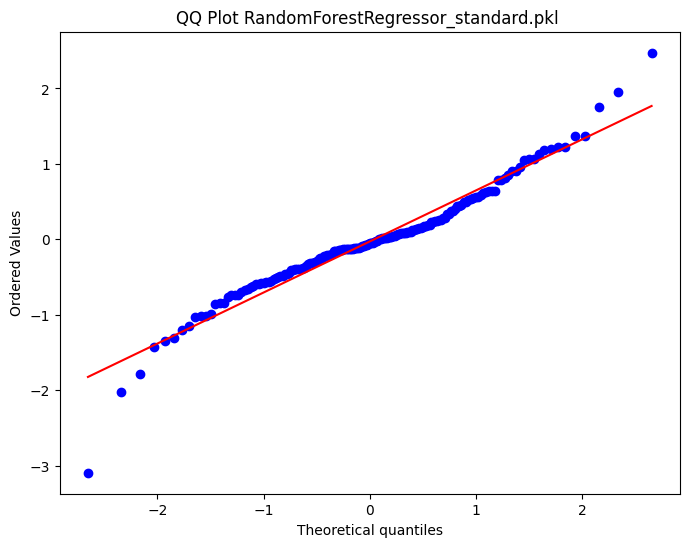

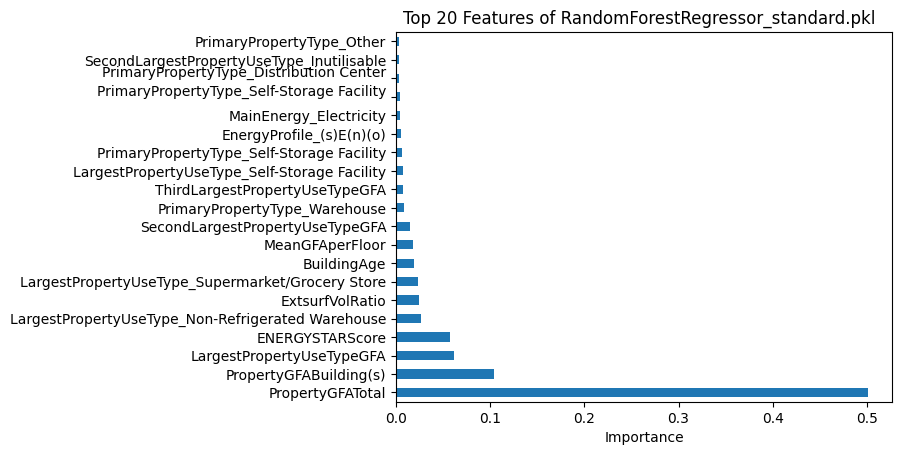

Métrique de performance pour le modèle Ridge_gridsearch.pkl :
R²: 0.005880464793888929
RMSE: 1.2602114656360603
MAE: 0.6607219968487249
MSE: 1.588132938120587


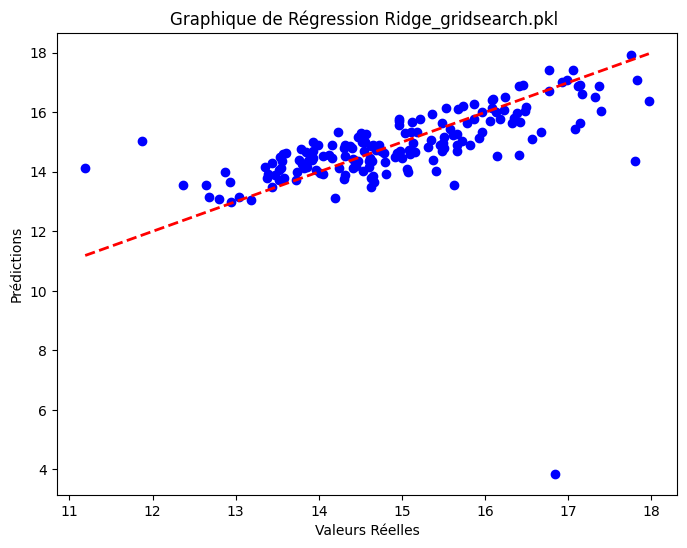

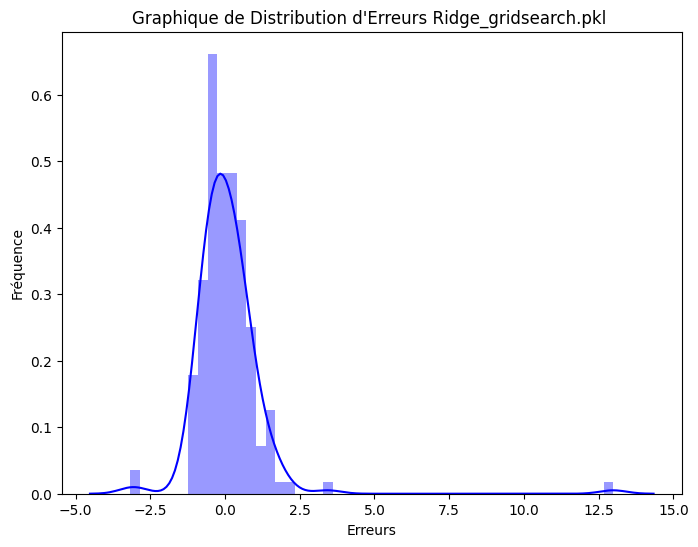

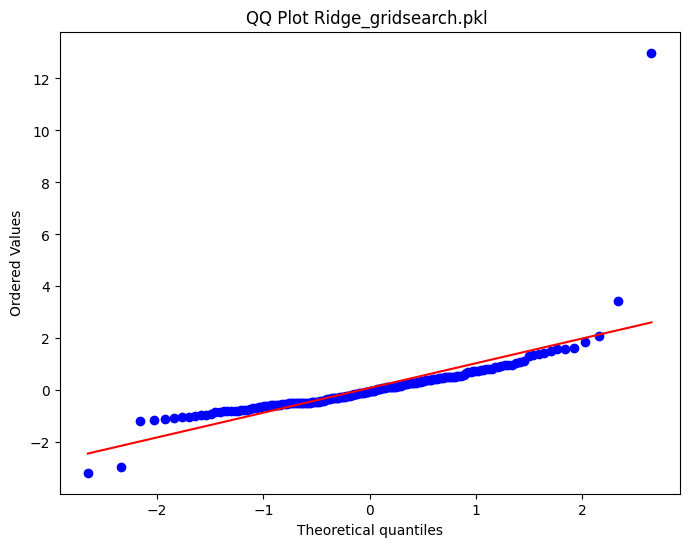

Métrique de performance pour le modèle Ridge_randomsearch.pkl :
R²: 0.005880464793888929
RMSE: 1.2602114656360603
MAE: 0.6607219968487249
MSE: 1.588132938120587


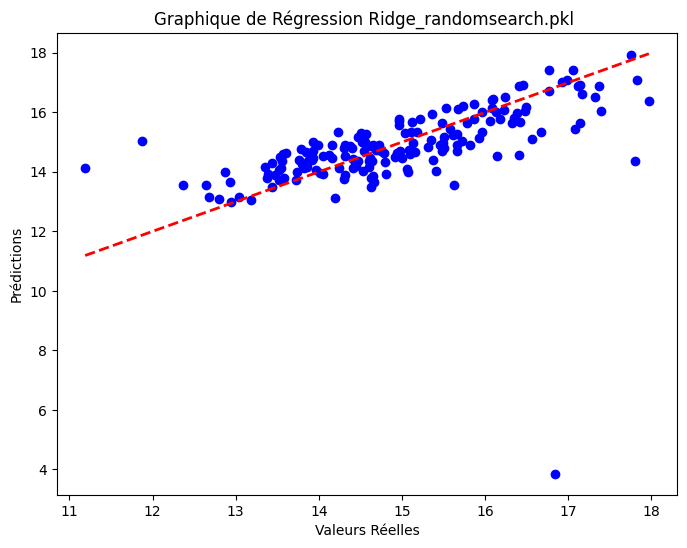

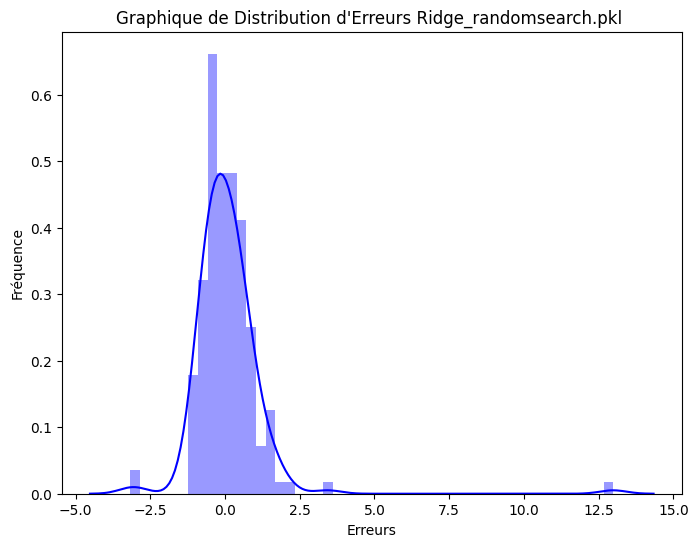

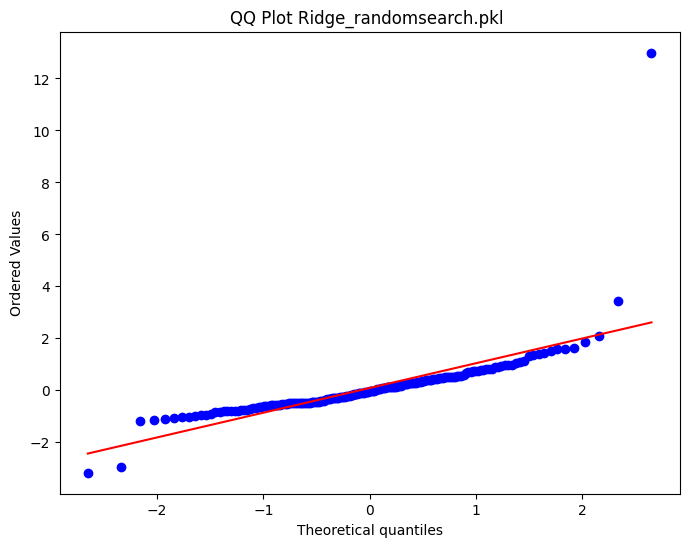

Métrique de performance pour le modèle Ridge_standard.pkl :
R²: 0.005880464793888929
RMSE: 1.2602114656360603
MAE: 0.6607219968487249
MSE: 1.588132938120587


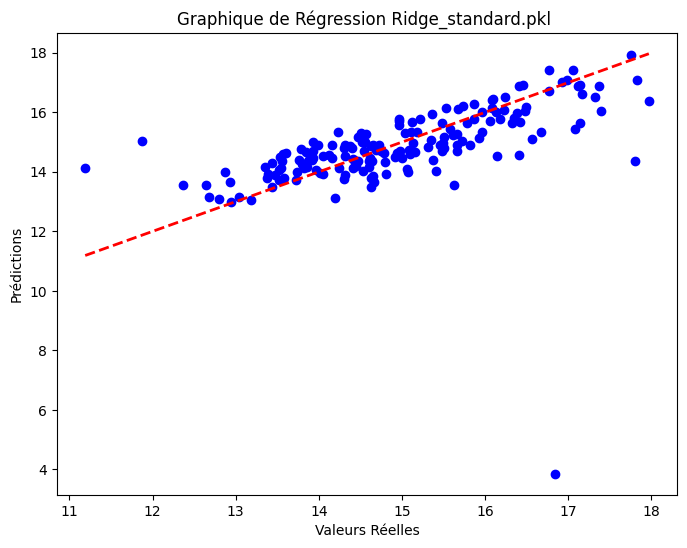

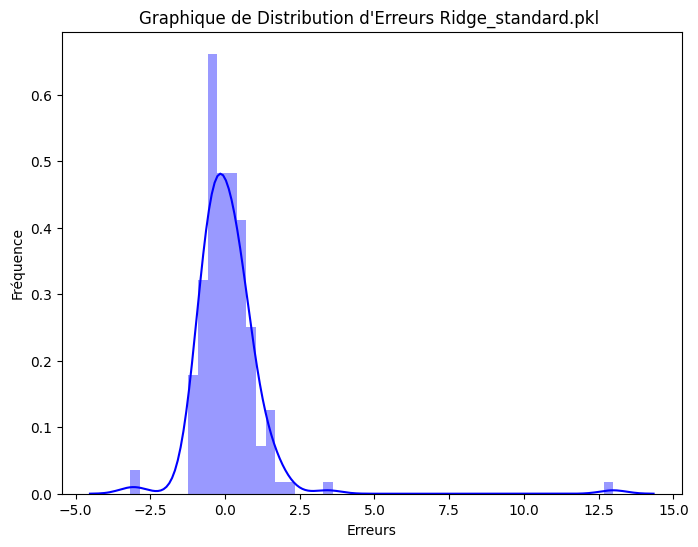

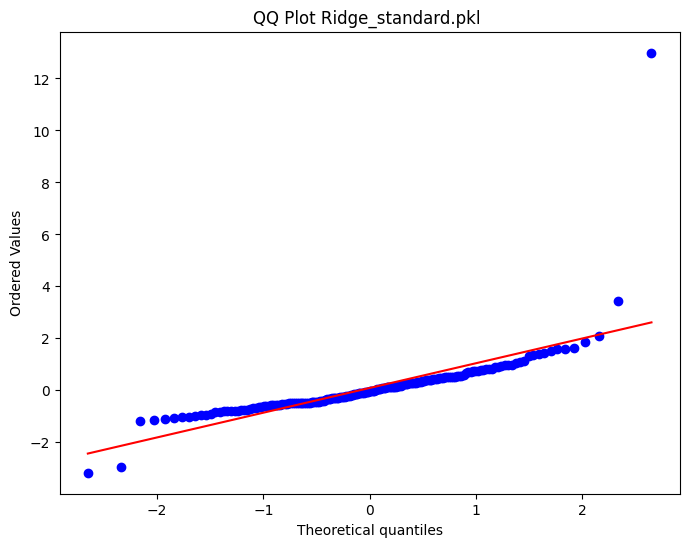

Métrique de performance pour le modèle SVR_gridsearch.pkl :
R²: 0.7634120923516378
RMSE: 0.6147809394552937
MAE: 0.4472492122679689
MSE: 0.3779556035175335


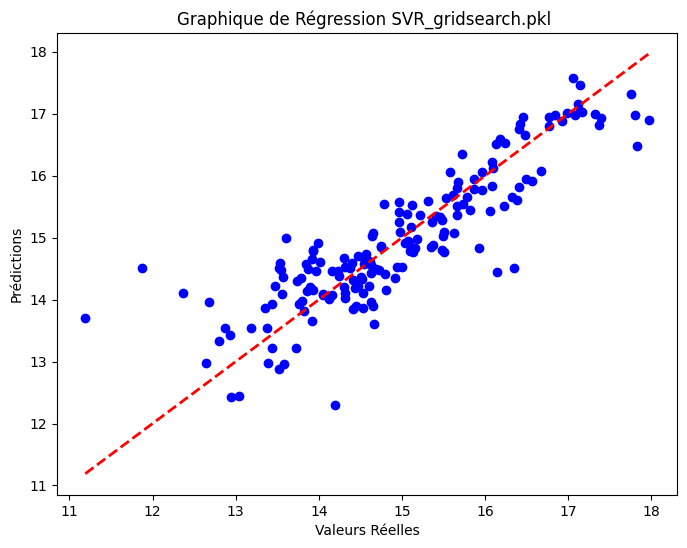

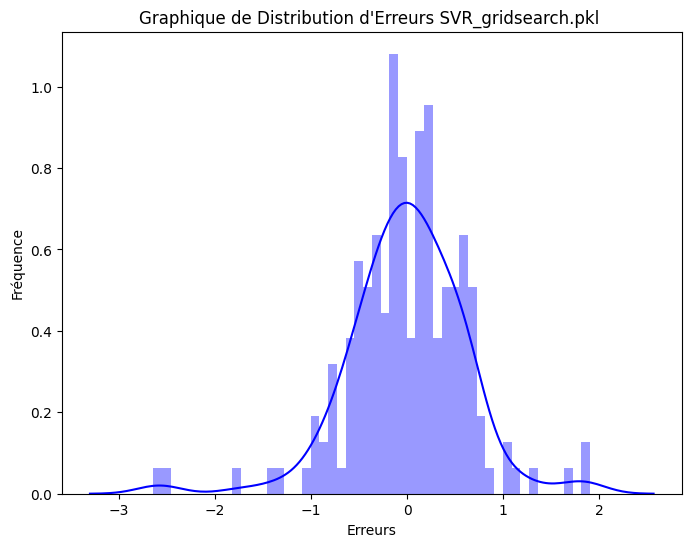

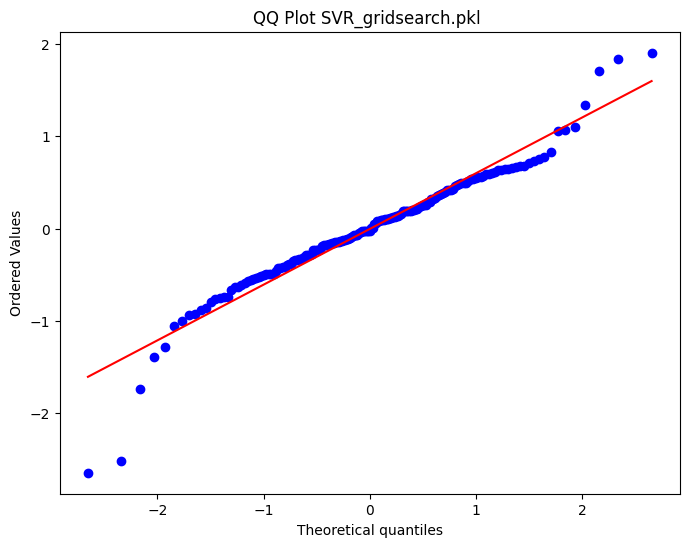

Métrique de performance pour le modèle SVR_randomsearch.pkl :
R²: 0.7634120923516378
RMSE: 0.6147809394552937
MAE: 0.4472492122679689
MSE: 0.3779556035175335


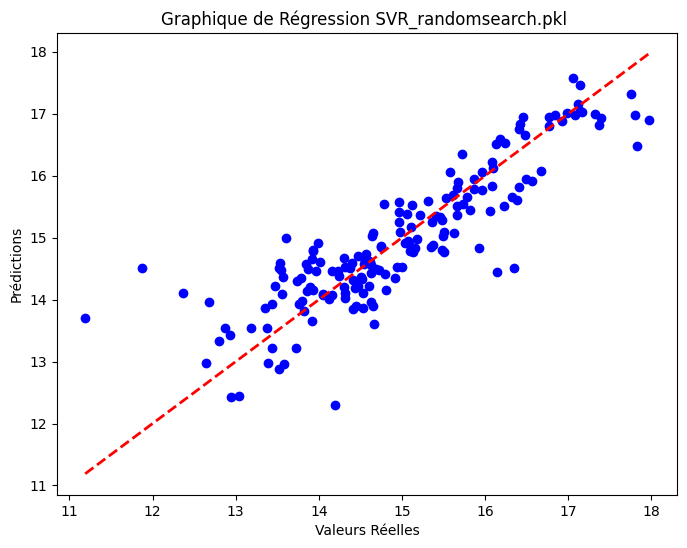

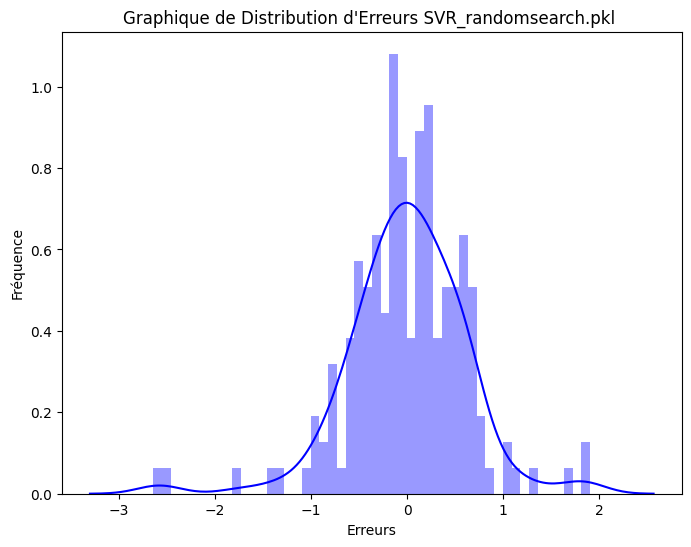

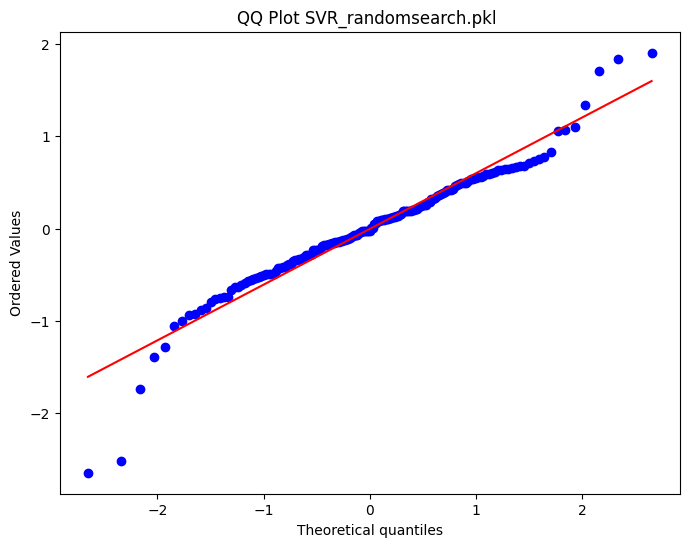

Métrique de performance pour le modèle SVR_standard.pkl :
R²: 0.7253440676718148
RMSE: 0.6623973928982078
MAE: 0.471429481227808
MSE: 0.4387703061183426


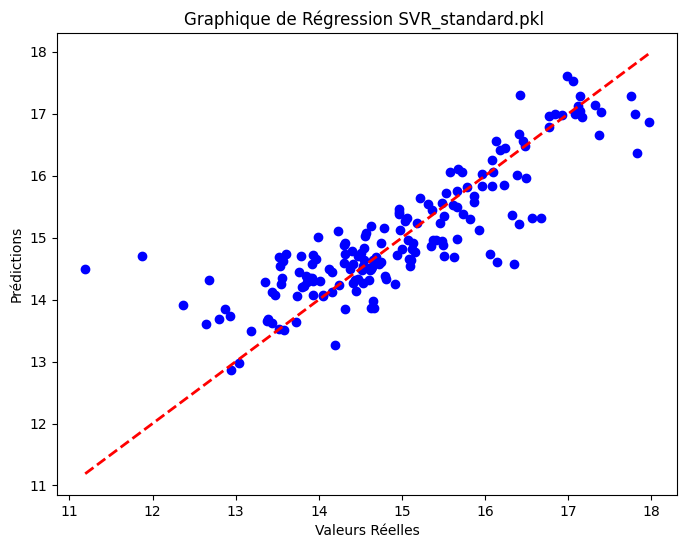

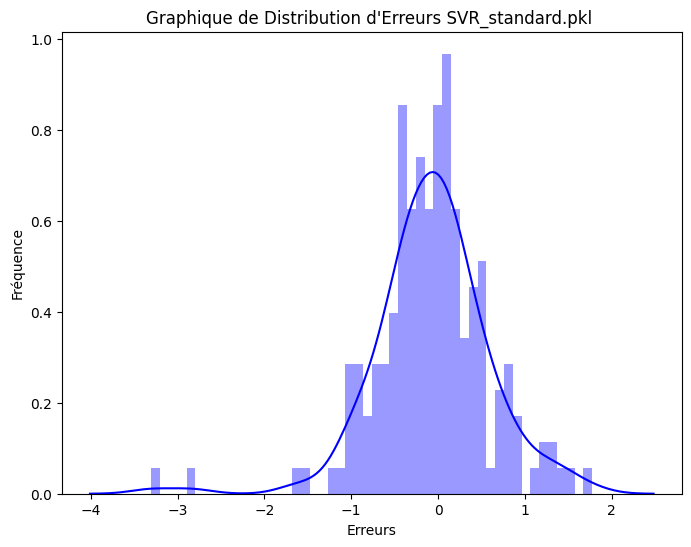

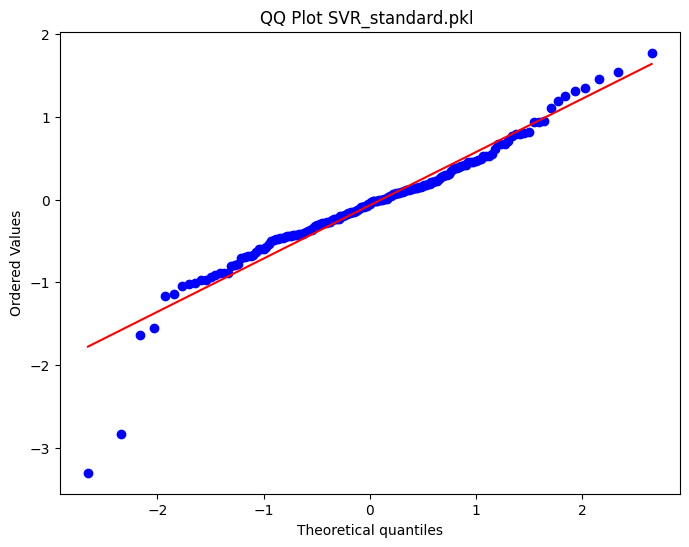

In [18]:
loaded_models = load_and_evaluate_models('../DATA/pickle/SiteEnergyUseWN/withoutlieaires/withENERGYSTARScore/', X_test, y_test, evaluate_model_performance)

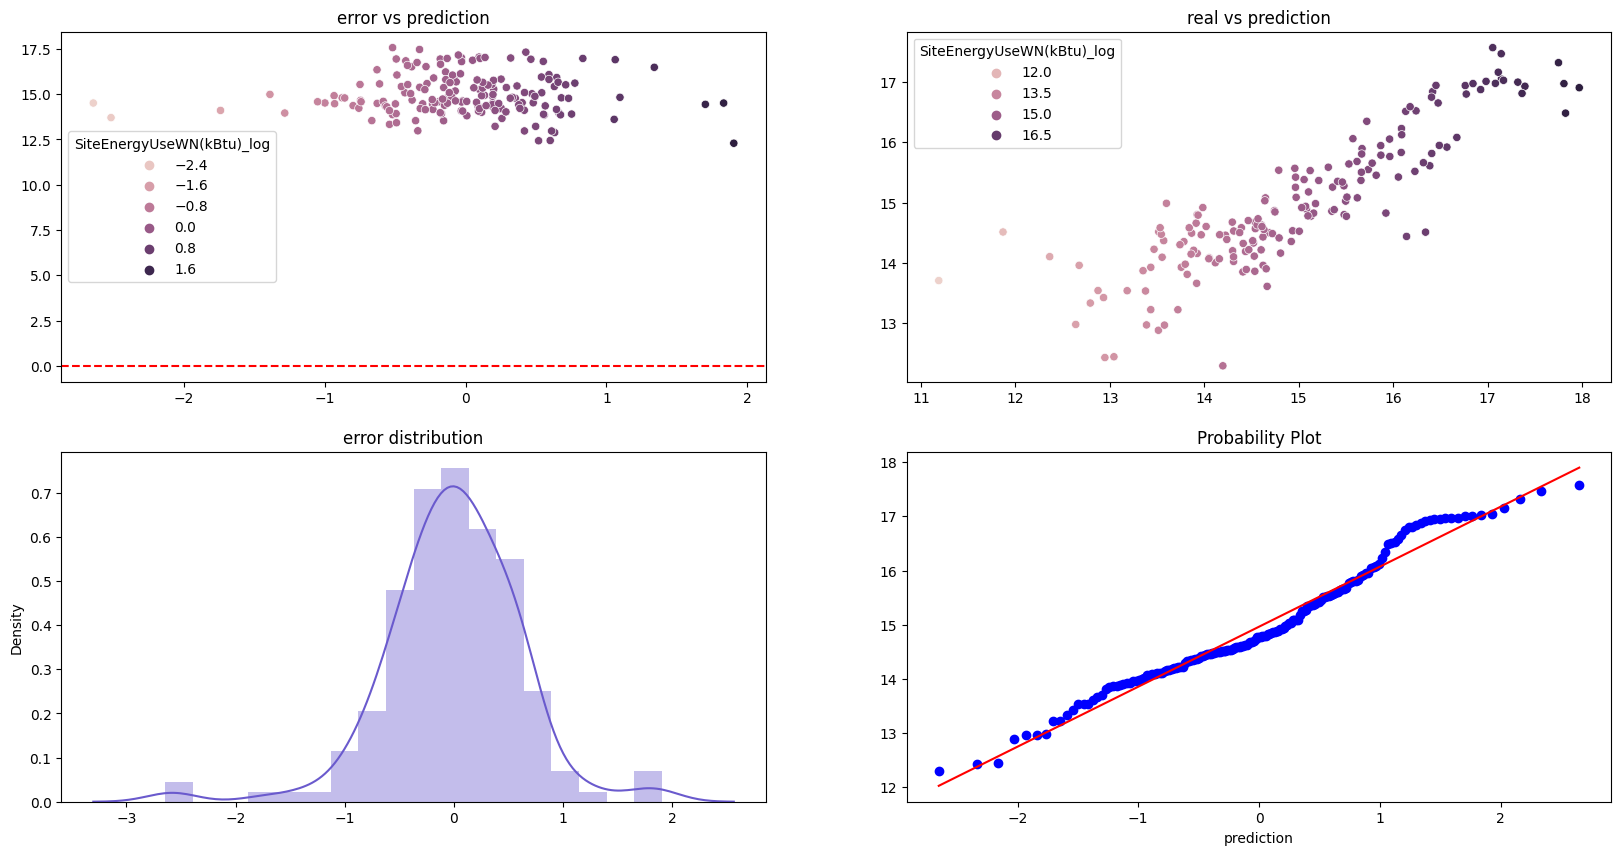

In [19]:
regression_visualizers(get_model='SVR_gridsearch', X_test=X_test, y_test=y_test, get_folder='../DATA/pickle/SiteEnergyUseWN/withoutlieaires/withENERGYSTARScore/')

### Recherche de modèles de prédiction pour la consommation d'energie  (SiteEnergyUseWN)with ENERGYSTARScore and without  outlieares 

## KDTree est utiliser pour repérer les valeurs aberrantes multivariées 

In [20]:
df.shape

(863, 66)

In [21]:
data_cleaned = remove_outliers_with_kdtree(df, k=6, threshold_multiplier=1.5,numerical_columns=prop_Q_cols+target_cols,categorical_columns=prop_Q_cols)

In [22]:
data_cleaned.shape

(854, 67)

In [23]:
X_train, X_test, y_train, y_test = data_preprocessing2(data_cleaned,prop_C_cols,prop_Q_cols,'SiteEnergyUseWN(kBtu)_log',0.2)
display(X_test.shape)
compar_results_energy = regressor_compar(X_train, X_test, y_train, y_test, models=mymodels, 
                                         grids=mygrids, foldername='../data/pickle/SiteEnergyUseWN/withoutoutlinears/withENERGYSTARScore/')

(171, 248)

Comparative table of models…


In [24]:
compar_results_energy

extratree     dummy                       lr     ridge  \
Standard Time      2.113575       0.0                 0.066626  0.009801   
GridSearch Time    3.719708  0.120908                 0.502739  0.200651   
RandomSearch Time  5.309276   0.24614                 0.844766  0.385334   
Standard R²        0.698871 -0.000796 -320022654408390737920.0  0.712541   
GridSearch R²      0.690219 -0.000796                  0.25864  0.712541   
RandomSearch R²    0.677329 -0.000796                  0.25864  0.712541   
Standard RMSE      0.676552  1.233382       22055402084.712124  0.661017   
GridSearch RMSE    0.686202  1.233382                 1.061547  0.661017   
RandomSearch RMSE  0.700333  1.233382                 1.061547  0.661017   

                      lasso   elastic       knn       svr        rfr  \
Standard Time      0.005179  0.005526  0.003026  0.039235   2.278337   
GridSearch Time    0.233806   0.34294  0.398927  0.902478   6.761786   
RandomSearch Time  0.468052  0.698773  0.683901   1.48218  11.449924   
Standard R²       -0.000796  0.178849   0.53845   0.72929    0.69427   
GridSearch R²       0.73049  0.722433  0.531981  0.740688    0.69433   
RandomSearch R²     0.73049  0.722433   0.53845  0.739441    0.69433   
Standard RMSE      1.233382  1.117214  0.837595  0.641471     0.6817   
GridSearch RMSE    0.640048  0.649543  0.843444  0.627821   0.681634   
RandomSearch RMSE  0.640048  0.649543  0.837595  0.629329   0.681634   

                   gradboost  
Standard Time       0.541875  
GridSearch Time    12.784378  
RandomSearch Time  24.730345  
Standard R²          0.72991  
GridSearch R²       0.473349  
RandomSearch R²     0.473349  
Standard RMSE       0.640736  
GridSearch RMSE     0.894717  
RandomSearch RMSE   0.894717

### Recherche de modèles de prédiction pour la consommation d'energie  (SiteEnergyUseWN)without  ENERGYSTARScore and without  outlieares 

In [25]:
prop_Q_cols = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
               'PropertyGFAParking', 'PropertyGFABuilding(s)',
               'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
               'ThirdLargestPropertyUseTypeGFA', 'BuildingAge',
               'MeanGFAperFloor', 'ParkingGFARatio', 'NbYearsCertified',
               'ExtsurfVolRatio'] # ,

In [26]:
X_train, X_test, y_train, y_test = data_preprocessing2(data_cleaned,prop_C_cols,prop_Q_cols,'SiteEnergyUseWN(kBtu)_log',0.2)
display(X_test.shape)
compar_results_energy = regressor_compar(X_train, X_test, y_train, y_test, models=mymodels, 
                                         grids=mygrids, foldername='../data/pickle/SiteEnergyUseWN/withoutoutlinears/withoutENERGYSTARScore/')

(171, 247)

Comparative table of models…


In [27]:
compar_results_energy

extratree     dummy                       lr     ridge  \
Standard Time       2.14289  0.001194                 0.061825  0.010816   
GridSearch Time    3.886861  0.136908                 0.410348   0.19148   
RandomSearch Time  5.595364  0.264139                 0.769091  0.361334   
Standard R²        0.656787 -0.000796 -299472660483768713216.0  0.639322   
GridSearch R²      0.653468 -0.000796                  0.25864  0.639322   
RandomSearch R²    0.654824 -0.000796                  0.25864  0.639322   
Standard RMSE      0.722281  1.233382       21335518838.480358  0.740431   
GridSearch RMSE    0.725766  1.233382                 1.061547  0.740431   
RandomSearch RMSE  0.724344  1.233382                 1.061547  0.740431   

                      lasso   elastic       knn       svr        rfr  \
Standard Time      0.004968  0.007917  0.002988  0.040438   2.437133   
GridSearch Time    0.230306  0.407312  0.447086  0.984607   7.815767   
RandomSearch Time   0.47265  0.789498  0.763847  1.537545  13.689259   
Standard R²       -0.000796  0.178849  0.474866  0.670402   0.680499   
GridSearch R²      0.666718  0.653554  0.480951  0.646562   0.680278   
RandomSearch R²    0.666718  0.653554  0.473285  0.670402   0.680278   
Standard RMSE      1.233382  1.117214  0.893429   0.70781   0.696885   
GridSearch RMSE    0.711755  0.725675  0.888237  0.732962   0.697126   
RandomSearch RMSE  0.711755  0.725675  0.894772   0.70781   0.697126   

                   gradboost  
Standard Time       0.517219  
GridSearch Time     12.57629  
RandomSearch Time  24.537853  
Standard R²         0.694576  
GridSearch R²       0.478174  
RandomSearch R²     0.478174  
Standard RMSE       0.681359  
GridSearch RMSE      0.89061  
RandomSearch RMSE    0.89061

#### Conclusion

Dans le domaine des performances énergétiques des bâtiments de Seattle, il est clairement évident qu'une approche basée sur les algorithmes ensemblistes surpasse les méthodes de prédiction simples.

Au cours de cette étude, nous avons mis en lumière les performances d'un puissant meta-algorithme d'apprentissage ensembliste : le gradboost  ajusté par validation croisée. Ce modèle a démontré une stabilité et une précision exceptionnelles, éliminant ainsi tout risque de surapprentissage.

Il est important de souligner que ce modèle d'apprentissage supervisé est spécifiquement adapté à notre problème métier. Son utilisation permettrait d'éviter les relevés de consommation annuels, entraînant ainsi une réduction significative des coûts, de la charge de travail liée aux tâches fastidieuses et des risques de fuites de données, entre autres avantages.

En ce qui concerne l'utilité de l'"ENERGY STAR Score" dans la prédiction des émissions de SEU, nos résultats indiquent que cet indicateur  contribue  significativement à l'amélioration des prédictions : svr 0.801984

Axes Possibles d'Amélioration

Il existe des opportunités d'amélioration significatives pour nos futures études. Initialement, notre échantillon de données contenait des variables importantes, cependant, il serait bénéfique de l'enrichir davantage. L'ajout de caractéristiques spécifiques telles que les propriétés des isolants thermiques des bâtiments, le type d'éclairage, ou même des données météorologiques pourraient apporter une profondeur supplémentaire à notre analyse. Ce processus d'enrichissement des caractéristiques pourrait potentiellement améliorer la précision de nos modèles et conduire à des prédictions encore plus fiables.
